## Load Libraries


In [5]:
%load_ext autoreload
%autoreload 2

import sys
import os.path as op
# sys.path.insert(0, op.abspath('/home/eabe/Research/MyRepos/TiDHy/'))
import ssm
import itertools
import autograd.numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.decomposition import PCA

np.set_printoptions(suppress=True)

import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

from tqdm.auto import tqdm
from pathlib import Path
from omegaconf import DictConfig, OmegaConf

import TiDHy
from TiDHy.utils.utils import *
from TiDHy.datasets import load_dataset
import TiDHy.utils.io_dict_to_hdf5 as ioh5

##### Plotting settings ######
import matplotlib as mpl
mpl.rcParams.update({'font.size':          10,
                     'axes.linewidth':     2,
                     'xtick.major.size':   5,
                     'ytick.major.size':   5,
                     'xtick.major.width':  2,
                     'ytick.major.width':  2,
                     'axes.spines.right':  False,
                     'axes.spines.top':    False,
                     'pdf.fonttype':       42,
                     'xtick.labelsize':    10,
                     'ytick.labelsize':    10,
                     'figure.facecolor':   'white',
                     'pdf.use14corefonts': True,
                     'font.family':        'Arial',
                    })

from matplotlib.colors import ListedColormap
clrs = ['#1A237E','#7E57C2','#757575','#BDBDBD','#4CAF50','#FF9800','#795548','#FF4081','#00BCD4','#FF1744','#FFFFFF','#000000']
cmap = ListedColormap(clrs)

device = torch.device(1) #torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


device(type='cuda', index=1)

# Load SLDS Model

In [7]:
dataset = 'SLDS'
base_dir = Path('/data/users/eabe/hypernets/{}/DPC_{}/'.format(dataset,dataset))
configs = sorted(list(base_dir.rglob('*config.yaml'))[::2])

for n,conf in enumerate(configs):
    print(n,conf)

0 /data/users/eabe/hypernets/SLDS/DPC_SLDS/ShortWin2/dataset.ssm_params.partial_obs=True,dataset.ssm_params.partial_sup=False,dataset.train.sequence_length=200/config.yaml
1 /data/users/eabe/hypernets/SLDS/DPC_SLDS/ShortWin2/dataset.train.sequence_length=100/config.yaml
2 /data/users/eabe/hypernets/SLDS/DPC_SLDS/ShortWin2/dataset.train.sequence_length=200/config.yaml
3 /data/users/eabe/hypernets/SLDS/DPC_SLDS/ShortWin4/dataset.ssm_params.seed=11,dataset.train.sequence_length=200/config.yaml
4 /data/users/eabe/hypernets/SLDS/DPC_SLDS/ShortWin4/dataset.ssm_params.seed=12,dataset.train.sequence_length=200/config.yaml
5 /data/users/eabe/hypernets/SLDS/DPC_SLDS/ShortWin4/dataset.ssm_params.seed=13,dataset.train.sequence_length=200/config.yaml
6 /data/users/eabe/hypernets/SLDS/DPC_SLDS/ShortWin4/dataset.ssm_params.seed=14,dataset.train.sequence_length=200/config.yaml


In [8]:
n = 2
cfg_path =configs[n]# Path('/data/users/eabe/hypernets/SLDS/DPC_SLDS/TestingNoTempLearning/mix_dim=15/config.yaml')
default_model_config = '/home/eabe/Research/MyRepos/HyperNets/conf/dataset/model/default_model.yaml'
cfg = load_cfg(cfg_path, default_model_config)


In [9]:
data_dict, cfg = load_dataset(cfg)

# ##### Convert to float tensors #####
train_inputs = torch.tensor(data_dict['inputs_train']).float()
test_inputs = torch.tensor(data_dict['inputs_test']).float()
val_inputs = torch.tensor(data_dict['inputs_val']).float()

input_dim = test_inputs.shape[-1]
# test_inputs = test_inputs.unsqueeze(0)
# test_inputs = stack_data(test_inputs,cfg.train.sequence_length,overlap=cfg.train.sequence_length//cfg.train.overlap_factor)
test_inputs = test_inputs.reshape(-1, cfg.train.sequence_length, input_dim)
val_inputs = val_inputs.reshape(-1, cfg.train.sequence_length, input_dim)
# train_inputs = train_inputs.reshape(-1, cfg.train.sequence_length, input_dim)
# cfg.model.input_dim = input_dim



print(f'Our inputs have shape: {test_inputs.shape}')
cfg.model.input_dim = input_dim
test_dataset = torch.utils.data.TensorDataset(test_inputs)
train_dataset = torch.utils.data.TensorDataset(train_inputs)
val_dataset = torch.utils.data.TensorDataset(val_inputs)
# dataloader_train = torch.utils.data.DataLoader(train_dataset,batch_size=train_inputs.shape[0],pin_memory=True,shuffle=False,drop_last=True)
dataloader_test = torch.utils.data.DataLoader(test_dataset,batch_size=test_inputs.shape[0],pin_memory=True,shuffle=False,drop_last=True)
# dataloader_val = torch.utils.data.DataLoader(val_dataset,batch_size=val_inputs.shape[0],shuffle=False,pin_memory=True,drop_last=True)
# device = torch.device("cuda:{}".formt(cfg.train['gpu']) if torch.cuda.is_available() else "cpu")


Creating Dataset...
Setting seed: 10
Setting seed: 10
Setting seed: 10
x Timescales: {'0': -0.025, '1': -0.25, '2': -0.1, '3': -0.5, '4': -0.01, '5': -0.75}, z Timescales: [0.975, 0.975, 0.975]
Our inputs have shape: torch.Size([250, 200, 20])


In [10]:
cfg.model.batch_converge=False
# cfg.model.Orth_alpha_spat = 0

In [11]:
##### Load weights and params #####
rerecord = False
epoch = 1000
model = TiDHy.TiDHy(cfg.model, device, show_progress=cfg.train.show_progress).to(device)
# set_seed(42)
load_path = cfg.paths.ckpt_dir/'best.pth.tar'
load_path = sorted(list(cfg.paths.ckpt_dir.rglob('last_{}.pth.tar'.format(epoch))))[0]
data_load = torch.load(load_path,map_location=device)
model.load_state_dict(data_load['state_dict'])
model.to(device)
print('Loaded from {} epoch'.format(data_load['epoch']))
epoch = data_load['epoch']


# result_dict = load_results(model, dataloader_test, data_dict, device, cfg, epoch, rerecord=rerecord)

Loaded from 1001 epoch


# Save Multi Seq Len

In [12]:
def run_seq_len_model(seq_len, model, data_dict, device, epoch, cfg):
    cfg.train.sequence_length = int(np.max(seq_len))
    data_dict, cfg = load_dataset(cfg)
    result_dict_all = {}
    for new_seq_len in seq_len:
        set_seed(42)
        test_inputs = torch.tensor(data_dict['inputs_test'].reshape(-1,new_seq_len,cfg.model.input_dim)).float()
        test_dataset = torch.utils.data.TensorDataset(test_inputs)
        dataloader_test = torch.utils.data.DataLoader(test_dataset,batch_size=test_inputs.shape[0],pin_memory=True,shuffle=False,drop_last=True)
        result_dict={}
        for Nbatch, batch in enumerate(dataloader_test):
            X = batch[0].to(device,non_blocking=True)
            spatial_loss,temp_loss,result_dict_temp = model.evaluate_record(X)
            if Nbatch==0:
                result_dict = result_dict_temp
            else:
                for key in result_dict.keys():
                    if isinstance(result_dict[key],torch.Tensor):
                        result_dict[key] = torch.cat((result_dict[key],result_dict_temp[key]),dim=0)


        for key in result_dict.keys():
            if isinstance(result_dict[key],torch.Tensor):
                result_dict[key] = result_dict[key].cpu().detach().numpy()
        if 'states_x_test' in data_dict.keys():
            result_dict['states_x_test'] = data_dict['states_x_test']
            result_dict['states_x_train'] = data_dict['states_x']
        if 'As' in data_dict.keys():
            result_dict['As'] = data_dict['As']
            result_dict['bs'] = data_dict['bs']
        if 'states_z_test' in data_dict.keys():
            result_dict['states_z_test'] = data_dict['states_z_test']
            result_dict['states_z_train'] = data_dict['states_z']

        for key in result_dict.keys():
            if isinstance(result_dict[key],dict):
                result_dict[key] = [result_dict[key][key2] for key2 in result_dict[key].keys()]
                
                
        ##### Save Results #####
        ioh5.save(cfg.paths.log_dir/'temp_results_{}_T{:04d}.h5'.format(epoch,new_seq_len),result_dict)
        
        reshape_list = ['W','I','I_hat','I_bar','R_hat','R_bar','R2_hat']
        for key in reshape_list:
            if key in result_dict.keys():
                result_dict[key] = result_dict[key].reshape(-1,result_dict[key].shape[-1])
        result_dict_all['{}'.format(new_seq_len)] = result_dict
    ioh5.save(cfg.paths.log_dir/'temp_results_{}_seq.h5'.format(epoch),result_dict_all)
    print('Done')
    return cfg

In [ ]:
seq_len = [100,200,500,1000]

cfg = run_seq_len_model(seq_len, model, data_dict, device, epoch, cfg)

data_dict, cfg = load_dataset(cfg)


## Load Results

In [13]:
result_dict = ioh5.load(cfg.paths.log_dir/'temp_results_{}_seq.h5'.format(epoch))
seq_len = sorted([int(el) for el in list(result_dict.keys())])
seq_len

[100, 200, 500, 1000]

In [14]:

states_x_test = data_dict['states_x_test']
states_z_test = data_dict['states_z_test']
# states_z_test = data_dict['states_z']
ssm_params = cfg.dataset.ssm_params
##### Set up combinatorics of timescales #####
lst = list(itertools.product([0, 1], repeat=3))
lst2 = list(itertools.product(['F', 'S'], repeat=3))
full_state_z = np.zeros(ssm_params['time_bins_test'],dtype=int)
# full_state_z = np.zeros(ssm_params['time_bins_train'],dtype=int)
for n in range(len(lst)):
    full_state_z[np.apply_along_axis(lambda x: np.all(x == lst[n]),0,states_z_test)] = n


save_figs = False
p=-1
W = result_dict['{}'.format(seq_len[p])]['W'].reshape(-1,result_dict['{}'.format(seq_len[p])]['W'].shape[-1])
# b = result_dict['b'].reshape(-1,result_dict['b'].shape[-1])
I = result_dict['{}'.format(seq_len[p])]['I'].reshape(-1,result_dict['{}'.format(seq_len[p])]['I'].shape[-1])
Ihat = result_dict['{}'.format(seq_len[p])]['I_hat'].reshape(-1,result_dict['{}'.format(seq_len[p])]['I_hat'].shape[-1])
Ibar = result_dict['{}'.format(seq_len[p])]['I_bar'].reshape(-1,result_dict['{}'.format(seq_len[p])]['I_bar'].shape[-1])
R_hat = result_dict['{}'.format(seq_len[p])]['R_hat'].reshape(-1,result_dict['{}'.format(seq_len[p])]['R_hat'].shape[-1])
R_bar = result_dict['{}'.format(seq_len[p])]['R_bar'].reshape(-1,result_dict['{}'.format(seq_len[p])]['R_bar'].shape[-1])
R2_hat = result_dict['{}'.format(seq_len[p])]['R2_hat'].reshape(-1,result_dict['{}'.format(seq_len[p])]['R2_hat'].shape[-1])
# Ut = result_dict['Ut'].reshape(-1,result_dict['Ut'].shape[-2],result_dict['Ut'].shape[-1])
# ##### Plot dynamic matrices #####
if cfg.model.low_rank_temp:
    Uk = torch.bmm(model.temporal.unsqueeze(-1),model.temporal.unsqueeze(1)).data.cpu().detach()
else:
    Uk = model.temporal.data.cpu().detach().reshape(model.mix_dim,model.r_dim,model.r_dim)
    U_t = torch.matmul(torch.Tensor(W[:,None,:]), model.temporal.unsqueeze(0).cpu().detach()).reshape(-1, model.r_dim, model.r_dim).numpy()
As = np.stack([v for v in data_dict['As'].values()])
bs = np.stack([v for v in data_dict['bs'].values()])
nfig = 0
fontsize=13
t = 0; dt = 5000

In [15]:
import pickle
from ssm.util import random_rotation, find_permutation
inputs_train_SLDS=data_dict['inputs_train']
inputs_test_SLDS=data_dict['inputs_test']
seed = cfg.dataset.ssm_params['seed']
with open(cfg.paths.data_dir/'ssm_slds_test_full_{}D_{}K_{}seed.pickle'.format(6,8,seed), 'rb') as handle:
# with open(cfg.paths.data_dir/'ssm_rslds_test.pickle', 'rb') as handle:
    slds = pickle.load(handle)
    posterior = pickle.load(handle)
    SLDS_latents = pickle.load(handle)
    SLDS_states = pickle.load(handle)
    SLDS_emission = pickle.load(handle)
    # q_lem = pickle.load(handle)
    
# # Get the posterior mean of the continuous states
# SLDS_latents = posterior.mean_continuous_states[0]

# # Find the permutation that matches the true and inferred states
# slds.permute(find_permutation(full_state_z, slds.most_likely_states(SLDS_latents, inputs_test_SLDS)))
# SLDS_states = slds.most_likely_states(SLDS_latents, inputs_test_SLDS)

# # Smooth the data under the variational posterior
# SLDS_emission = slds.smooth(SLDS_latents, inputs_test_SLDS)


with open(cfg.paths.data_dir/'ssm_rslds_test_full_{}D_{}K_{}seed.pickle'.format(6,8,seed), 'rb') as handle:
# with open(cfg.paths.data_dir/'ssm_rslds_test.pickle', 'rb') as handle:
    slds = pickle.load(handle)
    posterior = pickle.load(handle)
    rSLDS_latents = pickle.load(handle)
    rSLDS_states = pickle.load(handle)
    rSLDS_emission = pickle.load(handle)
    # q_lem = pickle.load(handle)
    
# Get the posterior mean of the continuous states
# rSLDS_latents = posterior.mean_continuous_states[0]

# # Find the permutation that matches the true and inferred states
# slds.permute(find_permutation(full_state_z, slds.most_likely_states(rSLDS_latents, inputs_test_SLDS)))
# rSLDS_states = slds.most_likely_states(rSLDS_latents, inputs_test_SLDS)

# # Smooth the data under the variational posterior
# rSLDS_emission = slds.smooth(rSLDS_latents, inputs_test_SLDS)

In [16]:
from sklearn.linear_model import RidgeClassifier,LogisticRegression, RidgeClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
# from statsmodels.tsa.api import VAR

nani = full_state_z.shape[0]
ts=-1
reg_variables = [
    result_dict['{}'.format(seq_len[ts])]['R2_hat'],
    result_dict['{}'.format(seq_len[ts])]['W'],
    result_dict['{}'.format(seq_len[ts])]['R_bar'],
    result_dict['{}'.format(seq_len[ts])]['R_hat'],
    result_dict['{}'.format(seq_len[ts])]['I'],
    SLDS_latents,]

labels = ['R2_hat','W','R_bar','R_hat','I','SLDS']
max_acc = 0
tr_batch_size = 40
batch_size = 10
for k,reg_vars in enumerate(reg_variables):
    X_train, X_test, y_train, y_test = train_test_split(reg_vars.reshape(-1,reg_vars.shape[-1]), full_state_z.reshape(-1), test_size=0.25, random_state=42)
    neigh = KNeighborsClassifier(n_neighbors=3,n_jobs=-1)
    neigh.fit(X_train, y_train)
    scores = neigh.score(X_test, y_test)
    print(labels[k],scores)
    if (scores > max_acc) & (labels[k] != 'I'):
        y_pred = neigh.predict(reg_vars.reshape(-1,reg_vars.shape[-1]))
        max_acc = scores
        best_reg_vars = reg_vars
        best_label = labels[k]
        best_pred = y_pred

state_compare = np.stack([rSLDS_states, SLDS_states,best_pred,full_state_z],axis=0)



R2_hat 0.8448
W 0.75728
R_bar 0.43888
R_hat 0.46056
I 0.45176
SLDS 0.42584


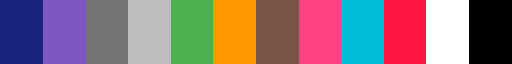

In [17]:
import matplotlib.gridspec as gridspec
fontsize=13

clrs = np.array(['#1A237E','#7E57C2','#757575','#BDBDBD','#4CAF50','#FF9800','#795548','#FF4081','#00BCD4','#FF1744','#FFFFFF','#000000'])
sys_clrs = ['#E3A19F','#E3BE53','#708090','#90CCA9','#B7522E','#B0E0E6','#A89AC2','#556B2F','#FF6F61','#87CEEB','#FFDAB9','#40E0D0']
cmap_sys = ListedColormap(sys_clrs)
clr_ind =[8,8,1,1,9,9]
# clr2 = [sys_clrs[clr_ind[n]] for n in range(len(clr_ind))]
clr_ind3 = [2,8,9]
clr2b = [sys_clrs[clr_ind3[n]] for n in range(len(clr_ind3))]

clrs_b = clrs[[0,1,2,9,4,6,7,8,11]]
cmap = ListedColormap(clrs)
cmap_small = ListedColormap(clrs[:len(np.unique(full_state_z))])
cmap_b = ListedColormap(clrs_b)
cmap
# cmap_b

comp 0, cc: 0.996, ang: 5.24, ang_x:88.8, ang_r:1.12e+02
comp 1, cc: 0.843, ang: 32.6, ang_x:78.9, ang_r:1.23e+02
comp 0, cc: 0.978, ang: 12.2, ang_x:26.0, ang_r:1.29e+02
comp 1, cc: 0.926, ang: 22.2, ang_x:20.6, ang_r:77.4
comp 0, cc: 1.0, ang: 1.27, ang_x:72.4, ang_r:1.16e+02
comp 1, cc: 0.58, ang: 54.6, ang_x:97.0, ang_r:1.22e+02


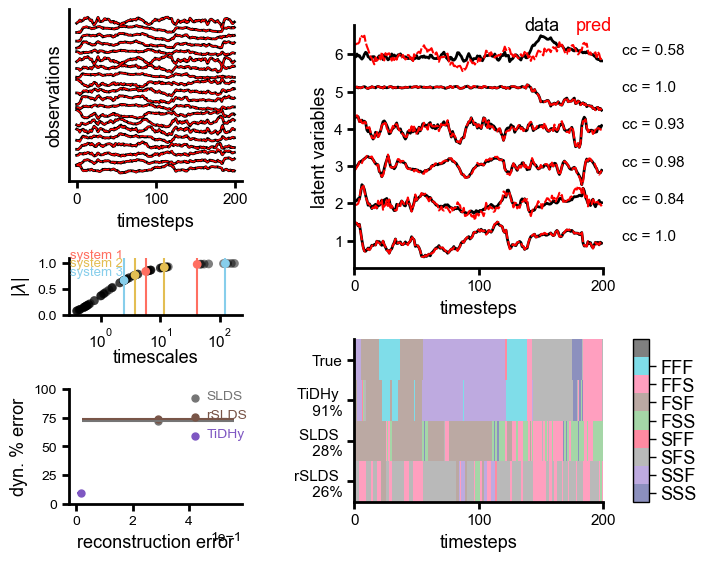

In [18]:
from sklearn.cross_decomposition import CCA
from sklearn.metrics import accuracy_score

n_comps=ssm_params['latent_dim']
t=1500; dt=200
    
fig = plt.figure(constrained_layout=True, figsize=(7,5.5))
gs0 = gridspec.GridSpec(nrows=5,ncols=4, figure=fig, wspace=.45,hspace=.2)

gs00 = gridspec.GridSpecFromSubplotSpec(nrows=6,ncols=1,subplot_spec=gs0[:,:2],wspace=.1,hspace=.2)
# gs01 = gridspec.GridSpecFromSubplotSpec(3,1, subplot_spec=gs0[0:,:1],wspace=.05,hspace=.8)
axs = np.array([fig.add_subplot(gs00[:-3,0]),
                fig.add_subplot(gs00[-3:-2,0]),
                fig.add_subplot(gs00[-2:,0]),
                fig.add_subplot(gs0[:3,2:]),
                fig.add_subplot(gs0[3:,2:])])
axs[4].sharex(axs[3])
ts = -1
##### Pannel a #####
I = result_dict['{}'.format(seq_len[ts])]['I'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I'].shape[-1])
Ihat = result_dict['{}'.format(seq_len[ts])]['I_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I_hat'].shape[-1])
# fig,axs = plt.subplots(1,2,figsize=(5,3),sharey=True,gridspec_kw={'wspace':.15,'width_ratios':[2,1]})
ax = axs[0]
spacing = 1
xrange = 100
cmap2,norm = map_discrete_cbar(cmap_b,len(np.unique(full_state_z)))
linestyle =  (0, (5, 1))#(0, (5, 5))
hlines_I,hlines_Ihat = [],[]
for n in range(I.shape[-1]):
    mean_centered_I = I[t:t+dt,n] - np.mean(I[t:t+dt,n],axis=0)
    ax.plot(mean_centered_I + n/spacing,color='k', lw=2,zorder=1,label='Data')
    hlines_I.append(np.mean(mean_centered_I + n/spacing,axis=0))
    mean_centered_Ihat = Ihat[t:t+dt,n] - np.mean(Ihat[t:t+dt,n],axis=0)
    ax.plot(mean_centered_Ihat + n/spacing, linestyle=linestyle, color='r', lw=1,zorder=2,label='Pred')
    hlines_Ihat.append(np.mean(mean_centered_Ihat + n/spacing,axis=0))

# ax.set_yticks(hlines_I)
ax.set_yticks([])
# ax.set_yticklabels(np.arange(1,len(hlines_I)+1),fontsize=fontsize-2)
ax.set_ylabel('observations',fontsize=fontsize)
ax.set_xticks(np.arange(0,dt+xrange,xrange))
ax.set_xticklabels(np.arange(0,dt+xrange,xrange),fontsize=fontsize-2)
ax.set_xlabel('timesteps',fontsize=fontsize)

##### Pannel c #####
ax = axs[3]
count=0
acc_slds = accuracy_score(full_state_z, SLDS_states)
acc_rslds = accuracy_score(full_state_z, rSLDS_states)
acc_TiDHy = accuracy_score(full_state_z, y_pred)
spacing = .5

hlines_x,hlines_Rhat = [],[]
for p in range(ssm_params['Nlds']):
    # states_x_cca = states_x_train[:,(ssm_params['latent_dim']*(p)):(p+1)*ssm_params['latent_dim']]
    states_x_cca = states_x_test[:,(ssm_params['latent_dim']*(p)):(p+1)*ssm_params['latent_dim']]
    # states_x_cca = states_x_test[:,p:p+1]
    cca = CCA(n_components=ssm_params['latent_dim'],max_iter=1000)
    X_c,Y_c = cca.fit_transform(states_x_cca,R_hat)
    cca_coefficient = np.corrcoef(X_c.T, Y_c.T).diagonal(offset=n_comps)
    x_w = cca.x_weights_
    y_w = cca.y_weights_
    cca_angles = [np.rad2deg(angle_between(X_c[:,n],Y_c[:,n])) for n in range(n_comps)]
    cca_angles_x = [np.rad2deg(angle_between(X_c[:,n],states_x_cca[:,n])) for n in range(n_comps)]
    cca_angles_r = [np.rad2deg(angle_between(Y_c[:,n],R_hat[:,n])) for n in range(n_comps)]
    for n in range(n_comps):
        print('comp {}, cc: {:.03}, ang: {:.03}, ang_x:{:.03}, ang_r:{:.03}'.format(n,cca_coefficient[n],cca_angles[n],cca_angles_x[n],cca_angles_r[n]))

    for i in range(X_c.shape[-1]):
        mean_centered_x = X_c[t:t+dt,i] - np.mean(X_c[t:t+dt,i],axis=0)
        mean_centered_x=mean_centered_x/(np.max(np.abs(mean_centered_x)))
        ax.plot(np.arange(0,dt),mean_centered_x + count/spacing,color='k', lw=2,zorder=1)
        hlines_x.append(np.mean(mean_centered_x + count/spacing,axis=0))
        mean_centered_Rhat = Y_c[t:t+dt,i] - np.mean(Y_c[t:t+dt,i],axis=0)
        mean_centered_Rhat=mean_centered_Rhat/(np.max(np.abs(mean_centered_Rhat)))
        ax.plot(np.arange(0,dt),mean_centered_Rhat + count/spacing,linestyle=linestyle,color='r', lw=1.5,zorder=2,label='$\hat{{r}}_{{{}}}$={:.02}'.format(n,cca_coefficient[n]),alpha=1)
        hlines_Rhat.append(np.mean(mean_centered_Rhat + count/spacing,axis=0))
        ax.text(x=dt+15,y=hlines_x[count],s='cc = {:.02}'.format(cca_coefficient[i]),fontsize=fontsize-2)
        count += 1
    ax.set_yticks(hlines_x) 
    ax.set_yticklabels(np.arange(1,len(hlines_x)+1),fontsize=fontsize-2)
    # ax.set_xlabel('Timesteps',fontsize=fontsize)
    ax.set_ylabel('latent variables',fontsize=fontsize)
# ax.set_xticks([])
ax.set_xticks(np.arange(0,dt+200,200))
ax.set_xticklabels(np.arange(0,dt+200,200),fontsize=fontsize-2)
ax.set_xlabel('timesteps', fontsize=fontsize)
# X,Y = np.meshgrid(np.arange(0,dt),np.arange(-1,2*6))
# im = ax.pcolormesh(X,Y,np.tile(full_state_z[None,t:t+dt],(2*6+1,1)),cmap=cmap,norm=norm,alpha=.5,rasterized=True,zorder=-1)
ax.legend(['data','pred'],frameon=False,fontsize=fontsize,loc='upper right',bbox_to_anchor=(1.1,1.1),labelcolor='linecolor',handlelength=0,handleheight=0,ncols=2,columnspacing=.1)

##### Pannel b #####
ax = axs[1]
dts = 1/len(np.unique(full_state_z))
y_ranges=np.repeat([[0,1]],3,axis=0)
timescales_As = 1/np.abs(np.real(np.log(np.linalg.eigvals(As)))[:,:,0].reshape(-1))
evals_As = np.linalg.eigvals(As)[:,:,0].reshape(-1)
R_bar = result_dict['{}'.format(seq_len[ts])]['R_bar'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_bar'].shape[-1])
R_hat = result_dict['{}'.format(seq_len[ts])]['R_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_hat'].shape[-1])
Uhat_all = []
for state in range(len(np.unique(full_state_z))):
    rhat2 = R_hat[np.where(full_state_z==state)[0],:]
    Uhat_0 = np.linalg.inv(rhat2[:-1].T@rhat2[:-1])@rhat2[:-1].T@rhat2[1:]
    Uhat_all.append(Uhat_0)
    
# for p in range(ssm_params.Nlds):
#     for state in range(ssm_params.n_disc_states):
#         rhat2 = R_hat[np.where(states_z_test[p]==state)[0],:]
#         Uhat_0 = np.linalg.inv(rhat2[:-1].T@rhat2[:-1])@rhat2[:-1].T@rhat2[1:]
#         Uhat_all.append(Uhat_0)
        
Uhat_all = np.stack(Uhat_all)
evals_Uhat_all = np.linalg.eigvals(Uhat_all).reshape(-1)
timescales = 1/np.abs(np.real(np.log(evals_Uhat_all)))
ax.scatter(x=timescales,y=np.abs(evals_Uhat_all),
            c='k',s=40,alpha=.5,edgecolor='None')
for n in range(len(timescales_As)):
    ax.axvline(x=timescales_As[n],c=sys_clrs[clr_ind[n]])
    ax.scatter(x=timescales_As[n],y=np.abs(evals_As[n]),
            c=sys_clrs[clr_ind[n]],s=40,alpha=1,edgecolor='None')
ax.set_xscale('symlog',linthresh=.1)
ax.set_yticks([0,.5,1])
ax.set_ylim(0,1.1)
# ax.set_yticks([np.diff(y_ranges)[0,0]/2 + q*dts for q in range(len(np.unique(full_state_z)))])
# ax.set_yticklabels([''.join(lst2[n]) for n in range(len(lst2))],fontsize=fontsize-2)
# ax.set_xticks([0,-10e0,-10e-1])
ax.tick_params(axis='x', labelsize=fontsize-2)
ax.set_ylabel('|$\lambda$|',fontsize=fontsize)
y = 1
dy = 0.15
ax.annotate('system 1', xy=(.01,y),xycoords='axes fraction',color=sys_clrs[clr_ind[0]],fontsize=fontsize-3.5)
ax.annotate('system 2', xy=(.01,y-dy),xycoords='axes fraction',color=sys_clrs[clr_ind[2]],fontsize=fontsize-3.5)
ax.annotate('system 3', xy=(.01,y-2*dy),xycoords='axes fraction',color=sys_clrs[clr_ind[4]],fontsize=fontsize-3.5)
# ax.set_xticks([0,-10e0,-10e-1])
ax.set_xlabel('timescales',fontsize=fontsize,labelpad=-1)

######### Accuracy and reconstruction error #########
ax = axs[2]
Input_Errors_SLDS = np.abs(inputs_test_SLDS-SLDS_emission)
Input_Errors_rSLDS = np.abs(inputs_test_SLDS-rSLDS_emission)
Input_Errors = np.abs(I-result_dict['{}'.format(seq_len[ts])]['I_hat'])
err_slds  = 100*(1-accuracy_score(full_state_z, SLDS_states))
err_rslds = 100*(1-accuracy_score(full_state_z, rSLDS_states))
err_TiDHy = 100*(1-accuracy_score(full_state_z, y_pred))
ax.scatter(x=np.mean(Input_Errors_SLDS),y=err_slds, s=25, c=clrs[2],label='SLDS')
ax.errorbar(x=np.mean(Input_Errors_SLDS),y=err_slds, ecolor=clrs[2],xerr=np.std(Input_Errors_SLDS))#/np.sqrt(len(Input_Errors_SLDS)))
ax.scatter(x=np.mean(Input_Errors_rSLDS),y=err_rslds, s=25,c=clrs[6],label='rSLDS')
ax.errorbar(x=np.mean(Input_Errors_rSLDS),y=err_rslds, ecolor=clrs[6],xerr=np.std(Input_Errors_rSLDS))#/np.sqrt(len(Input_Errors_SLDS)))
ax.scatter(x=np.mean(Input_Errors),y=err_TiDHy, s=25, c=clrs[1],label='TiDHy')
ax.errorbar(x=np.mean(Input_Errors),y=err_TiDHy, ecolor=clrs[1],xerr=np.std(Input_Errors))#/np.sqrt(len(Input_Errors_SLDS)))
ax.set_yticks([0,25,50,75,100])
ax.set_xlabel('reconstruction error',fontsize=fontsize)
ax.set_ylabel('dyn. % error',fontsize=fontsize)
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0),useLocale=True)
ax.legend(frameon=False,fontsize=fontsize-3,loc='upper right',bbox_to_anchor=(1.1,1.1),labelcolor='linecolor',handlelength=0,handleheight=0,ncols=1,columnspacing=.1)

##### Pannel d #####
ax = axs[4]
ylabels_states = ['rSLDS \n {:02}%'.format(int(np.round(acc_rslds*100))),
                  'SLDS \n {:02}%'.format(int(np.round(acc_slds*100))),
                  'TiDHy \n {:02}%'.format(int(np.round(acc_TiDHy*100))),
                  'True']
im = ax.pcolormesh(state_compare[:,t:t+dt],cmap=cmap2,norm=norm,alpha=.5,rasterized=True)
ax.set_xticks(np.arange(0,dt+xrange,xrange))
ax.set_xticklabels(np.arange(0,dt+xrange,xrange),fontsize=fontsize-2)
ax.set_yticks(np.arange(.5,4,1))
ax.set_yticklabels(ylabels_states,fontsize=fontsize-2)
ax.set_xlabel('timesteps',fontsize=fontsize)

cbar = fig.colorbar(im,ax=axs[-1],aspect=10, pad=-.2)

cbar.set_ticks(np.arange(0,len(np.unique(full_state_z)),1))
cbar.set_ticklabels([''.join(lst2[n]) for n in np.arange(len(lst2)-1,-1,-1)],fontsize=fontsize)
cbar.outline.set_linewidth(1)
cbar.minorticks_off()
cbar.ax.tick_params(width=1,which="major")
# fig.tight_layout()
# fig.savefig(cfg.paths.fig_dir/'Benchmark_Compare3.pdf',dpi=300)
# fig.savefig(cfg.paths.fig_dir/'{}_Fig2_V2.pdf'.format(nfig),dpi=300)


In [ ]:
# timescales_As = 1/np.abs(np.real(np.log(np.linalg.eigvals(As)))[:,:,0].reshape(-1))
np.log((np.linalg.eigvals(As))),np.linalg.eigvals(As),np.log([.97,.78])

In [ ]:

nani = full_state_z.shape[0]
ts=1
best_pred_all = []
acc_ssm = accuracy_score(full_state_z, SLDS_states)
acc_TiDHy_all = []
for ts in range(len(seq_len)):
    reg_variables = [
        # np.concatenate([result_dict['{}'.format(seq_len[ts])]['R2_hat'],result_dict['{}'.format(seq_len[ts])]['W']],axis=-1)
        result_dict['{}'.format(seq_len[ts])]['R2_hat'],
        # q_lem_x,
        ]

    labels = ['R2_hat']
    # reg_variables = W
    max_acc = 0
    for k,reg_vars in enumerate(reg_variables):
        X_train, X_test, y_train, y_test = train_test_split(reg_vars.reshape(-1,reg_vars.shape[-1]), full_state_z.reshape(-1), test_size=0.25, random_state=42)
        neigh = KNeighborsClassifier(n_neighbors=3,n_jobs=-1)
        neigh.fit(X_train, y_train)
        scores = neigh.score(X_test, y_test)
        y_pred = neigh.predict(reg_vars.reshape(-1,reg_vars.shape[-1]))
        print(labels[k],scores)
        acc_TiDHy = accuracy_score(full_state_z, y_pred)
        acc_TiDHy_all.append(acc_TiDHy)
        best_pred_all.append(y_pred)

state_compare = np.concatenate([SLDS_states[None,:],np.stack(best_pred_all),full_state_z[None,:]],axis=0)



In [ ]:
ts = 1
Input_Errors = np.abs(I-result_dict['{}'.format(seq_len[ts])]['I_hat'])
np.mean(Input_Errors),np.std(Input_Errors)

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(8,6))
gs0 = gridspec.GridSpec(nrows=4,ncols=2, figure=fig, wspace=.15,hspace=.2)
axs = np.array([fig.add_subplot(gs0[:2,0]),fig.add_subplot(gs0[2:,0]),fig.add_subplot(gs0[:2,1]),fig.add_subplot(gs0[2:,1])])
t=1500; dt=200
# seq_len=[100,200,500]

Input_Errors_SLDS = (inputs_test_SLDS-SLDS_emission)
ax = axs[0]
Input_Errors_SLDS = np.abs(inputs_test_SLDS-SLDS_emission)
Input_Errors_rSLDS = np.abs(inputs_test_SLDS-rSLDS_emission)
err_slds  = 100*(1-accuracy_score(full_state_z, SLDS_states))
err_rslds = 100*(1-accuracy_score(full_state_z, rSLDS_states))
for ts in range(len(seq_len)):
    Input_Errors = np.abs(I-result_dict['{}'.format(seq_len[ts])]['I_hat'])
    err_TiDHy = 100*(1-accuracy_score(full_state_z, y_pred))
    ax.scatter(x=np.mean(Input_Errors),y=err_TiDHy, s=25, c=clrs_b[ts],label='TiDHy')
    ax.errorbar(x=np.mean(Input_Errors),y=err_TiDHy, ecolor=clrs_b[ts],xerr=np.std(Input_Errors))#/np.sqrt(len(Input_Errors_SLDS)))

ax.scatter(x=np.mean(Input_Errors_SLDS),y=err_slds, s=25, c=clrs[2],label='SLDS')
ax.errorbar(x=np.mean(Input_Errors_SLDS),y=err_slds, ecolor=clrs[2],xerr=np.std(Input_Errors_SLDS))#/np.sqrt(len(Input_Errors_SLDS)))
ax.scatter(x=np.mean(Input_Errors_rSLDS),y=err_rslds, s=25,c=clrs[6],label='rSLDS')
ax.errorbar(x=np.mean(Input_Errors_rSLDS),y=err_rslds, ecolor=clrs[6],xerr=np.std(Input_Errors_rSLDS))#/np.sqrt(len(Input_Errors_SLDS)))
ax.set_yticks([0,25,50,75,100])
ax.set_xlabel('reconstruction error',fontsize=fontsize)
ax.set_ylabel('dyn. % error',fontsize=fontsize)
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0),useLocale=True)
ax.tick_params(axis='x', labelsize=fontsize-2)
ax.tick_params(axis='y', labelsize=fontsize-2)
y = .95
dy = 0.075
for tts in range(len(seq_len)):
    ax.annotate('T={}'.format(seq_len[tts]), xy=(.8,y-tts*dy),xycoords='axes fraction',color=clrs_b[tts],fontsize=fontsize-2)
tts+=1
ax.annotate('SLDS', xy=(.8,y-tts*dy),xycoords='axes fraction',color=clrs[2],fontsize=fontsize-2)
tts += 1
ax.annotate('rSLDS', xy=(.8,y-tts*dy),xycoords='axes fraction',color=clrs[6],fontsize=fontsize-2)


states_z_test = data_dict['states_z_test']
ax = axs[1]
As = np.stack([v for v in data_dict['As'].values()])
timescales_As = 1/np.abs(np.real(np.log(np.linalg.eigvals(As)))[:,:,0].reshape(-1))
ts = 0
dts = 1/len(seq_len)
y_ranges = np.arange(0,1,(dts*dts)).reshape(-1,len(seq_len))[:,(0,-1)]
for ts in range(len(seq_len)):
    R_bar = result_dict['{}'.format(seq_len[ts])]['R_bar'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_bar'].shape[-1])
    R_hat = result_dict['{}'.format(seq_len[ts])]['R_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_hat'].shape[-1])

    ##### Plottign Eigenvalues #####
    Uhat_all = []
    for state in range(len(np.unique(full_state_z))):
        # rhat2 = R_hat[np.where(full_state_z==state)[0],:]
        # model = VAR(rhat2)
        # results = model.fit(maxlags=20,ic='aic')
        # eig_Ut = np.linalg.eigvals(results.coefs).reshape(-1)
        # Uhat_all.append(eig_Ut.reshape(-1))
    # for p in range(ssm_params.Nlds):
    #     for state in range(ssm_params.n_disc_states):
            # rhat2 = R_hat[np.where(states_z_test[p]==state)[0],:]
        rhat2 = R_hat[np.where(full_state_z==state)[0],:]
        Uhat_0 = np.linalg.inv(rhat2[:-1].T@rhat2[:-1])@rhat2[:-1].T@rhat2[1:]
        Uhat_all.append(Uhat_0)

    Uhat_all = np.stack(Uhat_all)
    # evals_Uhat_all = np.hstack(Uhat_all)
    # timescales = 1/np.abs(np.log(np.real(evals_Uhat_all)))
    # timescales = np.real(np.log(Uhat_all))
    evals_Uhat_all = np.linalg.eigvals(Uhat_all).reshape(-1)
    timescales = 1/np.abs(np.real(np.log(evals_Uhat_all)))
    
    ax.scatter(x=timescales,y=np.abs(evals_Uhat_all)+ts,
               c=clrs_b[ts],alpha=.75,edgecolor='None',s=25)

    for n in range(len(timescales_As)):
        ax.axvline(x=timescales_As[n],c=sys_clrs[clr_ind[n]])
        ax.axhline(y=ts,c=clrs_b[ts],linestyle='--',zorder=-1)
    # ax = plot_hist(timescales,-1.75,.1,.1,ax,'TiDHy',clr=clrs_b[ts])
    ax.set_xscale('symlog',linthresh=.1)
    ax.set_yticks([1/2 + q for q in range(len(seq_len))])
    ax.set_yticklabels(seq_len,fontsize=fontsize-2)
    ax.set_ylabel('T',fontsize=fontsize,labelpad=-2)
    # ax.spines.left.set_visible(False)
    ax.set_xlabel('timescales',fontsize=fontsize,labelpad=-3)
# ax.set_xticks([0,-10e0,-10e-1])
ax.tick_params(axis='x', labelsize=fontsize-2)
ax.set_xscale('symlog',linthresh=.015)
y = .99
dy = 0.075
ax.annotate('System 1', xy=(.01,y),xycoords='axes fraction',color=sys_clrs[clr_ind[0]],fontsize=fontsize-2)
ax.annotate('System 2', xy=(.01,y-dy),xycoords='axes fraction',color=sys_clrs[clr_ind[2]],fontsize=fontsize-2)
ax.annotate('System 3', xy=(.01,y-2*dy),xycoords='axes fraction',color=sys_clrs[clr_ind[4]],fontsize=fontsize-2)

ax=axs[2]
spacing= 5
for p in range(len(seq_len)):
    hlines_x = []
    for n in range(result_dict['{}'.format(seq_len[p])]['R_hat'].shape[-1]):
        trace = result_dict['{}'.format(seq_len[p])]['R_hat'][t:t+dt,n]
        mean_centered_x = trace - np.mean(trace,axis=0)
        ax.plot(mean_centered_x + n/spacing, lw=1,zorder=1,c=clrs_b[p],alpha=.5)
        hlines_x.append(np.mean(mean_centered_x + n/spacing,axis=0))
ax.set_ylabel('$\hat{r}$',fontsize=fontsize,labelpad=-2)
ax.set_xlabel('timesteps',fontsize=fontsize)
ax.set_xticks(np.arange(0,dt+(dt//4),(dt)//4))
ax.set_xticklabels(np.arange(0,dt+(dt//4),(dt)//4),fontsize=fontsize-2)
ax.set_yticks(hlines_x)
ax.set_yticklabels(np.arange(1,len(hlines_x)+1),fontsize=fontsize-2)
ax.set_xlim([0,dt])
y = .95
dy = 0.075
for tts in range(len(seq_len)):
    ax.annotate('T={}'.format(seq_len[tts]), xy=(1.05,y-tts*dy),xycoords='axes fraction',color=clrs_b[tts],fontsize=fontsize-2)

# legend = ax.legend(['T={}'.format(seq_len[p]) for p in range(len(seq_len))],frameon=False,fontsize=fontsize,loc='upper right',
#           bbox_to_anchor=(1.25,1),labelcolor=clrs_b,handlelength=0,handleheight=0,ncols=1)


ax = axs[3]
TiDHy_acc = ['T={} \n {:02}%'.format(seq_len[n],int(np.round(acc_TiDHy_all[n]*100))) for n in range(len(acc_TiDHy_all))]
Ylabels = ['SLDS \n {:02}%'.format(int(np.round(acc_ssm*100)))] + TiDHy_acc + ['True']  
im = ax.pcolormesh(state_compare[:,t:t+dt],cmap=cmap2,norm=norm,alpha=.5,rasterized=True)
# ax.set_xticks(np.arange(0,dt+200,200))
# ax.set_xticklabels(np.arange(0,dt+200,200),fontsize=fontsize)
ax.set_xticks(np.arange(0,dt+(dt//4),(dt)//4))
ax.set_xticklabels(np.arange(0,dt+(dt//4),(dt)//4),fontsize=fontsize-2)
ax.set_yticks(np.arange(.5,len(Ylabels),1))
ax.set_yticklabels(Ylabels,fontsize=fontsize-2)
ax.set_xlabel('timesteps',fontsize=fontsize)

cbar = fig.colorbar(im,ax=ax,aspect=10, pad=-.2)
cbar.set_ticks(np.arange(0,len(np.unique(full_state_z)),1))
cbar.set_ticklabels([''.join(lst2[n]) for n in np.arange(len(lst2)-1,-1,-1)],fontsize=fontsize)
cbar.outline.set_linewidth(1)
cbar.minorticks_off()
cbar.ax.tick_params(width=1,which="major")
# fig.savefig(cfg.paths.fig_dir/'{}_Fig3.pdf'.format(nfig),dpi=300)


In [ ]:
# Trade off plot between accuracy of reconstruction and correct identification of unique timescales

In [ ]:
###### Single Temporal Window Size timescales #####
fig, axs = plt.subplots(1,1,figsize=(4,1))
ax = axs
dts = 1/len(np.unique(full_state_z))
y_ranges=np.repeat([[0,1]],3,axis=0)
timescales_As = np.real(np.log(np.linalg.eigvals(As)))[:,:,0].reshape(-1)
R_bar = result_dict['{}'.format(seq_len[ts])]['R_bar'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_bar'].shape[-1])
R_hat = result_dict['{}'.format(seq_len[ts])]['R_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_hat'].shape[-1])
R2_hat = result_dict['{}'.format(seq_len[ts])]['R2_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R2_hat'].shape[-1])
Uhat_all = []
for p in range(ssm_params.Nlds):
    for state in range(ssm_params.n_disc_states):
        rhat2 = R2_hat[np.where(full_state_z==state)[0],:]
        Uhat_0 = np.linalg.inv(rhat2[:-1].T@rhat2[:-1])@rhat2[:-1].T@rhat2[1:]
        Uhat_all.append(Uhat_0)
        
Uhat_all = np.stack(Uhat_all)
evals_Uhat_all = np.linalg.eigvals(Uhat_all).reshape(-1)
timescales = np.real(np.log(evals_Uhat_all))
 
ax.scatter(x=timescales,y=np.random.uniform(y_ranges[state,0],y_ranges[state,1],timescales.shape[0]),
            c='k',s=40,alpha=.5,edgecolor='None')
for n in range(len(timescales_As)):
    ax.axvline(x=timescales_As[n],c=sys_clrs[clr_ind[n]])

ax.set_xscale('symlog',linthresh=.1)
# ax.set_yticks([np.diff(y_ranges)[0,0]/2 + q*dts for q in range(len(np.unique(full_state_z)))])
# ax.set_yticklabels([''.join(lst2[n]) for n in range(len(lst2))],fontsize=fontsize-2)
# ax.set_xticks([0,-10e0,-10e-1])
ax.tick_params(axis='x', labelsize=fontsize-2)
y = .95
dy = 0.25
ax.annotate('System 1', xy=(.8,y),xycoords='axes fraction',color=clr2b[0],fontsize=fontsize)
ax.annotate('System 2', xy=(.8,y-dy),xycoords='axes fraction',color=clr2b[1],fontsize=fontsize)
ax.annotate('System 3', xy=(.8,y-2*dy),xycoords='axes fraction',color=clr2b[2],fontsize=fontsize)



In [ ]:
fig,axs = plt.subplots(1,1,figsize=(4,4))
seq_len=[100,200,500,1000]
states_z_test = data_dict['states_z_test']
ax = axs
As = np.stack([v for v in data_dict['As'].values()])
timescales_As = np.real(np.log(np.linalg.eigvals(As)))[:,:,0].reshape(-1)
ts = 0
dts = 1/len(seq_len)
y_ranges = np.arange(0,1,(dts*dts)).reshape(-1,len(seq_len))[:,(0,-1)]
for ts in range(len(seq_len)):
    # R_bar = result_dict['{}'.format(seq_len[ts])]['R_bar'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_bar'].shape[-1])
    # R_hat = result_dict['{}'.format(seq_len[ts])]['R_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_hat'].shape[-1])

    # ##### Plottign Eigenvalues #####
    # Uhat_all = []
    # for p in range(ssm_params.Nlds):
    #     for state in range(ssm_params.n_disc_states):
    #         # rhat2 = R_hat[np.where(states_z_test[p]==k)[0],:]
    #         rhat2 = R_hat[np.where(full_state_z==state)[0],:]
    #         Uhat_0 = np.linalg.inv(rhat2[:-1].T@rhat2[:-1])@rhat2[:-1].T@rhat2[1:]
    #         Uhat_all.append(Uhat_0)
    for state in range(len(np.unique(full_state_z))):
        Ut_state = U_t[np.where(full_state_z==state)[0],:,:]
        Ut_state = Ut_state[np.where(np.sum(Ut_state,axis=(-1,-2))!=0)[0],:,:]
        eig_Ut = np.linalg.eigvals(Ut_state).reshape(-1)
        timescales = np.real(np.log(eig_Ut))
    # Uhat_all = np.stack(Uhat_all)
    # evals_Uhat_all = np.linalg.eigvals(Uhat_all).reshape(-1)
    # timescales = np.real(np.log(evals_Uhat_all))
    
        ax.scatter(x=timescales,y=np.random.uniform(y_ranges[ts,0],y_ranges[ts,1],timescales.shape[0]),
                c=clrs_b[ts],alpha=.5,edgecolor='None')

    for n in range(len(timescales_As)):
        ax.axvline(x=timescales_As[n],c=sys_clrs[clr_ind[n]])
    # ax = plot_hist(timescales,-1.75,.1,.1,ax,'TiDHy',clr=clrs_b[ts])
    ax.set_xscale('symlog',linthresh=.01)
    ax.set_yticks([np.diff(y_ranges)[0,0]/2 + q*dts for q in range(len(seq_len))])
    ax.set_yticklabels(seq_len,fontsize=fontsize)
    ax.set_ylabel('T',fontsize=fontsize)
    # ax.spines.left.set_visible(False)
    ax.set_xlabel('log(Re($\lambda$))',fontsize=fontsize)
ax.set_xticks([0,-10e0,-10e-1])
ax.tick_params(axis='x', labelsize=fontsize)

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(8,4))
ax = axs
TiDHy_acc = ['T={} \n {:02}%'.format(seq_len[n],int(np.round(acc_TiDHy_all[n]*100))) for n in range(len(acc_TiDHy_all))]
Ylabels = ['SLDS \n {:02}%'.format(int(np.round(acc_ssm*100)))] + TiDHy_acc + ['True']  
im = ax.pcolormesh(state_compare[:,t:t+dt],cmap=cmap2,norm=norm,alpha=.5,rasterized=True)
ax.set_xticks(np.arange(0,dt+200,200))
ax.set_xticklabels(np.arange(0,dt+200,200),fontsize=fontsize)
ax.set_yticks(np.arange(.5,len(Ylabels),1))
ax.set_yticklabels(Ylabels,fontsize=fontsize)
ax.set_xlabel('timesteps',fontsize=fontsize)

cbar = fig.colorbar(im,ax=ax,aspect=10, pad=.01)
cbar.set_ticks(np.arange(0,len(np.unique(full_state_z)),1))
cbar.set_ticklabels([''.join(lst2[n]) for n in range(len(lst2))],fontsize=fontsize)
cbar.outline.set_linewidth(1)
cbar.minorticks_off()
cbar.ax.tick_params(width=1,which="major")

In [ ]:
Input_Errors_SLDS = (inputs_test_SLDS-SLDS_emission)

fig,axs = plt.subplots(1,1,figsize=(4,4))
ax = axs
for ts in range(len(seq_len[1:2])):
    Input_Errors = (I-result_dict['{}'.format(seq_len[ts])]['I_hat'])
    plot_hist(Input_Errors.flatten(),0,.1,1e-3,ax,'TiDHy:T={}'.format(seq_len[ts+1]),clr=clrs_b[ts])
# plot_hist(Input_Errors_SLDS.flatten(),0,1,1e-1,ax,'SLDS',clr='k')
ax.legend(frameon=False,fontsize=fontsize,loc='upper right',bbox_to_anchor=(1.1,1.1),labelcolor='linecolor',handlelength=0,handleheight=0,ncols=1)
ax.set_xlabel('reconstruction error',fontsize=fontsize)
ax.set_ylabel('proportion',fontsize=fontsize)
plt.tight_layout()
fig.savefig(cfg.paths.fig_dir/'{}hist.png'.format(nfig),dpi=300)


In [ ]:
plt.plot(inputs_test_SLDS[:100,1])
plt.plot(SLDS_emission[:100,1])

In [ ]:
Input_Errors_SLDS = (inputs_test_SLDS-q_lem_y)

fig,axs = plt.subplots(1,1,figsize=(4,4))
ax = axs
total_error = []
for ts in range(len(seq_len)):
    Input_Errors = (I-result_dict['{}'.format(seq_len[ts])]['I_hat'])
    total_error.append(Input_Errors)
total_error.append(Input_Errors_SLDS)
total_error = np.stack(total_error)

ax.boxplot(np.mean(np.abs(total_error),axis=(1)).T)
plt.tight_layout()

In [ ]:
total_error.shape

In [ ]:
n_comp = 2
t=0; dt = 1000
cmap2,norm = map_discrete_cbar(cmap,len(np.unique(full_state_z)))
fig, axs = plt.subplots(2,2,figsize=(20,12))
axs = axs.flatten()
fontsize=20
ax = axs[0]
spacing= 20
for p in range(len(seq_len)):
    hlines_x = []
    for n in range(result_dict['{}'.format(seq_len[p])]['R2_hat'].shape[-1]):
        trace = result_dict['{}'.format(seq_len[p])]['R2_hat'][t:t+dt,n]
        mean_centered_x = trace - np.mean(trace,axis=0)
        ax.plot(mean_centered_x + n/spacing, lw=1,zorder=1,c=clrs_b[p],alpha=.5)
        hlines_x.append(np.mean(mean_centered_x + n/spacing,axis=0))
ax.set_yticks(hlines_x)
ax.set_yticklabels(np.arange(1,len(hlines_x)+1),fontsize=fontsize-2)
ax.set_xticks(np.arange(0,t+dt+dt//4,(t+dt)//4))
ax.set_xticklabels(np.arange(0,t+dt+dt//4,(t+dt)//4),fontsize=fontsize-2)
X,Y = np.meshgrid(np.arange(0,dt),np.arange(-.5,.75,.25))
# im = ax.pcolormesh(X,Y,np.tile(full_state_z[None,t:t+dt],(Y.shape[0],1)),cmap=cmap,norm=norm,alpha=.5,rasterized=True,zorder=-1)
ax.set_ylabel('$\hat{r}^h$',fontsize=fontsize)
ax.set_xlabel('time',fontsize=fontsize)
ax.legend(['T={}'.format(Ln) for Ln in seq_len],frameon=False,fontsize=fontsize,loc='upper right',bbox_to_anchor=(1.15,1.05),labelcolor=clrs_b,handlelength=0,handleheight=0,ncols=1,columnspacing=.1)

ax = axs[1]
spacing= 10
for p in range(len(seq_len)):
    hlines_x = []
    for n in range(result_dict['{}'.format(seq_len[p])]['W'].shape[-1]):
        trace = result_dict['{}'.format(seq_len[p])]['W'][t:t+dt,n]
        mean_centered_x = trace - np.mean(trace,axis=0)
        ax.plot(mean_centered_x + n/spacing, lw=1,zorder=1,c=clrs_b[p],alpha=.5)
        hlines_x.append(np.mean(mean_centered_x + n/spacing,axis=0))
ax.set_xticks(np.arange(0,t+dt+dt//4,(t+dt)//4))
ax.set_xticklabels(np.arange(0,t+dt+dt//4,(t+dt)//4),fontsize=fontsize-2)
ax.set_yticks(hlines_x)
ax.set_yticklabels(np.arange(1,len(hlines_x)+1),fontsize=fontsize-2)
X,Y = np.meshgrid(np.arange(0,dt),np.arange(0,2.25,.25))
# im = ax.pcolormesh(X,Y,np.tile(full_state_z[None,t:t+dt],(Y.shape[0],1)),cmap=cmap,norm=norm,alpha=.5,rasterized=True,zorder=-1)
ax.set_ylabel('W',fontsize=fontsize)
ax.set_xlabel('time',fontsize=fontsize)
ax = axs[2]
ax.set_ylabel('$\hat{r}$',fontsize=fontsize)
ax.set_xlabel('time',fontsize=fontsize)
spacing= 1.5
for p in range(len(seq_len)):
    hlines_x = []
    for n in range(result_dict['{}'.format(seq_len[p])]['R_bar'].shape[-1]):
        trace = result_dict['{}'.format(seq_len[p])]['R_bar'][t:t+dt,n]
        mean_centered_x = trace - np.mean(trace,axis=0)
        ax.plot(mean_centered_x + n/spacing, lw=1,zorder=1,c=clrs_b[p],alpha=.5)
        hlines_x.append(np.mean(mean_centered_x + n/spacing,axis=0))
ax.set_xticks(np.arange(0,t+dt+dt//4,(t+dt)//4))
ax.set_xticklabels(np.arange(0,t+dt+dt//4,(t+dt)//4),fontsize=fontsize-2)
ax.set_yticks(hlines_x)
ax.set_yticklabels(np.arange(1,len(hlines_x)+1),fontsize=fontsize-2)

ax = axs[3]
spacing= 1
for p in range(len(seq_len)):
    hlines_x = []
    for n in range(result_dict['{}'.format(seq_len[p])]['I_hat'].shape[-1]):
        trace = result_dict['{}'.format(seq_len[p])]['I_hat'][t:t+dt,n]
        mean_centered_x = trace - np.mean(trace,axis=0)
        ax.plot(mean_centered_x + n/spacing, lw=1,zorder=1,c=clrs_b[p],alpha=.5)
        hlines_x.append(np.mean(mean_centered_x + n/spacing,axis=0))
for n in range(result_dict['{}'.format(seq_len[p])]['I_hat'].shape[-1]):
    trace = result_dict['{}'.format(seq_len[p])]['I'][t:t+dt,n]
    mean_centered_x = trace - np.mean(trace,axis=0)
    ax.plot(mean_centered_x + n/spacing, lw=1,zorder=1,c=clrs_b[-1],alpha=.5)
ax.set_xticks(np.arange(0,t+dt+dt//4,(t+dt)//4))
ax.set_xticklabels(np.arange(0,t+dt+dt//4,(t+dt)//4),fontsize=fontsize-2)
ax.set_yticks(hlines_x)
ax.set_yticklabels(np.arange(1,len(hlines_x)+1),fontsize=fontsize-2)
ax.set_ylabel('$\hat{Z}$',fontsize=fontsize)
ax.set_xlabel('time',fontsize=fontsize)
plt.tight_layout()
# fig.savefig(cfg.paths.fig_dir/'{}_TempWindExpansion.png'.format(nfig),dpi=300)


In [ ]:
W = result_dict['{}'.format(seq_len[timescale])]['W'].reshape(-1,result_dict['{}'.format(seq_len[timescale])]['W'].shape[-1])
U_t = (torch.Tensor(W[:,:,None])*model.temporal.unsqueeze(0).cpu().detach()).numpy()
U_t = U_t[:,U_t.sum((0,-1))!=0]
U_t = U_t.reshape(U_t.shape[0],U_t.shape[1],model.r_dim,model.r_dim)
Ut = U_t[np.where(states_z_test[p]==k)[0]]
eig_Ut = np.linalg.eigvals(Ut)
eig_Ut = eig_Ut[np.where(np.real(eig_Ut)!=0)]
# U_t = torch.bmm(torch.Tensor(W[:,None,:]), model.temporal.unsqueeze(0).cpu().detach()).reshape(-1, model.r_dim, model.r_dim).numpy()

In [ ]:
Ut.shape

In [ ]:
p=0
seq_len=[200,'SLDS']
states_z_test = data_dict['states_z_test']
fig, axs = plt.subplots(1,1,figsize=(4,4))
ax = axs
As = np.stack([v for v in data_dict['As'].values()])
timescales_As = np.log(np.abs(np.real(np.linalg.eigvals(As))))[:,:,0].reshape(-1)
timescales_SLDS = np.unique(np.log(np.abs(np.real(np.linalg.eigvals(slds.dynamics.As)))))
ts = 0
dts = 1/len(seq_len)
y_ranges = np.arange(0,1,(dts*dts)).reshape(-1,len(seq_len))[:,(0,-1)]
for timescale in range(len(seq_len)-1):
    R_bar = result_dict['{}'.format(seq_len[timescale])]['R_bar'].reshape(-1,result_dict['{}'.format(seq_len[timescale])]['R_bar'].shape[-1])
    R_hat = result_dict['{}'.format(seq_len[timescale])]['R_hat'].reshape(-1,result_dict['{}'.format(seq_len[timescale])]['R_hat'].shape[-1])
    

    ##### Plottign Eigenvalues #####
    Uhat_all = []; SLDS_all=[]
    for p in range(ssm_params.Nlds):
        for k in range(ssm_params.n_disc_states):
            rhat2 = R_hat[np.where(states_z_test[p]==k)[0],:]
            SLDS_X = q_lem_x[np.where(states_z_test[p]==k)[0],:]
            Uhat_0 = np.linalg.inv(rhat2[:-1].T@rhat2[:-1])@rhat2[:-1].T@rhat2[1:]
            SLDS_A = np.linalg.inv(SLDS_X[:-1].T@SLDS_X[:-1])@SLDS_X[:-1].T@SLDS_X[1:]
            Uhat_all.append(Uhat_0)
            SLDS_all.append(SLDS_A)

    Uhat_all = np.stack(Uhat_all)
    SLDS_all = np.stack(SLDS_all)
    evals_Uhat_all = np.linalg.eigvals(Uhat_all).reshape(-1)
    evals_SLDS_all = np.linalg.eigvals(SLDS_all).reshape(-1)
    timescales = np.log(np.abs(np.real(evals_Uhat_all)))
    timescales_SLDS = np.log(np.abs(np.real(evals_SLDS_all)))
    
    ax.scatter(x=timescales,y=np.random.uniform(y_ranges[timescale,0],y_ranges[timescale,1],timescales.shape[0]),
               c=clrs_b[timescale],alpha=.5,edgecolor='None')
    ax.scatter(x=timescales_SLDS,y=np.random.uniform(y_ranges[timescale+1,0],y_ranges[timescale+1,1],timescales_SLDS.shape[0]),
               c=clrs_b[timescale+1],alpha=.5,edgecolor='None')

    for n in range(len(timescales_As)):
        ax.axvline(x=timescales_As[n],c=sys_clrs[clr_ind[n]])
    # ax = plot_hist(timescales,-1.75,.1,.1,ax,'TiDHy',clr=clrs_b[timescale])
    ax.set_xscale('symlog',linthresh=1)
    ax.set_yticks([np.diff(y_ranges)[0,0]/2 + q*dts for q in range(len(seq_len))])
    ax.set_yticklabels(seq_len,fontsize=fontsize)
    ax.set_ylabel('T',fontsize=fontsize)
    # ax.spines.left.set_visible(False)
    ax.set_xlabel('log(Re($\lambda$))',fontsize=fontsize)

plt.tight_layout()

In [ ]:

p=0
seq_len=[200,'SLDS']
states_z_test = data_dict['states_z_test']
fig, axs = plt.subplots(1,1,figsize=(4,4))
ax = axs
As = np.stack([v for v in data_dict['As'].values()])
timescales_As = np.log(np.abs(np.real(np.linalg.eigvals(As))))[:,:,0].reshape(-1)
timescales_SLDS = np.unique(np.log(np.abs(np.real(np.linalg.eigvals(slds.dynamics.As)))))
ts = 0
dts = 1/len(seq_len)
y_ranges = np.arange(0,1,(dts*dts)).reshape(-1,len(seq_len))[:,(0,-1)]
for timescale in range(len(seq_len)-1):
    # R_bar = result_dict['{}'.format(seq_len[timescale])]['R_bar'].reshape(-1,result_dict['{}'.format(seq_len[timescale])]['R_bar'].shape[-1])
    # R_hat = result_dict['{}'.format(seq_len[timescale])]['R_hat'].reshape(-1,result_dict['{}'.format(seq_len[timescale])]['R_hat'].shape[-1])
    
    eig_Ut = eig_Ut[np.where(np.real(eig_Ut)!=0)]
    ##### Plottign Eigenvalues #####
    # Uhat_all = []; SLDS_all=[]
    W = result_dict['{}'.format(seq_len[timescale])]['W'].reshape(-1,result_dict['{}'.format(seq_len[timescale])]['W'].shape[-1])
    U_t = torch.matmul(torch.Tensor(W[:,None,:]), model.temporal.unsqueeze(0).cpu().detach()).reshape(-1, model.r_dim, model.r_dim).numpy()
    for p in range(ssm_params.Nlds):
        for k in range(ssm_params.n_disc_states):
            Ut = U_t[np.where(states_z_test[p]==k)[0]]
            eig_Ut = np.linalg.eigvals(Ut)
            timescales = np.log(np.abs(np.real(eig_Ut)))

            plot_hist(timescales,-1.75,.1,.1,ax,'TiDHy',clr=clrs_b[p])
ax.set_xscale('symlog',linthresh=1)
for n in range(len(timescales_As)):
    ax.axvline(x=timescales_As[n],c=sys_clrs[clr_ind[n]])

In [ ]:
Ut.shape,timescales.shape,timescales_As.shape

In [ ]:
# for t in range(10):
    # As[states_z_test[:,t]]
full_state_As = np.stack([As[(0,1,2),lst[n]] for n in range(len(lst))])

timescales_As = np.log(np.abs(np.real(np.linalg.eigvals(full_state_As))))



In [ ]:
y_ranges.shape

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(4,4))
ax = axs
dts = 1/len(np.unique(full_state_z))
y_ranges = np.arange(0,1,(dts*dts)).reshape(-1,len(np.unique(full_state_z)))[:,(0,-1)]
ts=0
R_bar = result_dict['{}'.format(seq_len[ts])]['R_bar'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_bar'].shape[-1])
R_hat = result_dict['{}'.format(seq_len[ts])]['R_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_hat'].shape[-1])
for state in range(len(np.unique(full_state_z))):

    ##### Plottign Eigenvalues #####
    Uhat_all = []; SLDS_all=[]
    rhat2 = R_hat[np.where(full_state_z==state)[0],:]
    Uhat_0 = np.linalg.inv(rhat2[:-1].T@rhat2[:-1])@rhat2[:-1].T@rhat2[1:]
    eig_Ut = np.linalg.eigvals(Uhat_0)
    timescales = np.log(np.abs(np.real(eig_Ut)))
    
    for p in range(timescales_As.shape[1]):
        for k in range(timescales_As.shape[2]):
            ax.axvline(x=timescales_As[state,p,k],ymin=y_ranges[state,0],ymax=y_ranges[state,1],c=clrs[state])
# plot_hist(timescales,-2,.1,.1,ax,'TiDHy',clr=clrs[state])
    ax.scatter(x=timescales,y=np.random.uniform(y_ranges[state,0],y_ranges[state,1],timescales.shape[0]),
                c=clrs[state],s=40,alpha=.75,edgecolor='None')
# ax.set_xscale('symlog',linthresh=1)
ax.set_yticks([np.diff(y_ranges)[0,0]/2 + q*dts for q in range(len(np.unique(full_state_z)))])
ax.set_yticklabels([''.join(lst2[n]) for n in range(len(lst2))],fontsize=fontsize)
# ax.set_xticks([0,-10e0,-10e-1])
ax.tick_params(axis='x', labelsize=fontsize)
ax.set_xlabel('log(Re($\lambda$))',fontsize=fontsize)
# ax.set_ylabel('T',fontsize=fontsize)

In [ ]:
fig, axs = plt.subplots(3,2,figsize=(15,10))
minmax = 10
for n in range(As.shape[0]):
    for m in range(As.shape[1]):
        ax = axs[n,m]
        q = plot_dynamics_2d(As[n,m], 
                            bias_vector=bs[n,m],#np.zeros(2),
                            mins=[-minmax,-minmax],#plot_x.min(axis=0),
                            maxs=[minmax,minmax],#plot_x.max(axis=0),
                            npts=7,
                            axis=ax)
        ax.axis('off')
        ax.axis('equal')
# fig.savefig(cfg.paths.fig_dir / 'dynamics.pdf', dpi=300)

In [ ]:
figsize= (5,4)
t=0; dt = 1000
ts = -1
##### Calculated correlation ######
# R_hat = result_dict['{}'.format(seq_len[ts])]['R_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_hat'].shape[-1])
R_hat = q_lem_x
states_x_test = result_dict['{}'.format(seq_len[ts])]['states_x_test']/np.max(np.abs(result_dict['{}'.format(seq_len[ts])]['states_x_test']),axis=0)
# states_x_test = result_dict['{}'.format(seq_len[ts])]['states_x_train']/np.max(np.abs(result_dict['{}'.format(seq_len[ts])]['states_x_train']),axis=0)
# R_bar = result_dict['{}'.format(seq_len[ts])]['R_bar'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_bar'].shape[-1])
ccs = np.zeros((R_hat.shape[-1],states_x_test.shape[-1]))
for n in range(R_hat.shape[-1]):
    for m in range(states_x_test.shape[-1]):
        ccs[n,m] = np.corrcoef(R_hat[:,n],states_x_test[:,m])[0,1]
Rhat_plot = np.zeros_like(states_x_test)
# Rbar_plot = np.zeros_like(states_x_test)
x_plot = np.zeros_like(R_hat)
norm = True
ind = np.zeros((states_x_test.shape[-1],),dtype=int)
for n in range(states_x_test.shape[-1]):
    ind[n] = np.nanargmax(np.abs(ccs[:,n]))
    flip_Rhat = -1 if ccs[ind[n],n,] < 0 else 1
    Rhat_plot[:,n] = flip_Rhat*R_hat[:,ind[n]]
    # Rbar_plot[:,n] = flip_Rhat*R_bar[:,ind[n]]
    if norm:
        Rhat_plot[:,n] = Rhat_plot[:,n]/np.max(np.abs(Rhat_plot[:,n]))
        # Rbar_plot[:,n] = Rbar_plot[:,n]/np.max(np.abs(Rbar_plot[:,n]))
# R_acor = np.stack([autocorr(R_hat[:,n],norm=norm) for n in range(R_hat.shape[-1])],axis=1)
# x_acor = np.stack([autocorr(states_x_test[:,n],norm=norm) for n in range(states_x_test.shape[-1])],axis=1)

print(ind,np.max(np.abs(np.round(ccs,decimals=2)),axis=0))


##### Plotting latent states #####
spacing= .5
max_ccs = np.max(np.abs(np.round(ccs,decimals=2)),axis=0)
fig,axs = plt.subplots(1,1,figsize=(5,5),sharey=True,gridspec_kw={'wspace':.15})
ax = axs
colormap = plt.get_cmap(cmap, len(np.unique(full_state_z)))
hlines_x,hlines_Rhat = [],[]
for n in range(states_x_test.shape[-1]):
    mean_centered_x = states_x_test[t:t+dt,n] - np.mean(states_x_test[t:t+dt,n],axis=0)
    ax.plot(mean_centered_x + n/spacing,color='k', lw=1,zorder=1)
    hlines_x.append(np.mean(mean_centered_x + n/spacing,axis=0))
    mean_centered_Rhat = Rhat_plot[t:t+dt,n] - np.mean(Rhat_plot[t:t+dt,n],axis=0)
    ax.plot(mean_centered_Rhat + n/spacing,ls='--',color='r', lw=1,zorder=2,label='$\hat{{R}}_{{{}}}$={:.02}'.format(ind[n],max_ccs[n]))
    hlines_Rhat.append(np.mean(mean_centered_Rhat + n/spacing,axis=0))
ax.set_yticks(hlines_x)
ax.set_yticklabels(np.arange(1,len(hlines_x)+1))
ax.set_xlabel('Timesteps',fontsize=fontsize)
ax.set_ylabel('$\hat{{r}}_t$',fontsize=fontsize)
ax.set_title('Learned Latent States',fontsize=fontsize)
ax.set_xlabel('Time')
for n in range(len(hlines_x)):
    ax.text(x=dt+15,y=hlines_x[n],s='$r_{{{:d}}}={:.02}$'.format(ind[n],max_ccs[n]),fontsize=10)
# ax.legend()
plt.tight_layout()

# fig.savefig(cfg.paths.fig_dir/'{}_Rhat_vs_x.png'.format(nfig),dpi=300)



In [ ]:
plt.plot(result_dict['{}'.format(seq_len[ts])]['I'][t:t+dt,0])
plt.plot(result_dict['{}'.format(seq_len[ts])]['I_hat'][t:t+dt,0])
plt.plot(q_lem_y[t:t+dt,0],'--')

In [ ]:
Input_Errors_SLDS = (inputs_test_SLDS-q_lem_y)
Input_Errors = (I-Ihat)

fig,axs = plt.subplots(1,1,figsize=(4,4))
ax = axs

plot_hist(Input_Errors_SLDS.flatten(),0,.05,1e-3,ax,'SLDS',clr='k')
plot_hist(Input_Errors.flatten(),0,.05,1e-3,ax,'TiDHy',clr='r')
ax.legend(frameon=False,fontsize=fontsize,loc='upper right',bbox_to_anchor=(1.1,1.1),labelcolor='linecolor',handlelength=0,handleheight=0,ncols=1)

In [ ]:
from copy import deepcopy
t=0; dt=1000
fontsize=12
spacing= .5
I = result_dict['{}'.format(seq_len[ts])]['I'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I'].shape[-1])
I_shuff  = deepcopy(result_dict['{}'.format(seq_len[ts])]['I'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I'].shape[-1]))
Ihat = result_dict['{}'.format(seq_len[ts])]['I_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I_hat'].shape[-1])
# fig,axs = plt.subplots(1,2,figsize=(5,3),sharey=True,gridspec_kw={'wspace':.15,'width_ratios':[2,1]})
fig,axs = plt.subplots(1,2,figsize=(8,5))
ax = axs[0]
cmap,norm = map_discrete_cbar(cmap,len(np.unique(full_state_z)))
hlines_I,hlines_Ihat = [],[]
for n in range(I.shape[-1]):
    mean_centered_I = I[t:t+dt,n] - np.mean(I[t:t+dt,n],axis=0)
    ax.plot(mean_centered_I + n/spacing,color='k', lw=1,zorder=1,label='Data')
    hlines_I.append(np.mean(mean_centered_I + n/spacing,axis=0))
    mean_centered_Ihat = Ihat[t:t+dt,n] - np.mean(Ihat[t:t+dt,n],axis=0)
    ax.plot(mean_centered_Ihat + n/spacing,ls='-',color='#4e7eb3ff', lw=1,zorder=2,label='Pred')
    hlines_Ihat.append(np.mean(mean_centered_Ihat + n/spacing,axis=0))
# X,Y = np.meshgrid(np.arange(0,dt),np.arange(-1,2*I.shape[-1]))
# im = ax.pcolormesh(X,Y,np.tile(full_state_z[None,t:t+dt],(2*I.shape[-1]+1,1)),cmap=cmap,norm=norm,alpha=.5,rasterized=True,zorder=-1)
# # im = ax.pcolormesh(X,Y,np.tile(full_state_z[None,t:t+dt],(2*I.shape[-1],1)),cmap=cmap,norm=norm,alpha=.5)
# cbar = fig.colorbar(im,ax=axs,aspect=30)
# cbar.set_ticks(np.arange(.5,len(np.unique(full_state_z)),1))
# cbar.set_ticklabels([''.join(lst2[n]) for n in range(len(lst2))],fontsize=fontsize)
# cbar.outline.set_linewidth(1)
# cbar.minorticks_off()
# cbar.ax.tick_params(width=1,which="major")

ax.set_yticks(hlines_I)
ax.set_yticklabels(np.arange(1,len(hlines_I)+1),fontsize=fontsize)
# ax.set_xticklabels(np.arange(0,1200,200),fontsize=fontsize)
ax.set_xlabel('Timesteps',fontsize=fontsize)
ax.set_ylabel('Observation #',fontsize=fontsize)
ax.legend(['data','pred'],frameon=False,fontsize=fontsize,loc='upper right',bbox_to_anchor=(1.025,1.05),labelcolor='linecolor',handlelength=0,handleheight=0,ncols=2,columnspacing=.1)

# ax.set_title('Learned Observations',fontsize=fontsize)
lim0 = 0
lim1 = .105
hbins = .0075
Input_Errors = np.mean((I-Ihat)**2,axis=0)
# Input_Errors_SLDS = np.mean((inputs_test_SLDS-q_lem_y)**2,axis=0)
I_shuff = shuffle_along_axis(I_shuff,axis=1)
Input_Errors_shuff = np.mean((I_shuff-Ihat)**2,axis=0)
ax = axs[1]
count,edges = np.histogram(Input_Errors,bins=np.arange(lim0,lim1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(Input_Errors),color='#757575ff',width=hbins, alpha=1,zorder=1,label='data')
count,edges = np.histogram(Input_Errors_shuff,bins=np.arange(lim0,lim1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(Input_Errors),color='r',width=hbins, alpha=1,zorder=1,label='shuffle') 
# count,edges = np.histogram(Input_Errors_SLDS,bins=np.arange(lim0,lim1,hbins))
# edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
# ax.bar(edges_mid, count/len(Input_Errors_SLDS),color='g',width=hbins, alpha=.5,zorder=1,label='SLDS') 
ax.set_ylabel('Proportion',fontsize=fontsize)
ax.set_xlabel('MSE',fontsize=fontsize)
ax.legend(frameon=False,fontsize=fontsize)
# ax = axs[1]
# fig,axs = plt.subplots(1,1,figsize=(4,4))
# Input_Errors = np.mean((I-Ihat)**2,axis=0)
# I_shuff = shuffle_along_axis(I_shuff,axis=1)
# Input_Errors_shuff = np.mean((I_shuff-Ihat)**2,axis=0)
# xs = np.arange(I.shape[-1])
# heights = Input_Errors
# ax.barh(y=hlines_I,width=heights,color='k',)
# ax.errorbar(heights,hlines_I,xerr=np.std((I-Ihat),axis=0)/np.sqrt((I-Ihat).shape[0]),ls='none',color='tab:gray',capsize=3)
# ax.axvline(x=np.mean(Input_Errors_shuff),c='k',ls='--',lw=1,label='shuffle error')
# # ax.set_xticks(np.arange(0,.004,.001))
# ax.set_xlabel('MSE',fontsize=fontsize)
# ax.set_title('Average Error',fontsize=fontsize)
# ax.set_xticklabels(np.arange(heights.shape[-1])+1)
# ax.legend(bbox_to_anchor=(.3, .95), loc='lower left', borderaxespad=0.,frameon=False,fontsize=fontsize)


fig.tight_layout()
# fig.savefig(cfg.paths.fig_dir/'{}_observations_pred.png'.format(nfig),dpi=300)

# SLDS Single seq len

In [ ]:

states_x_test = data_dict['states_x_test']
states_z_test = data_dict['states_z_test']
# states_z_test = data_dict['states_z']
ssm_params = cfg.dataset.ssm_params
##### Set up combinatorics of timescales #####
lst = list(itertools.product([0, 1], repeat=3))
lst2 = list(itertools.product(['F', 'S'], repeat=3))
full_state_z = np.zeros(ssm_params['time_bins_test'],dtype=int)
# full_state_z = np.zeros(ssm_params['time_bins_train'],dtype=int)
for n in range(len(lst)):
    full_state_z[np.apply_along_axis(lambda x: np.all(x == lst[n]),0,states_z_test)] = n


save_figs = False
p=-1
# W = result_dict['{}'.format(seq_len[p])]['W'].reshape(-1,result_dict['{}'.format(seq_len[p])]['W'].shape[-1])
# b = result_dict['b'].reshape(-1,result_dict['b'].shape[-1])
W = result_dict['W'].reshape(-1,result_dict['W'].shape[-1])
I = result_dict['I'].reshape(-1,result_dict['I'].shape[-1])
I_hat = result_dict['I_hat'].reshape(-1,result_dict['I_hat'].shape[-1])
I_bar = result_dict['I_bar'].reshape(-1,result_dict['I_bar'].shape[-1])
R_hat = result_dict['R_hat'].reshape(-1,result_dict['R_hat'].shape[-1])
R_bar = result_dict['R_bar'].reshape(-1,result_dict['R_bar'].shape[-1])
R2_hat = result_dict['R2_hat'].reshape(-1,result_dict['R2_hat'].shape[-1])
Vt = result_dict['Vt'].reshape(-1,result_dict['Vt'].shape[-2],result_dict['Vt'].shape[-1])
# ##### Plot dynamic matrices #####
if cfg.model.low_rank_temp:
    Uk = torch.bmm(model.temporal.unsqueeze(-1),model.temporal.unsqueeze(1)).data.cpu().detach()
else:
    Uk = model.temporal.data.cpu().detach().reshape(model.mix_dim,model.r_dim,model.r_dim)
    U_t = torch.matmul(torch.Tensor(W[:,None,:]), model.temporal.unsqueeze(0).cpu().detach()).reshape(-1, model.r_dim, model.r_dim).numpy()
As = np.stack([v for v in data_dict['As'].values()])
bs = np.stack([v for v in data_dict['bs'].values()])
timescales = data_dict['timescales'].reshape(3,2)
nfig = 0
fontsize=10
t = 0; dt = 5000

In [ ]:
from sklearn.cross_decomposition import CCA
from sklearn.metrics import accuracy_score

n_comps=ssm_params['latent_dim']
t=1500; dt=200

fig = plt.figure(constrained_layout=True, figsize=(7,5.5))
gs0 = gridspec.GridSpec(nrows=5,ncols=2, figure=fig, wspace=.05,hspace=.1)

# gs00 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[0,1:],wspace=.8,hspace=.7)
# gs01 = gridspec.GridSpecFromSubplotSpec(3,1, subplot_spec=gs0[0:,:1],wspace=.05,hspace=.8)
axs = np.array([fig.add_subplot(gs0[:3,0]),
                fig.add_subplot(gs0[3:,0]),
                fig.add_subplot(gs0[:3,1]),
                fig.add_subplot(gs0[3:,1])])
axs[3].sharex(axs[2])
ts = 2
##### Pannel a #####
I = result_dict['{}'.format(seq_len[ts])]['I'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I'].shape[-1])
Ihat = result_dict['{}'.format(seq_len[ts])]['I_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I_hat'].shape[-1])
# fig,axs = plt.subplots(1,2,figsize=(5,3),sharey=True,gridspec_kw={'wspace':.15,'width_ratios':[2,1]})
ax = axs[0]
spacing = 1
cmap2,norm = map_discrete_cbar(cmap_b,len(np.unique(full_state_z)))
hlines_I,hlines_Ihat = [],[]
for n in range(I.shape[-1]):
    mean_centered_I = I[t:t+dt,n] - np.mean(I[t:t+dt,n],axis=0)
    ax.plot(mean_centered_I + n/spacing,color='k', lw=1,zorder=1,label='Data')
    hlines_I.append(np.mean(mean_centered_I + n/spacing,axis=0))
    mean_centered_Ihat = Ihat[t:t+dt,n] - np.mean(Ihat[t:t+dt,n],axis=0)
    ax.plot(mean_centered_Ihat + n/spacing,ls='--',color='r', lw=1,zorder=2,label='Pred')
    hlines_Ihat.append(np.mean(mean_centered_Ihat + n/spacing,axis=0))

ax.set_yticks(hlines_I)
ax.set_yticklabels(np.arange(1,len(hlines_I)+1),fontsize=fontsize-2)
ax.set_ylabel('observations',fontsize=fontsize)
ax.set_xticks(np.arange(0,dt+200,200))
ax.set_xticklabels(np.arange(0,dt+200,200),fontsize=fontsize-2)
ax.set_xlabel('timesteps',fontsize=fontsize)

##### Pannel c #####
ax = axs[2]
count=0
acc_ssm = accuracy_score(full_state_z, SLDS_states)
acc_TiDHy = accuracy_score(full_state_z, y_pred)
spacing = .5

hlines_x,hlines_Rhat = [],[]
for p in range(ssm_params['Nlds']):
    # states_x_cca = states_x_train[:,(ssm_params['latent_dim']*(p)):(p+1)*ssm_params['latent_dim']]
    states_x_cca = states_x_test[:,(ssm_params['latent_dim']*(p)):(p+1)*ssm_params['latent_dim']]
    # states_x_cca = states_x_test[:,p:p+1]
    cca = CCA(n_components=ssm_params['latent_dim'],max_iter=1000)
    X_c,Y_c = cca.fit_transform(states_x_cca,R_hat)
    cca_coefficient = np.corrcoef(X_c.T, Y_c.T).diagonal(offset=n_comps)
    x_w = cca.x_weights_
    y_w = cca.y_weights_
    cca_angles = [np.rad2deg(angle_between(X_c[:,n],Y_c[:,n])) for n in range(n_comps)]
    cca_angles_x = [np.rad2deg(angle_between(X_c[:,n],states_x_cca[:,n])) for n in range(n_comps)]
    cca_angles_r = [np.rad2deg(angle_between(Y_c[:,n],R_hat[:,n])) for n in range(n_comps)]
    for n in range(n_comps):
        print('comp {}, cc: {:.03}, ang: {:.03}, ang_x:{:.03}, ang_r:{:.03}'.format(n,cca_coefficient[n],cca_angles[n],cca_angles_x[n],cca_angles_r[n]))

    for i in range(X_c.shape[-1]):
        mean_centered_x = X_c[t:t+dt,i] - np.mean(X_c[t:t+dt,i],axis=0)
        mean_centered_x=mean_centered_x/(np.max(np.abs(mean_centered_x)))
        ax.plot(np.arange(0,dt),mean_centered_x + count/spacing,color='k', lw=2,zorder=1)
        hlines_x.append(np.mean(mean_centered_x + count/spacing,axis=0))
        mean_centered_Rhat = Y_c[t:t+dt,i] - np.mean(Y_c[t:t+dt,i],axis=0)
        mean_centered_Rhat=mean_centered_Rhat/(np.max(np.abs(mean_centered_Rhat)))
        ax.plot(np.arange(0,dt),mean_centered_Rhat + count/spacing,ls='--',color='r', lw=1.5,zorder=2,label='$\hat{{r}}_{{{}}}$={:.02}'.format(n,cca_coefficient[n]),alpha=1)
        hlines_Rhat.append(np.mean(mean_centered_Rhat + count/spacing,axis=0))
        ax.text(x=dt+15,y=hlines_x[count],s='cc = {:.02}'.format(cca_coefficient[i]),fontsize=fontsize)
        count += 1
    ax.set_yticks(hlines_x) 
    ax.set_yticklabels(np.arange(1,len(hlines_x)+1),fontsize=fontsize-2)
    # ax.set_xlabel('Timesteps',fontsize=fontsize)
    ax.set_ylabel('latent variables',fontsize=fontsize)
# ax.set_xticks([])
ax.set_xticks(np.arange(0,dt+200,200))
ax.set_xticklabels(np.arange(0,dt+200,200),fontsize=fontsize-2)
ax.set_xlabel('timesteps', fontsize=fontsize)
# X,Y = np.meshgrid(np.arange(0,dt),np.arange(-1,2*6))
# im = ax.pcolormesh(X,Y,np.tile(full_state_z[None,t:t+dt],(2*6+1,1)),cmap=cmap,norm=norm,alpha=.5,rasterized=True,zorder=-1)
ax.legend(['data','pred'],frameon=False,fontsize=fontsize,loc='upper right',bbox_to_anchor=(1.1,1.1),labelcolor='linecolor',handlelength=0,handleheight=0,ncols=2,columnspacing=.1)

##### Pannel b #####
ax = axs[1]
dts = 1/len(np.unique(full_state_z))
y_ranges = np.arange(0,1,(dts*dts)).reshape(-1,len(np.unique(full_state_z)))[:,(0,-1)]
full_state_As = np.stack([As[(0,1,2),lst[n]] for n in range(len(lst))])
timescales_As = np.real(np.log(np.linalg.eigvals(full_state_As)))
R_bar = result_dict['{}'.format(seq_len[ts])]['R_bar'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_bar'].shape[-1])
R_hat = result_dict['{}'.format(seq_len[ts])]['R_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_hat'].shape[-1])

for state in range(len(np.unique(full_state_z))):
    ##### Plottign Eigenvalues #####
    rhat2 = R_hat[np.where(full_state_z==state)[0],:]
    Uhat_0 = np.linalg.inv(rhat2[:-1].T@rhat2[:-1])@rhat2[:-1].T@rhat2[1:]
    eig_Ut = np.linalg.eigvals(Uhat_0)
    # rhat2 = R_hat[np.where(full_state_z==state)[0],:]
    # model = VAR(rhat2)
    # results = model.fit(maxlags=2,ic='aic')
    # eig_Ut = np.linalg.eigvals(results.coefs).reshape(-1)
    timescales = 1/np.abs(np.real(np.log(eig_Ut)))
    
    for p in range(timescales_As.shape[1]):
        for k in range(timescales_As.shape[2]):
            ax.axvline(x=1/np.abs(timescales_As[state,p,k]),ymin=y_ranges[state,0],ymax=y_ranges[state,1],c=clrs_b[state])
# plot_hist(timescales,-2,.1,.1,ax,'TiDHy',clr=clrs[state])
    # ax.scatter(x=timescales,y=np.random.uniform(y_ranges[state,0],y_ranges[state,1],timescales.shape[0]),
    #             c=clrs_b[state],s=40,alpha=.5,edgecolor='None')
    ax.scatter(x=timescales,y=np.abs(eig_Ut),
                c=clrs_b[state],s=40,alpha=.5,edgecolor='None')
ax.set_xscale('symlog',linthresh=.01)
ax.set_yticks([np.diff(y_ranges)[0,0]/2 + q*dts for q in range(len(np.unique(full_state_z)))])
ax.set_yticklabels([''.join(lst2[n]) for n in np.arange(len(lst2)-1,-1,-1)],fontsize=fontsize-2)
# ax.set_xticks([0,-10e0,-10e-1])
ax.tick_params(axis='x', labelsize=fontsize-2)
ax.set_xlabel('Re(log($\lambda$))',fontsize=fontsize,labelpad=-1)



##### Pannel d #####
ax = axs[3]
im = ax.pcolormesh(state_compare[:,t:t+dt],cmap=cmap2,norm=norm,alpha=.5,rasterized=True)
ax.set_xticks(np.arange(0,dt+200,200))
ax.set_xticklabels(np.arange(0,dt+200,200),fontsize=fontsize-2)
ax.set_yticks(np.arange(.5,3,1))
ax.set_yticklabels(['SLDS \n {:02}%'.format(int(np.round(acc_ssm*100))),'TiDHy \n {:02}%'.format(int(np.round(acc_TiDHy*100))),'True'],fontsize=fontsize-2)
ax.set_xlabel('timesteps',fontsize=fontsize)

cbar = fig.colorbar(im,ax=axs[-1],aspect=10, pad=-.2)

cbar.set_ticks(np.arange(0,len(np.unique(full_state_z)),1))
cbar.set_ticklabels([''.join(lst2[n]) for n in np.arange(len(lst2)-1,-1,-1)],fontsize=fontsize)
cbar.outline.set_linewidth(1)
cbar.minorticks_off()
cbar.ax.tick_params(width=1,which="major")
# fig.tight_layout()
# fig.savefig(cfg.paths.fig_dir/'Benchmark_Compare3.pdf',dpi=300)
# fig.savefig(cfg.paths.fig_dir/'{}_Fig2.pdf'.format(nfig),dpi=300)


## Run SSM Benchmark

In [ ]:
# cfg.dataset.ssm_params['random_projection'] = False
# cfg.dataset.ssm_params['partial_sup'] = False
# cfg.dataset.ssm_params['normalize'] = False

# data_dict, cfg = load_dataset(cfg)
# print('Our inputs have shape: {}'.format(data_dict['inputs_train'].shape))
inputs_train_SLDS=data_dict['inputs_train'] # (data_dict['inputs_train']-np.mean(data_dict['inputs_train'],axis=-1,keepdims=True))/np.std(data_dict['inputs_train'],axis=-1,keepdims=True)
inputs_test_SLDS=data_dict['inputs_test'] # (data_dict['inputs_test']-np.mean(data_dict['inputs_test'],axis=-1,keepdims=True))/np.std(data_dict['inputs_test'],axis=-1,keepdims=True)


In [ ]:
from ssm.util import random_rotation, find_permutation
print("Fitting SLDS with Laplace-EM")
inputs_train_SLDS= data_dict['inputs_train']#/np.max(np.abs(data_dict['inputs_train']),axis=0)
inputs_test_SLDS=data_dict['inputs_test'] # (data_dict['inputs_test']-np.mean(data_dict['inputs_test'],axis=-1,keepdims=True))/np.std(data_dict['inputs_test'],axis=-1,keepdims=True)

# cfg.model.input_dim = input_dim

# Create the model and initialize its parameters
slds = ssm.SLDS(N=inputs_train_SLDS.shape[-1], # Input dimension
                K=8, # number of sets of dynamics dimensions
                D=10, # latent dim
                emissions="gaussian")

# Fit the model using Laplace-EM with a structured variational posterior
q_lem_elbos, q_lem = slds.fit(inputs_train_SLDS, method="laplace_em",
                               variational_posterior="structured_meanfield",
                               initialize=False,
                               num_iters=100, alpha=0.0,)


posterior = slds._make_variational_posterior( variational_posterior="structured_meanfield",datas=inputs_test_SLDS,inputs=None, masks=None, tags=None,method="laplace_em")
q_lem_x = posterior.mean_continuous_states[0]

# Find the permutation that matches the true and inferred states
slds.permute(find_permutation(full_state_z, slds.most_likely_states(q_lem_x, inputs_test_SLDS)))
q_lem_z = slds.most_likely_states(q_lem_x, inputs_test_SLDS)

# Smooth the data under the variational posterior
q_lem_y = slds.smooth(q_lem_x, inputs_test_SLDS)
import pickle

with open(cfg.paths.data_dir/'ssm_slds_test_full_10D.pickle', 'wb') as handle:
    pickle.dump(slds, handle, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(posterior, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
from ssm.util import random_rotation, find_permutation

print("Fitting rSLDS with Laplace-EM")
inputs_train_SLDS=data_dict['inputs_train']#/np.max(np.abs(data_dict['inputs_train']),axis=0)
inputs_test_SLDS=data_dict['inputs_test'] # (data_dict['inputs_test']-np.mean(data_dict['inputs_test'],axis=-1,keepdims=True))/np.std(data_dict['inputs_test'],axis=-1,keepdims=True)

# cfg.model.input_dim = input_dim

# Fit an rSLDS with its default initialization, using Laplace-EM with a structured variational posterior
rslds = ssm.SLDS(N=inputs_train_SLDS.shape[-1], # Input dimension
                K=8, # number of sets of dynamics dimensions
                D=6, # latent dim
                transitions="recurrent_only",
                dynamics="diagonal_gaussian",
                emissions="gaussian_orthog",
                single_subspace=True)
# rslds.initialize(inputs_train_SLDS)
q_elbos_lem, q_lem = rslds.fit(inputs_train_SLDS, method="laplace_em",
                               variational_posterior="structured_meanfield",
                               initialize=False, num_iters=100, alpha=0.0)
# xhat_lem = q_lem.mean_continuous_states[0]
# rslds.permute(find_permutation(full_state_z, rslds.most_likely_states(xhat_lem, inputs_test_SLDS)))
# zhat_lem = rslds.most_likely_states(xhat_lem, inputs_test_SLDS)

posterior = rslds._make_variational_posterior( variational_posterior="structured_meanfield",datas=inputs_test_SLDS,inputs=None, masks=None, tags=None,method="laplace_em")
q_lem_x = posterior.mean_continuous_states[0]

# Find the permutation that matches the true and inferred states
rslds.permute(find_permutation(full_state_z, rslds.most_likely_states(q_lem_x, inputs_test_SLDS)))
q_lem_z = rslds.most_likely_states(q_lem_x, inputs_test_SLDS)

# Smooth the data under the variational posterior
q_lem_y = rslds.smooth(q_lem_x, inputs_test_SLDS)
import pickle

with open(cfg.paths.data_dir/'ssm_rslds_test_full.pickle', 'wb') as handle:
    pickle.dump(rslds, handle, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(posterior, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
import pickle
from ssm.util import random_rotation, find_permutation


with open(cfg.paths.data_dir/'ssm_slds_test_full.pickle', 'rb') as handle:
# with open(cfg.paths.data_dir/'ssm_rslds_test.pickle', 'rb') as handle:
    slds = pickle.load(handle)
    posterior = pickle.load(handle)
    # q_lem = pickle.load(handle)
# Get the posterior mean of the continuous states
q_lem_x = posterior.mean_continuous_states[0]

# Find the permutation that matches the true and inferred states
slds.permute(find_permutation(full_state_z, slds.most_likely_states(q_lem_x, inputs_test_SLDS)))
q_lem_z = slds.most_likely_states(q_lem_x, inputs_test_SLDS)

# Smooth the data under the variational posterior
q_lem_y = slds.smooth(q_lem_x, inputs_test_SLDS)

# import pickle

# with open(cfg.paths.save_dir/'ssm_slds_test.pickle', 'wb') as handle:
#     pickle.dump(slds, handle, protocol=pickle.HIGHEST_PROTOCOL)
#     pickle.dump(test_elbo, handle, protocol=pickle.HIGHEST_PROTOCOL)
#     pickle.dump(test_post, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
reg_variables = [np.concatenate([result_dict['R2_hat'],result_dict['W'],result_dict['R_bar']],axis=-1),
    result_dict['R2_hat'],
    result_dict['W'],
    result_dict['R_bar'],
    result_dict['R_hat'],
    result_dict['I']]

In [ ]:
from sklearn.linear_model import RidgeClassifier,LogisticRegression, RidgeClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

nani = full_state_z.shape[0]
ts=-1
reg_variables = [np.concatenate([result_dict['{}'.format(seq_len[ts])]['R2_hat'],result_dict['{}'.format(seq_len[ts])]['W'],result_dict['{}'.format(seq_len[ts])]['R_bar']],axis=-1),
    result_dict['{}'.format(seq_len[ts])]['R2_hat'],
    result_dict['{}'.format(seq_len[ts])]['W'],
    result_dict['{}'.format(seq_len[ts])]['R_bar'],
    result_dict['{}'.format(seq_len[ts])]['R_hat'],
    result_dict['{}'.format(seq_len[ts])]['I'],
    q_lem_x]

labels = ['all','R2_hat','W','R_bar','R_hat','I','SLDS']
# reg_variables = W
max_acc = 0
tr_batch_size = 40
batch_size = 10
for k,reg_vars in enumerate(reg_variables):
    # X_train = reg_vars[:tr_batch_size].reshape(-1,reg_vars.shape[-1])
    # X_test = reg_vars[-batch_size:].reshape(-1,reg_vars.shape[-1])
    # y_train = full_state_z[:tr_batch_size].reshape(-1)
    # y_test = full_state_z[-batch_size:].reshape(-1)
    # y_train = robot_type_test[:tr_batch_size].reshape(-1)
    # y_test = robot_type_test[-batch_size:].reshape(-1)
    X_train, X_test, y_train, y_test = train_test_split(reg_vars.reshape(-1,reg_vars.shape[-1]), full_state_z.reshape(-1), test_size=0.25, random_state=42)
    # X_train, X_test, y_train, y_test = train_test_split(reg_vars.reshape(-1,reg_vars.shape[-1]), full_state_z.reshape(-1), test_size=0.25, random_state=42)
    neigh = KNeighborsClassifier(n_neighbors=3,n_jobs=-1)
    # neigh = RidgeClassifierCV()
    neigh.fit(X_train, y_train)
    # clf = RidgeClassifierCV().fit(reg_variables, full_state_z)
    # y_pred = neigh.predict(X_test)
    scores = neigh.score(X_test, y_test)
    print(labels[k],scores)
    if (scores > max_acc) & (labels[k] != 'I'):
        y_pred = neigh.predict(reg_vars.reshape(-1,reg_vars.shape[-1]))
        max_acc = scores
        best_reg_vars = reg_vars
        best_label = labels[k]
        best_pred = y_pred

# plt.imshow(confusion_matrix(full_state_z, y_pred),cmap='viridis')
# plt.colorbar()


In [ ]:
state_compare = np.stack([q_lem_z,best_pred,full_state_z],axis=0)
# state_compare = np.stack([q_lem_z,full_state_z],axis=0)
# np.save(cfg.paths.save_dir/'state_compare_test2.npy',state_compare)
from sklearn.metrics import accuracy_score


In [ ]:
from sklearn.cross_decomposition import CCA
n_comps=ssm_params['latent_dim']
fontsize=20
t=6500; dt=1000
spacing = .5
fig,axs = plt.subplots(2,1,figsize=(10,11),layout='constrained',sharex=True,gridspec_kw={'height_ratios': [2, 1]})
ax = axs[0]
count=0
acc_ssm = accuracy_score(full_state_z, q_lem_z)
acc_TiDHy = accuracy_score(full_state_z, y_pred)
cmap2,norm = map_discrete_cbar(cmap,len(np.unique(full_state_z)))

hlines_x,hlines_Rhat = [],[]
for p in range(ssm_params['Nlds']):
    # states_x_cca = states_x_train[:,(ssm_params['latent_dim']*(p)):(p+1)*ssm_params['latent_dim']]
    states_x_cca = states_x_test[:,(ssm_params['latent_dim']*(p)):(p+1)*ssm_params['latent_dim']]
    # states_x_cca = states_x_test[:,p:p+1]
    cca = CCA(n_components=ssm_params['latent_dim'],max_iter=1000)
    X_c,Y_c = cca.fit_transform(states_x_cca,R_hat)
    cca_coefficient = np.corrcoef(X_c.T, Y_c.T).diagonal(offset=n_comps)
    x_w = cca.x_weights_
    y_w = cca.y_weights_
    cca_angles = [np.rad2deg(angle_between(X_c[:,n],Y_c[:,n])) for n in range(n_comps)]
    cca_angles_x = [np.rad2deg(angle_between(X_c[:,n],states_x_cca[:,n])) for n in range(n_comps)]
    cca_angles_r = [np.rad2deg(angle_between(Y_c[:,n],R_hat[:,n])) for n in range(n_comps)]
    for n in range(n_comps):
        print('comp {}, cc: {:.03}, ang: {:.03}, ang_x:{:.03}, ang_r:{:.03}'.format(n,cca_coefficient[n],cca_angles[n],cca_angles_x[n],cca_angles_r[n]))

    for i in range(X_c.shape[-1]):
        mean_centered_x = X_c[t:t+dt,i] - np.mean(X_c[t:t+dt,i],axis=0)
        mean_centered_x=mean_centered_x/(np.max(np.abs(mean_centered_x)))
        ax.plot(mean_centered_x + count/spacing,color='k', lw=3,zorder=1)
        hlines_x.append(np.mean(mean_centered_x + count/spacing,axis=0))
        mean_centered_Rhat = Y_c[t:t+dt,i] - np.mean(Y_c[t:t+dt,i],axis=0)
        mean_centered_Rhat=mean_centered_Rhat/(np.max(np.abs(mean_centered_Rhat)))
        ax.plot(mean_centered_Rhat + count/spacing,ls='--',color='r', lw=2.5,zorder=2,label='$\hat{{r}}_{{{}}}$={:.02}'.format(n,cca_coefficient[n]),alpha=1)
        hlines_Rhat.append(np.mean(mean_centered_Rhat + count/spacing,axis=0))
        ax.text(x=dt+15,y=hlines_x[count],s='cc = {:.02}'.format(cca_coefficient[i]),fontsize=fontsize)
        count += 1
    ax.set_yticks(hlines_x) 
    ax.set_yticklabels(np.arange(1,len(hlines_x)+1),fontsize=fontsize)
    # ax.set_xlabel('Timesteps',fontsize=fontsize)
    ax.set_ylabel('latent variables',fontsize=fontsize)
    # ax.set_title('CCA per system',fontsize=fontsize)
X,Y = np.meshgrid(np.arange(0,dt),np.arange(-1,2*6))
# im = ax.pcolormesh(X,Y,np.tile(full_state_z[None,t:t+dt],(2*6+1,1)),cmap=cmap,norm=norm,alpha=.5,rasterized=True,zorder=-1)
ax.legend(['data','pred'],frameon=False,fontsize=fontsize,loc='upper right',bbox_to_anchor=(1.1,1.1),labelcolor='linecolor',handlelength=0,handleheight=0,ncols=2,columnspacing=.1)

ax = axs[1]
im = ax.pcolormesh(state_compare[:,t:t+dt],cmap=cmap,norm=norm,alpha=.5,rasterized=True)
ax.set_xticks(np.arange(0,dt+200,200))
ax.set_xticklabels(np.arange(0,dt+200,200),fontsize=fontsize)
ax.set_yticks(np.arange(.5,3,1))
ax.set_yticklabels(['SSM \n {:02}%'.format(int(np.round(acc_ssm*100))),'TiDHy \n {:02}%'.format(int(np.round(acc_TiDHy*100))),'True'],fontsize=fontsize)
ax.set_xlabel('Timesteps',fontsize=fontsize)

cbar = fig.colorbar(im,ax=axs[-1],aspect=10, pad=-.2)
cbar.set_ticks(np.arange(.5,len(np.unique(full_state_z)),1))
cbar.set_ticklabels([''.join(lst2[n]) for n in range(len(lst2))],fontsize=fontsize)
cbar.outline.set_linewidth(1)
cbar.minorticks_off()
cbar.ax.tick_params(width=1,which="major")
# fig.tight_layout()
# fig.savefig(cfg.paths.fig_dir/'Benchmark_Compare3.pdf',dpi=300)
# fig.savefig(cfg.paths.fig_dir/'{}_Fig2C.png'.format(nfig),dpi=300)


## SLDS Figure Plotting

In [ ]:
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
pio.renderers.default = "notebook"


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
# reg_variables = np.concatenate([R2_hat,W,R_bar],axis=1)
# X_pca = pca.fit_transform(reg_variables)
X_pca = pca.fit_transform(result_dict['R2_hat'])
# X_pca = R2_hat
# X_pca = pca.fit_transform(R_hat)
# X_pca = pca.fit_transform(states_x_test)
# X_pca = pca.fit_transform(W[:,np.sum(W,axis=0)>0])
# X_pca = pca.fit_transform(R_bar)
# X_pca = pca.fit_transform(I)
# X_pca = pca.fit_transform(b)
# X_pca = pca.fit_transform(Vt.reshape(Vt.shape[0],-1))

In [ ]:
n = 0
t = 0; dt = len(X_pca)
fig = go.Figure()
comps = X_pca[full_state_z==n][t:t+dt]
# comps = X_pca[states_z_test[0]==n][t:t+dt]
# labels = full_state_z[full_state_z==n]
fig.add_trace(
    go.Scatter3d(
        x=X_pca[:,0], y=X_pca[:,1], z=X_pca[:,2],
        mode='markers',
        marker=dict(
            size=1,
            color=full_state_z,                # set color to an array/list of desired values
            colorscale='turbo',   # choose a colorscale
            opacity=.5
        )
    )
)
# fig.add_trace(
#     go.Scatter3d(
#         x=comps[:,0], y=comps[:,1], z=comps[:,2],
#         mode='markers',
#         marker=dict(
#             size=2,
#             color='red',                # set color to an array/list of desired values
#             # colorscale='Viridis',   # choose a colorscale
#             opacity=.1
#         )
#     )
# )


fig.update_layout(
    width=500,
    height=500,
    autosize=False,
)
fig.show()

In [ ]:
fontsize=10
spacing= .5
I = result_dict['I'].reshape(-1,result_dict['I'].shape[-1])
Ihat = result_dict['I_hat'].reshape(-1,result_dict['I_hat'].shape[-1])
# fig,axs = plt.subplots(1,2,figsize=(5,3),sharey=True,gridspec_kw={'wspace':.15,'width_ratios':[2,1]})
_,norm = map_discrete_cbar(cmap,len(np.unique(full_state_z)))
fig,axs = plt.subplots(1,1,figsize=(4,4),sharey=True)
ax = axs
hlines_I,hlines_Ihat = [],[]
for n in range(I.shape[-1]):
    mean_centered_I = I[t:t+dt,n] - np.mean(I[t:t+dt,n],axis=0)
    ax.plot(mean_centered_I + n/spacing,color='k', lw=1,zorder=1,label='Data')
    hlines_I.append(np.mean(mean_centered_I + n/spacing,axis=0))
    mean_centered_Ihat = Ihat[t:t+dt,n] - np.mean(Ihat[t:t+dt,n],axis=0)
    ax.plot(mean_centered_Ihat + n/spacing,ls='--',color='r', lw=1,zorder=2,label='Pred')
    hlines_Ihat.append(np.mean(mean_centered_Ihat + n/spacing,axis=0))
X,Y = np.meshgrid(np.arange(0,dt),np.arange(-1,2*I.shape[-1]))
im = ax.pcolormesh(X,Y,np.tile(full_state_z[None,t:t+dt],(2*I.shape[-1]+1,1)),cmap=cmap,norm=norm,alpha=.5,rasterized=True,zorder=-1)
# im = ax.pcolormesh(X,Y,np.tile(full_state_z[None,t:t+dt],(2*I.shape[-1],1)),cmap=cmap,norm=norm,alpha=.5)
cbar = fig.colorbar(im,ax=axs,aspect=30)
cbar.set_ticks(np.arange(.5,len(np.unique(full_state_z)),1))
cbar.set_ticklabels([''.join(lst2[n]) for n in range(len(lst2))])
cbar.outline.set_linewidth(1)
cbar.minorticks_off()
cbar.ax.tick_params(width=1,which="major")

ax.set_yticks(hlines_I)
ax.set_yticklabels(np.arange(1,len(hlines_I)+1))
ax.set_xlabel('Timesteps',fontsize=fontsize)
ax.set_ylabel('Observation #',fontsize=fontsize)
ax.legend(['data','pred'],frameon=False,fontsize=10,loc='upper right',bbox_to_anchor=(1.025,1.15),labelcolor='linecolor',handlelength=0,handleheight=0,ncols=2,columnspacing=.1)

# ax.set_title('Learned Observations',fontsize=fontsize)

# ax = axs[1]
# Input_Errors = np.mean((I-Ihat)**2,axis=0)
# I_shuff = shuffle_along_axis(I_shuff,axis=1)
# Input_Errors_shuff = np.mean((I_shuff-Ihat)**2,axis=0)
# xs = np.arange(I.shape[-1])
# heights = Input_Errors
# ax.barh(y=hlines_I,width=heights,color='k',)
# ax.errorbar(heights,hlines_I,xerr=np.std((I-Ihat),axis=0)/np.sqrt((I-Ihat).shape[0]),ls='none',color='tab:gray',capsize=3)
# ax.axvline(x=np.mean(Input_Errors_shuff),c='k',ls='--',lw=2,label='shuffle error')
# # ax.set_xticks(np.arange(0,.004,.001))
# ax.set_xlabel('MSE',fontsize=fontsize)
# ax.set_title('Average Error',fontsize=fontsize)
# ax.set_xticklabels(np.arange(heights.shape[-1])+1)
# ax.legend(bbox_to_anchor=(.3, .95), loc='lower left', borderaxespad=0.,frameon=False,fontsize=fontsize)


fig.tight_layout()
# fig.savefig(cfg.paths.fig_dir/'{}_observations_pred.pdf'.format(nfig),dpi=300)

# Load Anymal Terrain

In [ ]:
dataset = 'AnymalTerrain'
base_dir = Path('/data/users/eabe/hypernets/{}/DPC_{}/'.format(dataset,dataset))
configs = sorted(list(base_dir.rglob('*config.yaml'))[::2])

for n,conf in enumerate(configs):
    print(n,conf)

In [ ]:
n = 2
default_model_config = '/home/eabe/Research/MyRepos/HyperNets/conf/dataset/model/default_model.yaml'
params = OmegaConf.load(default_model_config)
cfg_path =configs[n]# Path('/data/users/eabe/hypernets/SLDS/DPC_SLDS/TestingNoTempLearning/mix_dim=15/config.yaml')
cfg = OmegaConf.load(cfg_path)
for k in cfg.paths.keys():
    cfg.paths[k] = Path(cfg.paths[k])
    cfg.paths[k].mkdir(parents=True, exist_ok=True)
params_curr = cfg.dataset.model
cfg.dataset.model = OmegaConf.merge(params, params_curr)
cfg.dataset.train.normalize_obs = False
cfg.model.batch_converge=False
cfg.model.Orth_alpha_spat = 0

In [ ]:
data_dict, cfg = load_dataset(cfg)
# ##### Convert to float tensors #####
train_inputs = torch.tensor(data_dict['inputs_train']).float()
test_inputs = torch.tensor(data_dict['inputs_test']).float()

input_dim = train_inputs.shape[-1]

train_inputs = train_inputs.reshape(-1, cfg.train.sequence_length, input_dim)
test_inputs = test_inputs.reshape(-1, cfg.train.sequence_length, input_dim)
cfg.model.input_dim = input_dim

if cfg.train.batch_size_input:
    batch_size_train = train_inputs.shape[0]
    batch_size_test = test_inputs.shape[0]
else:
    batch_size_train = cfg.train.batch_size
    # batch_size_test = cfg.train.batch_size
    batch_size_test = test_inputs.shape[0]

train_dataset = torch.utils.data.TensorDataset(train_inputs)
test_dataset = torch.utils.data.TensorDataset(test_inputs)
dataloader_train = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size_train,pin_memory=True,shuffle=True,drop_last=True)
dataloader_test = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size_test,pin_memory=True,drop_last=True)
device = torch.device("cuda:{}".format(cfg.train['gpu']) if torch.cuda.is_available() else "cpu")

In [ ]:

##### Load weights and params #####
rerecord = False
epoch = 1000
model = TiDHy(cfg.model, device, show_progress=cfg.train.show_progress).to(device)
# set_seed(42)
load_path = cfg.paths.ckpt_dir/'best.pth.tar'
# load_path = sorted(list(cfg.paths.ckpt_dir.rglob('last_{}.pth.tar'.format(epoch))))[0]
data_load = torch.load(load_path,map_location=device)
model.load_state_dict(data_load['state_dict'])
model.to(device)
print('Loaded from {} epoch'.format(data_load['epoch']))
epoch = data_load['epoch']


# result_dict = load_results(model, dataloader_test, data_dict, device, cfg, epoch, rerecord=rerecord)

In [ ]:
import matplotlib.gridspec as gridspec
fontsize=13

clrs = np.array(['#1A237E','#7E57C2','#757575','#BDBDBD','#4CAF50','#FF9800','#795548','#FF4081','#00BCD4','#FF1744','#FFFFFF','#000000'])
sys_clrs = ['#E3A19F','#E3BE53','#708090','#90CCA9','#B7522E','#B0E0E6','#A89AC2','#556B2F','#FF6F61','#87CEEB','#FFDAB9','#40E0D0']
cmap_sys = ListedColormap(sys_clrs)
clr_ind =[2,2,8,8,9,9]
# clr2 = [sys_clrs[clr_ind[n]] for n in range(len(clr_ind))]
clr_ind3 = [2,8,9]
clr2b = [sys_clrs[clr_ind3[n]] for n in range(len(clr_ind3))]

clrs_b = clrs[[0,1,2,9,4,6,7,8,11]]
cmap = ListedColormap(clrs)
# cmap_small = ListedColormap(clrs[:len(np.unique(full_state_z))])
cmap_b = ListedColormap(clrs_b)
cmap
# cmap_b

In [ ]:
seq_len = [100,200,500,1000,1500]
result_dict_all = {}
for new_seq_len in seq_len:
    set_seed(42)
    test_inputs = torch.tensor(data_dict['inputs_test'].reshape(-1,new_seq_len,input_dim)).float()
    test_dataset = torch.utils.data.TensorDataset(test_inputs)
    dataloader_test = torch.utils.data.DataLoader(test_dataset,batch_size=test_inputs.shape[0],pin_memory=True,shuffle=False,drop_last=True)
    result_dict={}
    for Nbatch, batch in enumerate(dataloader_test):
        X = batch[0].to(device,non_blocking=True)
        spatial_loss,temp_loss,result_dict_temp = model.evaluate_record(X)
        if Nbatch==0:
            result_dict = result_dict_temp
        else:
            for key in result_dict.keys():
                if isinstance(result_dict[key],torch.Tensor):
                    result_dict[key] = torch.cat((result_dict[key],result_dict_temp[key]),dim=0)


    for key in result_dict.keys():
        if isinstance(result_dict[key],torch.Tensor):
            result_dict[key] = result_dict[key].cpu().detach().numpy()
    if 'states_x_test' in data_dict.keys():
        result_dict['states_x_test'] = data_dict['states_x_test']
        result_dict['states_x_train'] = data_dict['states_x']
    if 'As' in data_dict.keys():
        result_dict['As'] = data_dict['As']
        result_dict['bs'] = data_dict['bs']
    if 'states_z_test' in data_dict.keys():
        result_dict['states_z_test'] = data_dict['states_z_test']
        result_dict['states_z_train'] = data_dict['states_z']

    for key in result_dict.keys():
        if isinstance(result_dict[key],dict):
            result_dict[key] = [result_dict[key][key2] for key2 in result_dict[key].keys()]
            
            
    ##### Save Results #####
    ioh5.save(cfg.paths.log_dir/'temp_results_{}_T{:04d}.h5'.format(epoch,new_seq_len),result_dict)
    
    reshape_list = ['W','I','I_hat','I_bar','R_hat','R_bar','R2_hat']
    for key in reshape_list:
        if key in result_dict.keys():
            result_dict[key] = result_dict[key].reshape(-1,result_dict[key].shape[-1])
    result_dict_all['{}'.format(new_seq_len)] = result_dict
ioh5.save(cfg.paths.log_dir/'temp_results_{}_seq.h5'.format(epoch),result_dict_all)

In [ ]:
result_dict = ioh5.load(cfg.paths.log_dir/'temp_results_{}_seq.h5'.format(epoch))
seq_len = sorted([int(el) for el in list(result_dict.keys())])
seq_len

In [ ]:

save_figs = False
ts=-2
W = result_dict['{}'.format(seq_len[ts])]['W'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['W'].shape[-1])
# b = result_dict['b'].reshape(-1,result_dict['b'].shape[-1])
I = result_dict['{}'.format(seq_len[ts])]['I'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I'].shape[-1])
Ihat = result_dict['{}'.format(seq_len[ts])]['I_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I_hat'].shape[-1])
Ibar = result_dict['{}'.format(seq_len[ts])]['I_bar'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I_bar'].shape[-1])
R_hat = result_dict['{}'.format(seq_len[ts])]['R_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_hat'].shape[-1])
R_bar = result_dict['{}'.format(seq_len[ts])]['R_bar'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_bar'].shape[-1])
R2_hat = result_dict['{}'.format(seq_len[ts])]['R2_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R2_hat'].shape[-1])
# Ut = result_dict['Ut'].reshape(-1,result_dict['Ut'].shape[-2],result_dict['Ut'].shape[-1])
# ##### Plot dynamic matrices #####
if cfg.model.low_rank_temp:
    Uk = torch.bmm(model.temporal.unsqueeze(-1),model.temporal.unsqueeze(1)).data.cpu().detach()
else:
    Uk = model.temporal.data.cpu().detach().reshape(model.mix_dim,model.r_dim,model.r_dim)
    U_t = torch.matmul(torch.Tensor(W[:,None,:]), model.temporal.unsqueeze(0).cpu().detach()).reshape(-1, model.r_dim, model.r_dim).numpy()

nfig = 0
t = 0; dt = 5000

In [ ]:
from copy import deepcopy
t=0; dt=1000
spacing= .1
ts=-2
I = result_dict['{}'.format(seq_len[ts])]['I'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I'].shape[-1])
I_shuff  = deepcopy(result_dict['{}'.format(seq_len[ts])]['I'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I'].shape[-1]))
Ihat = result_dict['{}'.format(seq_len[ts])]['I_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I_hat'].shape[-1])
# fig,axs = plt.subplots(1,2,figsize=(5,3),sharey=True,gridspec_kw={'wspace':.15,'width_ratios':[2,1]})
fig,axs = plt.subplots(1,2,figsize=(8,5))
ax = axs[0]
# cmap,norm = map_discrete_cbar(cmap,len(np.unique(full_state_z)))
hlines_I,hlines_Ihat = [],[]
for n in range(I.shape[-1]):
    mean_centered_I = I[t:t+dt,n] - np.mean(I[t:t+dt,n],axis=0)
    ax.plot(mean_centered_I + n/spacing,color='k', lw=1,zorder=1,label='Data')
    hlines_I.append(np.mean(mean_centered_I + n/spacing,axis=0))
    mean_centered_Ihat = Ihat[t:t+dt,n] - np.mean(Ihat[t:t+dt,n],axis=0)
    ax.plot(mean_centered_Ihat + n/spacing,ls='-',color='#4e7eb3ff', lw=1,zorder=2,label='Pred')
    hlines_Ihat.append(np.mean(mean_centered_Ihat + n/spacing,axis=0))
# X,Y = np.meshgrid(np.arange(0,dt),np.arange(-1,2*I.shape[-1]))
# im = ax.pcolormesh(X,Y,np.tile(full_state_z[None,t:t+dt],(2*I.shape[-1]+1,1)),cmap=cmap,norm=norm,alpha=.5,rasterized=True,zorder=-1)
# # im = ax.pcolormesh(X,Y,np.tile(full_state_z[None,t:t+dt],(2*I.shape[-1],1)),cmap=cmap,norm=norm,alpha=.5)
# cbar = fig.colorbar(im,ax=axs,aspect=30)
# cbar.set_ticks(np.arange(.5,len(np.unique(full_state_z)),1))
# cbar.set_ticklabels([''.join(lst2[n]) for n in range(len(lst2))],fontsize=fontsize)
# cbar.outline.set_linewidth(1)
# cbar.minorticks_off()
# cbar.ax.tick_params(width=1,which="major")

ax.set_yticks(hlines_I)
ax.set_yticklabels(np.arange(1,len(hlines_I)+1),fontsize=fontsize)
# ax.set_xticklabels(np.arange(0,1200,200),fontsize=fontsize)
ax.set_xlabel('Timesteps',fontsize=fontsize)
ax.set_ylabel('Observation #',fontsize=fontsize)
ax.legend(['data','pred'],frameon=False,fontsize=fontsize,loc='upper right',bbox_to_anchor=(1.025,1.05),labelcolor='linecolor',handlelength=0,handleheight=0,ncols=2,columnspacing=.1)

# ax.set_title('Learned Observations',fontsize=fontsize)
lim0 = 0
lim1 = 20
hbins = 1
Input_Errors = np.mean((I-Ihat)**2,axis=0)
# Input_Errors_SLDS = np.mean((inputs_test_SLDS-q_lem_y)**2,axis=0)
I_shuff = shuffle_along_axis(I_shuff,axis=1)
Input_Errors_shuff = np.mean((I_shuff-Ihat)**2,axis=0)
ax = axs[1]
count,edges = np.histogram(Input_Errors,bins=np.arange(lim0,lim1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(Input_Errors),color='#757575ff',width=hbins, alpha=1,zorder=1,label='data')
count,edges = np.histogram(Input_Errors_shuff,bins=np.arange(lim0,lim1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(Input_Errors),color='r',width=hbins, alpha=1,zorder=1,label='shuffle') 
# count,edges = np.histogram(Input_Errors_SLDS,bins=np.arange(lim0,lim1,hbins))
# edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
# ax.bar(edges_mid, count/len(Input_Errors_SLDS),color='g',width=hbins, alpha=.5,zorder=1,label='SLDS') 
ax.set_ylabel('Proportion',fontsize=fontsize)
ax.set_xlabel('MSE',fontsize=fontsize)
ax.legend(frameon=False,fontsize=fontsize)
# ax = axs[1]
# fig,axs = plt.subplots(1,1,figsize=(4,4))
# Input_Errors = np.mean((I-Ihat)**2,axis=0)
# I_shuff = shuffle_along_axis(I_shuff,axis=1)
# Input_Errors_shuff = np.mean((I_shuff-Ihat)**2,axis=0)
# xs = np.arange(I.shape[-1])
# heights = Input_Errors
# ax.barh(y=hlines_I,width=heights,color='k',)
# ax.errorbar(heights,hlines_I,xerr=np.std((I-Ihat),axis=0)/np.sqrt((I-Ihat).shape[0]),ls='none',color='tab:gray',capsize=3)
# ax.axvline(x=np.mean(Input_Errors_shuff),c='k',ls='--',lw=1,label='shuffle error')
# # ax.set_xticks(np.arange(0,.004,.001))
# ax.set_xlabel('MSE',fontsize=fontsize)
# ax.set_title('Average Error',fontsize=fontsize)
# ax.set_xticklabels(np.arange(heights.shape[-1])+1)
# ax.legend(bbox_to_anchor=(.3, .95), loc='lower left', borderaxespad=0.,frameon=False,fontsize=fontsize)


fig.tight_layout()
# fig.savefig(cfg.paths.fig_dir/'{}_observations_pred.png'.format(nfig),dpi=300)

In [ ]:
n_comp = 2
t=0; dt = 1000
# cmap2,norm = map_discrete_cbar(cmap,len(np.unique(full_state_z)))
fig, axs = plt.subplots(2,2,figsize=(20,12))
axs = axs.flatten()
fontsize=13
ax = axs[0]
spacing= 1.5
for p in range(len(seq_len)):
    hlines_x = []
    for n in range(result_dict['{}'.format(seq_len[p])]['R2_hat'].shape[-1]):
        trace = result_dict['{}'.format(seq_len[p])]['R2_hat'][t:t+dt,n]
        mean_centered_x = trace - np.mean(trace,axis=0)
        ax.plot(mean_centered_x + n/spacing, lw=1,zorder=1,c=clrs_b[p],alpha=.5)
        hlines_x.append(np.mean(mean_centered_x + n/spacing,axis=0))
ax.set_yticks(hlines_x)
ax.set_yticklabels(np.arange(1,len(hlines_x)+1),fontsize=fontsize-2)
ax.set_xticks(np.arange(0,t+dt+dt//4,(t+dt)//4))
ax.set_xticklabels(np.arange(0,t+dt+dt//4,(t+dt)//4),fontsize=fontsize-2)
X,Y = np.meshgrid(np.arange(0,dt),np.arange(-.5,.75,.25))
# im = ax.pcolormesh(X,Y,np.tile(full_state_z[None,t:t+dt],(Y.shape[0],1)),cmap=cmap,norm=norm,alpha=.5,rasterized=True,zorder=-1)
ax.set_ylabel('$\hat{r}^h$',fontsize=fontsize)
ax.set_xlabel('time',fontsize=fontsize)
ax.legend(['T={}'.format(Ln) for Ln in seq_len],frameon=False,fontsize=fontsize,loc='upper right',bbox_to_anchor=(1.15,1.05),labelcolor=clrs_b,handlelength=0,handleheight=0,ncols=1,columnspacing=.1)

ax = axs[1]
spacing= 1.5
for p in range(len(seq_len)):
    hlines_x = []
    for n in range(result_dict['{}'.format(seq_len[p])]['W'].shape[-1]):
        trace = result_dict['{}'.format(seq_len[p])]['W'][t:t+dt,n]
        mean_centered_x = trace - np.mean(trace,axis=0)
        ax.plot(mean_centered_x + n/spacing, lw=1,zorder=1,c=clrs_b[p],alpha=.5)
        hlines_x.append(np.mean(mean_centered_x + n/spacing,axis=0))
ax.set_xticks(np.arange(0,t+dt+dt//4,(t+dt)//4))
ax.set_xticklabels(np.arange(0,t+dt+dt//4,(t+dt)//4),fontsize=fontsize-2)
ax.set_yticks(hlines_x)
ax.set_yticklabels(np.arange(1,len(hlines_x)+1),fontsize=fontsize-2)
X,Y = np.meshgrid(np.arange(0,dt),np.arange(0,2.25,.25))
# im = ax.pcolormesh(X,Y,np.tile(full_state_z[None,t:t+dt],(Y.shape[0],1)),cmap=cmap,norm=norm,alpha=.5,rasterized=True,zorder=-1)
ax.set_ylabel('W',fontsize=fontsize)
ax.set_xlabel('time',fontsize=fontsize)
ax = axs[2]
ax.set_ylabel('$\hat{r}$',fontsize=fontsize)
ax.set_xlabel('time',fontsize=fontsize)
spacing= 1.5
for p in range(len(seq_len)):
    hlines_x = []
    for n in range(result_dict['{}'.format(seq_len[p])]['R_bar'].shape[-1]):
        trace = result_dict['{}'.format(seq_len[p])]['R_bar'][t:t+dt,n]
        mean_centered_x = trace - np.mean(trace,axis=0)
        ax.plot(mean_centered_x + n/spacing, lw=1,zorder=1,c=clrs_b[p],alpha=.5)
        hlines_x.append(np.mean(mean_centered_x + n/spacing,axis=0))
ax.set_xticks(np.arange(0,t+dt+dt//4,(t+dt)//4))
ax.set_xticklabels(np.arange(0,t+dt+dt//4,(t+dt)//4),fontsize=fontsize-2)
ax.set_yticks(hlines_x)
ax.set_yticklabels(np.arange(1,len(hlines_x)+1),fontsize=fontsize-2)

ax = axs[3]
spacing= 1
for p in range(len(seq_len)):
    hlines_x = []
    for n in range(result_dict['{}'.format(seq_len[p])]['I_hat'].shape[-1]):
        trace = result_dict['{}'.format(seq_len[p])]['I_hat'][t:t+dt,n]
        mean_centered_x = trace - np.mean(trace,axis=0)
        ax.plot(mean_centered_x + n/spacing, lw=1,zorder=1,c=clrs_b[p],alpha=.5)
        hlines_x.append(np.mean(mean_centered_x + n/spacing,axis=0))
for n in range(result_dict['{}'.format(seq_len[p])]['I_hat'].shape[-1]):
    trace = result_dict['{}'.format(seq_len[p])]['I'][t:t+dt,n]
    mean_centered_x = trace - np.mean(trace,axis=0)
    ax.plot(mean_centered_x + n/spacing, lw=1,zorder=1,c=clrs_b[-1],alpha=.5)
ax.set_xticks(np.arange(0,t+dt+dt//4,(t+dt)//4))
ax.set_xticklabels(np.arange(0,t+dt+dt//4,(t+dt)//4),fontsize=fontsize-2)
ax.set_yticks(hlines_x)
ax.set_yticklabels(np.arange(1,len(hlines_x)+1),fontsize=fontsize-2)
ax.set_ylabel('$\hat{Z}$',fontsize=fontsize)
ax.set_xlabel('time',fontsize=fontsize)
plt.tight_layout()
# fig.savefig(cfg.paths.fig_dir/'{}_TempWindExpansion.png'.format(nfig),dpi=300)


In [ ]:
sys_clrs = ['#E3A19F','#E3BE53','#708090','#90CCA9','#B7522E','#B0E0E6','#A89AC2','#556B2F','#FF6F61','#87CEEB','#FFDAB9','#40E0D0']
cmap_sys = ListedColormap(sys_clrs)
clr_ind = [2,8,9]
clr2 = [sys_clrs[clr_ind[n]] for n in range(len(clr_ind))]
terrain_names = ['Flat','Slope','Inv. Slope','Stairs','Inv. Stairs']

In [ ]:
terrain_type_train = data_dict['terrain_train'].reshape(-1)
terrain_type_test = data_dict['terrain_test']
terrain_difficulty_train = data_dict['terrain_difficulty_train'].reshape(-1)
terrain_difficulty_test = data_dict['terrain_difficulty_test'].reshape(-1)
terrain_slope_train = data_dict['terrain_slope_train'].reshape(-1)
terrain_slope_test = data_dict['terrain_slope_test'].reshape(-1)
command_vel_train = data_dict['command_vel_train'].reshape(-1)
command_vel_test = data_dict['command_vel_test'].reshape(-1)

robot_type_test = data_dict['robot_type_test']
terrain_robot_test = np.stack([terrain_type_test[robot_type_test==0].reshape(-1),terrain_type_test[robot_type_test==1].reshape(-1)])
terrain_type_test = data_dict['terrain_test'].reshape(-1)

In [ ]:
fig,axs = plt.subplots(1,1,figsize=(4,4))
seq_len=[100,200,500,1000,1500]
ax = axs
dts = 1/len(seq_len)
# timescales_M = 1/np.abs(np.real(np.log(np.linalg.eigvals(M))))[1:]
y_ranges = np.arange(0,1,(dts*dts)).reshape(-1,len(seq_len))[:,(0,-1)]
for ts in range(len(seq_len)):
    # R_bar = result_dict['{}'.format(seq_len[ts])]['R_bar'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_bar'].shape[-1])
    R_hat = result_dict['{}'.format(seq_len[ts])]['R_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_hat'].shape[-1])
    R2_hat = result_dict['{}'.format(seq_len[ts])]['R2_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R2_hat'].shape[-1])
    I = result_dict['{}'.format(seq_len[ts])]['I'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I'].shape[-1])

    # ##### Plottign Eigenvalues #####
    Uhat_all = []
    for p in range(terrain_robot_test.shape[0]):
        for state in range(len(np.unique(terrain_type_test))):
            rhat2 = R_hat[np.where(terrain_robot_test[p]==state)[0],:]
            Uhat_0 = np.linalg.inv(rhat2[:-1].T@rhat2[:-1])@rhat2[:-1].T@rhat2[1:]
            Uhat_all.append(Uhat_0)
            # eig_Ut = np.linalg.eigvals(Uhat_0).reshape(-1)
            # timescales = np.real(np.log(eig_Ut))
    Uhat_all = np.stack(Uhat_all)
    evals_Uhat_all = np.linalg.eigvals(Uhat_all).reshape(-1)
    timescales = np.real(np.log(evals_Uhat_all))

    ax.scatter(x=1/np.abs(timescales),y=np.random.uniform(y_ranges[ts,0],y_ranges[ts,1],timescales.shape[0]),
            c=clrs_b[ts],alpha=.5,edgecolor='None')

# for n in range(len(timescales_M)):
#     ax.axvline(x=timescales_M[n],c=sys_clrs[n])
ax.set_xscale('symlog',linthresh=10)
ax.set_yticks([np.diff(y_ranges)[0,0]/2 + q*dts for q in range(len(seq_len))])
ax.set_yticklabels(seq_len,fontsize=fontsize)
ax.set_ylabel('T',fontsize=fontsize)
# ax.spines.left.set_visible(False)
ax.set_xlabel('timescales',fontsize=fontsize)
ax.set_xticks([0,10e0,10e1])
ax.tick_params(axis='x', labelsize=fontsize)

In [ ]:
from sklearn.linear_model import RidgeClassifier,LogisticRegression, RidgeClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

ts=-2
# nani = terrain.shape[0]
# reg_variables = [np.concatenate([result_dict['R2_hat'],result_dict['W'],result_dict['R_bar']],axis=-1),result_dict['R2_hat'],result_dict['W'],result_dict['R_hat'],result_dict['I']]
reg_variables = [result_dict['{}'.format(seq_len[ts])]['R2_hat'],result_dict['{}'.format(seq_len[ts])]['I']]
labels = ['R2_hat','I']
# labels = ['all','R2_hat','W','R_hat','I']
robot_type_test = data_dict['robot_type_test']
robot_type_test=np.tile(robot_type_test,(9000,1)).transpose(1,0)
command_vel_test = np.tile(robot_type_test,(9000,1)).transpose(1,0)
# reg_variables = W
max_acc = 0
tr_batch_size = 40
batch_size = 10
for k,reg_vars in enumerate(reg_variables):
    # X_train = reg_vars[:tr_batch_size].reshape(-1,reg_vars.shape[-1])
    # X_test = reg_vars[-batch_size:].reshape(-1,reg_vars.shape[-1])
    # y_train = terrain[:tr_batch_size].reshape(-1)
    # y_test = terrain[-batch_size:].reshape(-1)
    # y_train = robot_type_test[:tr_batch_size].reshape(-1)
    # y_test = robot_type_test[-batch_size:].reshape(-1)
    X_train, X_test, y_train, y_test = train_test_split(reg_vars.reshape(-1,reg_vars.shape[-1]), terrain_type_test.reshape(-1), test_size=0.25, random_state=42)
    # X_train, X_test, y_train, y_test = train_test_split(reg_vars.reshape(-1,reg_vars.shape[-1]), robot_type_test.reshape(-1), test_size=0.25, random_state=42)
    neigh = KNeighborsClassifier(n_neighbors=3,n_jobs=-1)
    # neigh = RidgeClassifierCV()
    neigh.fit(X_train, y_train)
    # y_pred = neigh.predict(X_test)
    scores = neigh.score(X_test, y_test)
    print(labels[k],scores)
    if (scores > max_acc) & (labels[k] != 'I'):
        y_pred = neigh.predict(reg_vars.reshape(-1,reg_vars.shape[-1]))
        max_acc = scores
        best_reg_vars = reg_vars
        best_label = labels[k]
        best_pred_terrain = y_pred
    else:
        I_pred = neigh.predict(reg_vars.reshape(-1,reg_vars.shape[-1]))
        
state_compare = np.stack([I_pred,best_pred_terrain,terrain_type_test])
# plt.imshow(confusion_matrix(full_state_z, y_pred),cmap='viridis')
# plt.colorbar()


In [ ]:
robot_type_test.reshape(-1).shape

In [ ]:
from sklearn.linear_model import RidgeClassifier,LogisticRegression, RidgeClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

# nani = terrain.shape[0]
# reg_variables = [np.concatenate([R2_hat,W,R_bar],axis=-1),R2_hat,W,R_hat,I]
# labels = ['all','R2_hat','W','R_hat','I']
pca = PCA()
X_pca = pca.fit_transform(I.reshape(-1,I.shape[-1]))
reg_variables = [R2_hat,I] #,X_pca]
labels = ['R2_hat','I'] #,'X_pca']
label_type = ['terrain_difficulty_test','terrain_slope_test','command_vel_test']#,'robot_type_test']

robot_type_test = data_dict['robot_type_test']
robot_type_test=np.tile(robot_type_test,(9000,1)).transpose(1,0).reshape(-1)
command_vel_test = np.tile(data_dict['command_vel_test'],(9000,1)).transpose(1,0)
slope_cat = np.unique(terrain_slope_test,return_inverse=True)[1]
difficulty_cat =  np.unique(terrain_difficulty_test,return_inverse=True)[1]
vel_cat = np.unique(command_vel_test,return_inverse=True)[1]
# reg_variables = W
max_acc = 0
tr_batch_size = 40
batch_size = 10
class_results = {}
state_compare_best = {}
for m, test_labels in enumerate([difficulty_cat,slope_cat,vel_cat]): #,robot_type_test

    for k,reg_vars in enumerate(reg_variables):

        X_train, X_test, y_train, y_test = train_test_split(reg_vars.reshape(-1,reg_vars.shape[-1]), test_labels.reshape(-1), test_size=0.25, random_state=42)

        neigh = KNeighborsClassifier(n_neighbors=3,n_jobs=-1)
        neigh.fit(X_train, y_train)
        scores = neigh.score(X_test, y_test)
        print(label_type[m],labels[k],scores)
        if (labels[k] != 'I'):
            y_pred = neigh.predict(reg_vars.reshape(-1,reg_vars.shape[-1]))
            class_results['{}_{}_pred'.format(label_type[m],labels[k])] = y_pred
            class_results['{}_{}_score'.format(label_type[m],labels[k])] = scores
            max_acc = scores
            best_reg_vars = reg_vars
            best_label = labels[k]
            best_pred = y_pred
        else:
            I_pred = neigh.predict(reg_vars.reshape(-1,reg_vars.shape[-1]))
            class_results['{}_{}_pred'.format(label_type[m],labels[k])] = I_pred
            class_results['{}_{}_score'.format(label_type[m],labels[k])] = scores
    state_compare_best['{}'.format(label_type[m])] = np.stack([I_pred,best_pred,test_labels],axis=0)

# plt.imshow(confusion_matrix(full_state_z, y_pred),cmap='viridis')
# plt.colorbar()
from sklearn import metrics
f1_TiDHy = [metrics.f1_score(state_compare_best[key][-1],state_compare_best[key][1],average='weighted') for key in state_compare_best.keys()]
f1_Inputs = [metrics.f1_score(state_compare_best[key][-1],state_compare_best[key][0],average='weighted') for key in state_compare_best.keys()]
clrs2 =['#0F4C5C','#F4D03F','#FF6B6B','#2E8B57','#87CEEB','#778899','#40E0D0','#FFDB58','#4169E1','#C2B280','#FFDAB9','#000080','#556B2F','#008080','#FFFDD0','#B7410E','#6A5ACD','#FFBF00','#FFD1DC','#800080','#98FF98','#FA8072','#E6E6FA','#36454F']
cmap2 = ListedColormap(clrs2)

In [ ]:
state_compare_data = {'state_compare_best':state_compare_best,'state_compare':state_compare,'class_results':class_results}
ioh5.save(cfg.paths.log_dir/'state_compare.h5',state_compare_data)

In [ ]:
state_compare_data = ioh5.load(cfg.paths.log_dir/'state_compare.h5')
state_compare = state_compare_data['state_compare']
state_compare_best = state_compare_data['state_compare_best']
from sklearn import metrics
from sklearn.metrics import accuracy_score

f1_TiDHy = [metrics.f1_score(state_compare_best[key][-1],state_compare_best[key][1],average='weighted') for key in state_compare_best.keys()]
f1_Inputs = [metrics.f1_score(state_compare_best[key][-1],state_compare_best[key][0],average='weighted') for key in state_compare_best.keys()]
clrs2 =['#0F4C5C','#F4D03F','#FF6B6B','#2E8B57','#87CEEB','#778899','#40E0D0','#FFDB58','#4169E1','#C2B280','#FFDAB9','#000080','#556B2F','#008080','#FFFDD0','#B7410E','#6A5ACD','#FFBF00','#FFD1DC','#800080','#98FF98','#FA8072','#E6E6FA','#36454F']
cmap2 = ListedColormap(clrs2)

In [ ]:
t=2500; dt=1000
fontsize=13
fig = plt.figure(constrained_layout=True, figsize=(7.75,5.5))
gs0 = gridspec.GridSpec(nrows=6,ncols=3, figure=fig, wspace=.1,hspace=.1)

gs00 = gridspec.GridSpecFromSubplotSpec(nrows=1,ncols=5, subplot_spec=gs0[:3,:],wspace=.1,hspace=.1)
gs01 = gridspec.GridSpecFromSubplotSpec(nrows=1,ncols=5,subplot_spec=gs0[4:,:],wspace=.1,hspace=.2)
axs = np.array([fig.add_subplot(gs00[:,:2]),
                fig.add_subplot(gs00[:,2:4]),
                fig.add_subplot(gs00[:,4:]),
                fig.add_subplot(gs01[:,:2]),
                fig.add_subplot(gs01[:,2:])])
ax = axs[1]
spacing= .5
for n in range(result_dict['{}'.format(seq_len[ts])]['I_hat'].shape[-1]):
    trace = result_dict['{}'.format(seq_len[ts])]['I'][t:t+dt,n]
    mean_centered_x = (trace - np.mean(trace,axis=0))/np.max(np.abs(trace))
    ax.plot(mean_centered_x + n/spacing, lw=1,zorder=1,c=clrs_b[-1],alpha=1)
ts=1
hlines_x = []
for n in range(result_dict['{}'.format(seq_len[ts])]['I_hat'].shape[-1]):
    trace = result_dict['{}'.format(seq_len[ts])]['I_hat'][t:t+dt,n]
    mean_centered_x = (trace - np.mean(trace,axis=0))/np.max(np.abs(trace))
    ax.plot(mean_centered_x + n/spacing, lw=1,zorder=1,c='r',alpha=.75)
    hlines_x.append(np.mean(mean_centered_x + n/spacing,axis=0))
# ax.set_xticks(np.arange(0,t+dt+dt//4,(t+dt)//4))
# ax.set_xticklabels(np.arange(0,t+dt+dt//4,(t+dt)//4),fontsize=fontsize-2)
# ax.set_yticks(hlines_x[1::2])
ax.set_yticks([])
# ax.set_yticklabels(np.arange(2,len(hlines_x)+1,2),fontsize=fontsize-2)
ax.set_ylabel('observations',fontsize=fontsize)
ax.set_xlabel('timesteps',fontsize=fontsize)
# ax.set_ylim(-1,(1/spacing)*len(hlines_x)+.5)
ax.tick_params(axis='x', labelsize=fontsize-2)


ax = axs[2]
dts = 1/len(seq_len)
# timescales_M = 1/np.abs(np.real(np.log(np.linalg.eigvals(M))))[1:]
y_ranges = np.arange(0,1,(dts*dts)).reshape(-1,len(seq_len))[:,(0,-1)]
for ts in range(len(seq_len)):
    # R_bar = result_dict['{}'.format(seq_len[ts])]['R_bar'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_bar'].shape[-1])
    R_hat = result_dict['{}'.format(seq_len[ts])]['R_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_hat'].shape[-1])
    R2_hat = result_dict['{}'.format(seq_len[ts])]['R2_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R2_hat'].shape[-1])
    I = result_dict['{}'.format(seq_len[ts])]['I'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I'].shape[-1])

    # ##### Plottign Eigenvalues #####
    Uhat_all = []
    for p in range(terrain_robot_test.shape[0]):
        for state in range(len(np.unique(terrain_type_test))):
            rhat2 = R_hat[np.where(terrain_robot_test[p]==state)[0],:]
            Uhat_0 = np.linalg.inv(rhat2[:-1].T@rhat2[:-1])@rhat2[:-1].T@rhat2[1:]
            Uhat_all.append(Uhat_0)
            # eig_Ut = np.linalg.eigvals(Uhat_0).reshape(-1)
            # timescales = np.real(np.log(eig_Ut))
    Uhat_all = np.stack(Uhat_all)
    evals_Uhat_all = np.linalg.eigvals(Uhat_all).reshape(-1)
    timescales = np.real(np.log(evals_Uhat_all))

    ax.scatter(x=1/np.abs(timescales),y=np.abs(evals_Uhat_all)+ts,
            c=clrs_b[ts],alpha=.5,edgecolor='None',s=25)

for ts in range(len(seq_len)):
    ax.axhline(y=ts,c=clrs_b[ts],linestyle='--',zorder=-1)
#     ax.axvline(x=timescales_M[n],c=sys_clrs[n])
ax.set_xscale('symlog',linthresh=10)
ax.set_yticks([1/2 + q for q in range(len(seq_len))])
ax.set_yticklabels(seq_len,fontsize=fontsize-2)
ax.set_ylabel('T',fontsize=fontsize,labelpad=-5)
# ax.spines.left.set_visible(False)
ax.set_xlabel('timescales',fontsize=fontsize,labelpad=-3)
ax.set_xticks([0,10e0,10e1,10e2])
ax.tick_params(axis='x', labelsize=fontsize-2, pad=-2)


ax=axs[3]
ax.bar(np.arange(len(f1_TiDHy)),f1_TiDHy,width=.4,color=clrs2[0])
ax.bar(np.arange(len(f1_Inputs))+.4,f1_Inputs,width=.4,color=clrs2[4])
ax.set_ylabel('F1 Score',fontsize=fontsize-2)
ax.set_xticks(np.arange(.2,len(f1_TiDHy)+.2))
ax.set_xticklabels(['difficulty','slope','velocity'],fontsize=fontsize-2)
ax.set_yticks(np.arange(0,1.1,.25))
ax.set_yticklabels(np.arange(0,1.1,.25),fontsize=fontsize-2)
ax.legend(['TiDHy','Obs.'],fontsize=fontsize,frameon=False,loc='upper right',bbox_to_anchor=(1.025,1.25),labelcolor='linecolor',handlelength=0,handleheight=0,ncols=2,columnspacing=.1)

ax = axs[-1]
acc_obs = accuracy_score(terrain_type_test.reshape(-1),state_compare[0])
acc_TiDHy = accuracy_score(terrain_type_test.reshape(-1),state_compare[1])
_,norm = map_discrete_cbar(cmap,len(np.unique(terrain_type_test)))
im = ax.pcolormesh(state_compare[:,t:t+dt],cmap=cmap,norm=norm,alpha=.5,rasterized=True)
# ax.set_xticks(np.arange(0,dt+3000,3000))
# ax.set_xticklabels(np.arange(0,dt+3000,3000),fontsize=fontsize)
ax.set_yticks(np.arange(.5,3,1))
ax.set_yticklabels(['Obs. \n {:02}%'.format(int(np.round(acc_obs*100))),'TiDHy \n {:02}%'.format(int(np.round(acc_TiDHy*100))),'True'],fontsize=fontsize-2)
ax.set_xlabel('timesteps',fontsize=fontsize)

cbar = fig.colorbar(im,ax=axs[-1],aspect=10, pad=.05)
cbar.set_ticks(np.arange(0,len(np.unique(terrain_type_test)),1))
cbar.set_ticklabels([''.join(terrain_names[n]) for n in range(len(terrain_names))],fontsize=fontsize-2)
cbar.outline.set_linewidth(1)
cbar.minorticks_off()
cbar.ax.tick_params(width=1,which="major")
ax.tick_params(axis='x', labelsize=fontsize-2)

fig.savefig(cfg.paths.fig_dir/'{}_Fig4.pdf'.format(nfig),dpi=300,transparent=True)


In [ ]:
fig, axs = plt.subplots(1,1,figsize=(5,5))
ax = axs
spacing= .5
ts = -1
hlines_x = []
for n in range(result_dict['{}'.format(seq_len[ts])]['I_hat'].shape[-1]):
    trace = result_dict['{}'.format(seq_len[ts])]['I_hat'][t:t+dt,n]
    mean_centered_x = (trace - np.mean(trace,axis=0))/np.max(np.abs(trace))
    ax.plot(mean_centered_x + n/spacing, lw=1,zorder=1,c='r',alpha=.75)
    hlines_x.append(np.mean(mean_centered_x + n/spacing,axis=0))
for n in range(result_dict['{}'.format(seq_len[ts])]['I_hat'].shape[-1]):
    trace = result_dict['{}'.format(seq_len[ts])]['I'][t:t+dt,n]
    mean_centered_x = (trace - np.mean(trace,axis=0))/np.max(np.abs(trace))
    ax.plot(mean_centered_x + n/spacing, lw=1,zorder=1,c=clrs_b[-1],alpha=.5)
# ax.set_xticks(np.arange(0,t+dt+dt//4,(t+dt)//4))
# ax.set_xticklabels(np.arange(0,t+dt+dt//4,(t+dt)//4),fontsize=fontsize-2)
ax.set_yticks(hlines_x)
ax.set_yticklabels(np.arange(1,len(hlines_x)+1),fontsize=fontsize-2)
ax.set_ylabel('$\hat{Z}$',fontsize=fontsize)
ax.set_xlabel('time',fontsize=fontsize)


X,Y = np.meshgrid(np.arange(0,dt),np.arange(-1,2*6))
im = ax.pcolormesh(X,Y,np.tile(terrain_type_test[None,t:t+dt],(2*6+1,1)),cmap=cmap,norm=norm,alpha=.5,rasterized=True,zorder=-1)


In [ ]:
acc_ssm = accuracy_score(terrain_type_test.reshape(-1),I_pred)
acc_TiDHy = accuracy_score(terrain_type_test.reshape(-1),best_pred)
_,norm = map_discrete_cbar(cmap,len(np.unique(terrain_type_test)))
fontsize=30
t = 0; dt = 5000
fig,axs = plt.subplots(1,1,figsize=(10,5),sharex=True)
ax = axs
im = ax.pcolormesh(state_compare[:,t:t+dt],cmap=cmap,norm=norm,alpha=.5,rasterized=True)
# ax.set_xticks(np.arange(0,dt+3000,3000))
# ax.set_xticklabels(np.arange(0,dt+3000,3000),fontsize=fontsize)
ax.set_yticks(np.arange(.5,3,1))
ax.set_yticklabels(['Obs. \n {:02}%'.format(int(np.round(acc_ssm*100))),'TiDHy \n {:02}%'.format(int(np.round(acc_TiDHy*100))),'True'],fontsize=fontsize)
ax.set_xlabel('Timesteps',fontsize=fontsize)

# cbar = fig.colorbar(im,ax=axs,aspect=10, pad=-.2)
cbar = add_colorbar(im,ax=axs,aspect=50, pad=.2)
cbar.set_ticks(np.arange(.5,len(np.unique(terrain_type_test)),1))
cbar.set_ticklabels([''.join(terrain_names[n]) for n in range(len(terrain_names))],fontsize=22)
cbar.outline.set_linewidth(1)
cbar.minorticks_off()
cbar.ax.tick_params(width=1,which="major")
fig.tight_layout()
# fig.savefig(cfg.paths.fig_dir/'Terrain_Classifer.pdf',dpi=300,bbox_inches='tight')

In [ ]:
from sklearn import metrics
f1_TiDHy = [metrics.f1_score(state_compare_best[key][-1],state_compare_best[key][1],average='weighted') for key in state_compare_best.keys()]
f1_Inputs = [metrics.f1_score(state_compare_best[key][-1],state_compare_best[key][0],average='weighted') for key in state_compare_best.keys()]
clrs2 =['#0F4C5C','#F4D03F','#FF6B6B','#2E8B57','#87CEEB','#778899','#40E0D0','#FFDB58','#4169E1','#C2B280','#FFDAB9','#000080','#556B2F','#008080','#FFFDD0','#B7410E','#6A5ACD','#FFBF00','#FFD1DC','#800080','#98FF98','#FA8072','#E6E6FA','#36454F']
cmap2 = ListedColormap(clrs2)

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(6,5))
ax = axs
ax.bar(np.arange(len(f1_TiDHy)),f1_TiDHy,width=.4,color=clrs2[0])
ax.bar(np.arange(len(f1_Inputs))+.4,f1_Inputs,width=.4,color=clrs2[4])
ax.set_ylabel('F1 Score',fontsize=fontsize-2)
ax.set_xticks(np.arange(.2,len(f1_TiDHy)+.2))
ax.set_xticklabels(['Difficulty','Slope','Velocity'],fontsize=fontsize-2)
ax.set_yticks(np.arange(0,1.1,.25))
ax.set_yticklabels(np.arange(0,1.1,.25),fontsize=fontsize-2)
ax.legend(['TiDHy','Obs.'],fontsize=fontsize,frameon=False,loc='upper right',bbox_to_anchor=(1.025,1.15),labelcolor='linecolor',handlelength=0,handleheight=0,ncols=2,columnspacing=.1)
fig.tight_layout()
# fig.savefig(cfg.paths.fig_dir/'Terrain_Classifer_F1.pdf',dpi=300,bbox_inches='tight')


# Load CalMS21 Model

In [ ]:
import matplotlib.gridspec as gridspec
fontsize=13

clrs = np.array(['#1A237E','#7E57C2','#757575','#BDBDBD','#4CAF50','#FF9800','#795548','#FF4081','#00BCD4','#FF1744','#FFFFFF','#000000'])
sys_clrs = ['#E3A19F','#E3BE53','#708090','#90CCA9','#B7522E','#B0E0E6','#A89AC2','#556B2F','#FF6F61','#87CEEB','#FFDAB9','#40E0D0']
cmap_sys = ListedColormap(sys_clrs)
clr_ind =[2,2,8,8,9,9]
# clr2 = [sys_clrs[clr_ind[n]] for n in range(len(clr_ind))]
clr_ind3 = [2,8,9]
clr2b = [sys_clrs[clr_ind3[n]] for n in range(len(clr_ind3))]

clrs_b = clrs[[0,1,2,9,4,6,7,8,11]]
cmap = ListedColormap(clrs)
cmap_b = ListedColormap(clrs_b)
cmap
cmap_b

In [ ]:
dataset = 'CalMS21'
base_dir = Path('/data/users/eabe/hypernets/{}/DPC_{}/'.format(dataset,dataset))
configs = sorted(list(base_dir.rglob('*config.yaml'))[::2])

for n,conf in enumerate(configs):
    print(n,conf)

In [ ]:
n = 1
default_model_config = '/home/eabe/Research/MyRepos/HyperNets/conf/dataset/model/default_model.yaml'
params = OmegaConf.load(default_model_config)
cfg_path =configs[n]# Path('/data/users/eabe/hypernets/SLDS/DPC_SLDS/TestingNoTempLearning/mix_dim=15/config.yaml')
cfg = OmegaConf.load(cfg_path)
for k in cfg.paths.keys():
    cfg.paths[k] = Path(cfg.paths[k])
    cfg.paths[k].mkdir(parents=True, exist_ok=True)
params_curr = cfg.dataset.model
cfg.dataset.model = OmegaConf.merge(params, params_curr)
# cfg.dataset.model['L1_inf_r2'] = 0
# cfg.dataset.model['L1_inf_r'] = 0

In [ ]:
# cfg.dataset.train.add_basic_features=False
cfg.dataset.train.normalize=False
data_dict, cfg = load_dataset(cfg)
# ##### Convert to float tensors #####
# test_inputs = torch.tensor(data_dict['inputs_test']).float()
test_inputs = torch.tensor(data_dict['inputs_test']).float()

input_dim = test_inputs.shape[-1]
test_inputs = test_inputs.reshape(-1, cfg.train.sequence_length, input_dim)
cfg.model.input_dim = input_dim

print(f'Our inputs have shape: {test_inputs.shape}')

test_dataset = torch.utils.data.TensorDataset(test_inputs)
dataloader_test = torch.utils.data.DataLoader(test_dataset,batch_size=test_inputs.shape[0],pin_memory=True)
device = torch.device("cuda:{}".format(cfg.train['gpu']) if torch.cuda.is_available() else "cpu")


In [ ]:
data_dict['inputs_train'].shape,data_dict['inputs_val'].shape, data_dict['inputs_test'].shape

In [ ]:
cfg.model.batch_converge=False
# cfg.model.Orth_alpha_spat = 0

In [ ]:
##### Load weights and params #####
rerecord = False
epoch = 1000
model = TiDHy(cfg.model, device, show_progress=cfg.train.show_progress).to(device)
# set_seed(42)
load_path = cfg.paths.ckpt_dir/'best.pth.tar'
# load_path = sorted(list(cfg.paths.ckpt_dir.rglob('last_{}.pth.tar'.format(epoch))))[0]
data_load = torch.load(load_path,map_location=device)
model.load_state_dict(data_load['state_dict'])
model.to(device)
print('Loaded from {} epoch'.format(data_load['epoch']))
epoch = data_load['epoch']


# result_dict = load_results(model, dataloader_test, data_dict, device, cfg, epoch, rerecord=rerecord)

In [ ]:
seq_len = [100,200,500,1000]

cfg = run_seq_len_model(seq_len, model, data_dict, device, epoch, cfg)

data_dict, cfg = load_dataset(cfg)


In [ ]:
result_dict = ioh5.load(cfg.paths.log_dir/'temp_results_{}_seq.h5'.format(epoch))
seq_len = sorted([int(el) for el in list(result_dict.keys())])
seq_len

In [ ]:
n_comp = 2
t=0; dt = 2000
# cmap2,norm = map_discrete_cbar(cmap,len(np.unique(full_state_z)))
fig, axs = plt.subplots(2,2,figsize=(20,12))
axs = axs.flatten()
fontsize=20
ax = axs[0]
spacing= .5
for p in range(len(seq_len)):
    hlines_x = []
    for n in range(result_dict['{}'.format(seq_len[p])]['R2_hat'].shape[-1]):
        trace = result_dict['{}'.format(seq_len[p])]['R2_hat'][t:t+dt,n]
        mean_centered_x = trace - np.mean(trace,axis=0)
        ax.plot(mean_centered_x + n/spacing, lw=1,zorder=1,c=clrs_b[p],alpha=.5)
        hlines_x.append(np.mean(mean_centered_x + n/spacing,axis=0))
ax.set_yticks(hlines_x)
ax.set_yticklabels(np.arange(1,len(hlines_x)+1),fontsize=fontsize-2)
ax.set_xticks(np.arange(0,t+dt+dt//4,(t+dt)//4))
ax.set_xticklabels(np.arange(0,t+dt+dt//4,(t+dt)//4),fontsize=fontsize-2)
X,Y = np.meshgrid(np.arange(0,dt),np.arange(-.5,.75,.25))
# im = ax.pcolormesh(X,Y,np.tile(full_state_z[None,t:t+dt],(Y.shape[0],1)),cmap=cmap,norm=norm,alpha=.5,rasterized=True,zorder=-1)
ax.set_ylabel('$\hat{r}^h$',fontsize=fontsize)
ax.set_xlabel('time',fontsize=fontsize)
ax.legend(['T={}'.format(Ln) for Ln in seq_len],frameon=False,fontsize=fontsize,loc='upper right',bbox_to_anchor=(1.15,1.05),labelcolor=clrs_b,handlelength=0,handleheight=0,ncols=1,columnspacing=.1)

ax = axs[1]
spacing= .5
for p in range(len(seq_len)):
    hlines_x = []
    for n in range(result_dict['{}'.format(seq_len[p])]['W'].shape[-1]):
        trace = result_dict['{}'.format(seq_len[p])]['W'][t:t+dt,n]
        mean_centered_x = trace - np.mean(trace,axis=0)
        ax.plot(mean_centered_x + n/spacing, lw=1,zorder=1,c=clrs_b[p],alpha=.5)
        hlines_x.append(np.mean(mean_centered_x + n/spacing,axis=0))
ax.set_xticks(np.arange(0,t+dt+dt//4,(t+dt)//4))
ax.set_xticklabels(np.arange(0,t+dt+dt//4,(t+dt)//4),fontsize=fontsize-2)
ax.set_yticks(hlines_x)
ax.set_yticklabels(np.arange(1,len(hlines_x)+1),fontsize=fontsize-2)
X,Y = np.meshgrid(np.arange(0,dt),np.arange(0,2.25,.25))
# im = ax.pcolormesh(X,Y,np.tile(full_state_z[None,t:t+dt],(Y.shape[0],1)),cmap=cmap,norm=norm,alpha=.5,rasterized=True,zorder=-1)
ax.set_ylabel('W',fontsize=fontsize)
ax.set_xlabel('time',fontsize=fontsize)
ax = axs[2]
ax.set_ylabel('$\hat{r}$',fontsize=fontsize)
ax.set_xlabel('time',fontsize=fontsize)
spacing= 1.5
for p in range(len(seq_len)):
    hlines_x = []
    for n in range(result_dict['{}'.format(seq_len[p])]['R_bar'].shape[-1]):
        trace = result_dict['{}'.format(seq_len[p])]['R_bar'][t:t+dt,n]
        mean_centered_x = trace - np.mean(trace,axis=0)
        ax.plot(mean_centered_x + n/spacing, lw=1,zorder=1,c=clrs_b[p],alpha=.5)
        hlines_x.append(np.mean(mean_centered_x + n/spacing,axis=0))
ax.set_xticks(np.arange(0,t+dt+dt//4,(t+dt)//4))
ax.set_xticklabels(np.arange(0,t+dt+dt//4,(t+dt)//4),fontsize=fontsize-2)
ax.set_yticks(hlines_x)
ax.set_yticklabels(np.arange(1,len(hlines_x)+1),fontsize=fontsize-2)

ax = axs[3]
spacing= 1.5
for p in range(len(seq_len)):
    hlines_x = []
    for n in range(result_dict['{}'.format(seq_len[p])]['I_hat'].shape[-1]):
        trace = result_dict['{}'.format(seq_len[p])]['I_hat'][t:t+dt,n]
        mean_centered_x = trace - np.mean(trace,axis=0)
        ax.plot(mean_centered_x + n/spacing, lw=1,zorder=1,c=clrs_b[p],alpha=.5)
        hlines_x.append(np.mean(mean_centered_x + n/spacing,axis=0))
ax.set_xticks(np.arange(0,t+dt+dt//4,(t+dt)//4))
ax.set_xticklabels(np.arange(0,t+dt+dt//4,(t+dt)//4),fontsize=fontsize-2)
ax.set_yticks(hlines_x)
ax.set_yticklabels(np.arange(1,len(hlines_x)+1),fontsize=fontsize-2)
ax.set_ylabel('$\hat{Z}$',fontsize=fontsize)
ax.set_xlabel('time',fontsize=fontsize)
plt.tight_layout()
# fig.savefig(cfg.paths.fig_dir/'{}_TempWindExpansion.png'.format(nfig),dpi=300)


In [ ]:
import plotly.io as pio
import plotly.graph_objects as go
pio.renderers.default = "notebook"


In [ ]:
p = -1
pca = PCA(n_components=3)
full_state_z = data_dict['annotations_test']
# reg_all = np.concatenate([R2_hat,W,R_bar],axis=1)
X_pca = pca.fit_transform(result_dict['{}'.format(seq_len[p])]['R_hat'])
# X_pca = pca.fit_transform(R_hat)
# X_pca = pca.fit_transform(R_bar)
# X_pca = pca.fit_transform(reg_all)
# X_pca = pca.fit_transform(W[:,np.sum(W,axis=0)!=0])
# X_pca = pca.fit_transform(inputs_train)
# X_pca = pca.fit_transform(b)
# X_pca = pca.fit_transform(Vt.reshape(Vt.shape[0],-1))
n = 0
t = 0; dt = len(X_pca)
fig = go.Figure()
comps = X_pca[full_state_z==n][t:t+dt]
# labels = full_state_z[full_state_z==n]
fig.add_trace(
    go.Scatter3d(
        x=X_pca[:,0], y=X_pca[:,1], z=X_pca[:,2],
        mode='markers',
        marker=dict(
            size=1,
            color='black',                # set color to an array/list of desired values
            colorscale='Viridis',   # choose a colorscale
            opacity=.1
        )
    )
)
fig.add_trace(
    go.Scatter3d(
        x=comps[:,0], y=comps[:,1], z=comps[:,2],
        mode='markers',
        marker=dict(
            size=2,
            color='red',                # set color to an array/list of desired values
            colorscale='Viridis',   # choose a colorscale
            opacity=.01
        )
    )
)


fig.update_layout(
    width=500,
    height=500,
    autosize=False,
)
fig.show()

# Record Testset

In [ ]:
save_figs = False
p=2
W = result_dict['{}'.format(seq_len[p])]['W'].reshape(-1,result_dict['{}'.format(seq_len[p])]['W'].shape[-1])
# b = result_dict['{}'.format(seq_len[p])]['b'].reshape(-1,result_dict['{}'.format(seq_len[p])]['b'].shape[-1])
I = result_dict['{}'.format(seq_len[p])]['I'].reshape(-1,result_dict['{}'.format(seq_len[p])]['I'].shape[-1])
Ihat = result_dict['{}'.format(seq_len[p])]['I_hat'].reshape(-1,result_dict['{}'.format(seq_len[p])]['I_hat'].shape[-1])
R_hat = result_dict['{}'.format(seq_len[p])]['R_hat'].reshape(-1,result_dict['{}'.format(seq_len[p])]['R_hat'].shape[-1])
R_bar = result_dict['{}'.format(seq_len[p])]['R_bar'].reshape(-1,result_dict['{}'.format(seq_len[p])]['R_bar'].shape[-1])
R2_hat = result_dict['{}'.format(seq_len[p])]['R2_hat'].reshape(-1,result_dict['{}'.format(seq_len[p])]['R2_hat'].shape[-1])
Ut = result_dict['{}'.format(seq_len[p])]['Ut'].reshape(-1,result_dict['{}'.format(seq_len[p])]['Ut'].shape[-2],result_dict['{}'.format(seq_len[p])]['Ut'].shape[-1])
##### Plot dynamic matrices #####
if cfg.model.low_rank_temp:
    Uk = torch.bmm(model.temporal.unsqueeze(-1),model.temporal.unsqueeze(1)).data.cpu().detach()
else:
    Uk = model.temporal.data.cpu().detach().reshape(model.mix_dim,model.r_dim,model.r_dim)
full_state_z = data_dict['annotations_test']


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

reg_variables = [np.concatenate([R2_hat,W,R_hat],axis=-1),R2_hat,W,R_hat,I]
labels = ['all','R2_hat','W','R_hat','I']

# reg_variables = W
max_acc = 0
tr_batch_size = 40
batch_size = 10
for k,reg_vars in enumerate(reg_variables):

    X_train, X_test, y_train, y_test = train_test_split(reg_vars.reshape(-1,reg_vars.shape[-1]), full_state_z.reshape(-1), test_size=0.25, random_state=42)
    # X_train, X_test, y_train, y_test = train_test_split(reg_vars.reshape(-1,reg_vars.shape[-1]), terrain.reshape(-1), test_size=0.25, random_state=42)
    neigh = KNeighborsClassifier(n_neighbors=3,n_jobs=-1)
    neigh.fit(X_train, y_train)
    scores = neigh.score(X_test, y_test)
    print(labels[k],scores)
    if (scores > max_acc) & (labels[k] != 'I'):
        y_pred = neigh.predict(reg_vars.reshape(-1,reg_vars.shape[-1]))
        max_acc = scores
        best_reg_vars = reg_vars
        best_label = labels[k]
        best_pred = y_pred
    else:
        I_pred = neigh.predict(reg_vars.reshape(-1,reg_vars.shape[-1]))

# plt.imshow(confusion_matrix(full_state_z, best_pred),cmap='viridis')
# plt.colorbar()


In [ ]:
from numpy import size


fontsize=13
fps = 30
fig = plt.figure(constrained_layout=True, figsize=(7.75,5.5))
gs  = gridspec.GridSpec(nrows=8, ncols=4,hspace=10,wspace=.5) 
gs0 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[:3,:],  wspace=.5,hspace=.2)
# gsb = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[:3,2:3], wspace=.1,hspace=.5)

# gsc = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[:5,3:], wspace=.5,hspace=.1)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[3:6,:], wspace=.2,hspace=.1)

gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[6:,:-1],   wspace=0, hspace=.10)

##### plotting video frame ######
t = 50; dt = 1
skeleton = np.array([[0,1],[0,2],[2,3],[1,3],[3,4],[3,5],[4,6],[5,6]])
ani1_x = data_dict['inputs_train'][t:t+dt,:7]
ani1_y = data_dict['inputs_train'][t:t+dt,7:14]
ani2_x = data_dict['inputs_train'][t:t+dt,14:21]
ani2_y = data_dict['inputs_train'][t:t+dt,21:28]
I1_x = Ihat[t:t+dt,:7]
I1_y = Ihat[t:t+dt,7:14]
I2_x = Ihat[t:t+dt,14:21]
I2_y = Ihat[t:t+dt,21:28]
labels = data_dict['annotations_train'][t:t+dt]
clrs = plt.get_cmap('tab10',4)
axs = np.array([fig.add_subplot(gs0[:2])])
ax = axs[0]
for n in range(7):
    ax.imshow(frames[t])
    im = ax.scatter(ani1_x[:,n],ani1_y[:,n],s=10,c='#ffa600ff')
    im = ax.scatter(ani2_x[:,n],ani2_y[:,n],s=10,c='#4daf50ff')
tt=0
for n in range(len(skeleton)):
    ax.plot(ani1_x[:,skeleton[n]].squeeze(),ani1_y[:,skeleton[n]].squeeze(),'#ffa600ff',lw=2,zorder=1)
    ax.plot(ani2_x[:,skeleton[n]].squeeze(),ani2_y[:,skeleton[n]].squeeze(),'#4daf50ff',lw=2,zorder=1)
ax.axis('off')

###### Plotting Observations #####
axs = np.array([fig.add_subplot(gs0[2])])
ax = axs[0]
spacing = .75; fontsize=13
t = 0; dt = 10000
hlines,hlines_Ihat= [],[]
for n in range(I.shape[-1]):
    mean_centered = I[t:t+dt,n] - np.mean(I[t:t+dt,n],axis=0)
    mean_centered = mean_centered
    ax.plot(1/fps*np.arange(0,dt,1),mean_centered + n/spacing,color='k', lw=1)
    hlines.append(np.mean(mean_centered + n/spacing,axis=0))
    mean_centered_Ihat = Ihat[t:t+dt,n] - np.mean(Ihat[t:t+dt,n],axis=0)
    ax.plot(1/fps*np.arange(0,dt,1),mean_centered_Ihat + n/spacing,ls='--',color='r', lw=1,zorder=2,label='Pred')
    hlines_Ihat.append(np.mean(mean_centered_Ihat + n/spacing,axis=0))

ax.tick_params(axis='x', labelsize=fontsize-2, pad=0)
ax.set_xlabel('time (s)',fontsize=fontsize)
ax.set_ylabel("observations",fontsize=fontsize)
ax.set_yticks([])

##### Timescales #####
axs = np.array([fig.add_subplot(gs0[3])])
ax = axs[0]
dts = 1/len(seq_len)
y_ranges = np.arange(0,1,(dts*dts)).reshape(-1,len(seq_len))[:,(0,-1)]
for ts in range(len(seq_len)):
    R_bar = result_dict['{}'.format(seq_len[ts])]['R_bar'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_bar'].shape[-1])
    R_hat = result_dict['{}'.format(seq_len[ts])]['R_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_hat'].shape[-1])
    I = result_dict['{}'.format(seq_len[ts])]['I'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I'].shape[-1])

    # ##### Plottign Eigenvalues #####
    Uhat_all = []
    for state in range(len(np.unique(full_state_z))):
        rhat2 = R_hat[np.where(full_state_z==state)[0],:]
        Uhat_0 = np.linalg.inv(rhat2[:-1].T@rhat2[:-1])@rhat2[:-1].T@rhat2[1:]
        Uhat_all.append(Uhat_0)
        
    Uhat_all = np.stack(Uhat_all)
    evals_Uhat_all = np.linalg.eigvals(Uhat_all).reshape(-1)
    timescales = np.real(np.log(evals_Uhat_all))/fps

    ax.scatter(x=1/np.abs(timescales),y=np.abs(evals_Uhat_all)+ts,c=clrs_b[ts],alpha=.5,edgecolor='None',s=25)

for ts in range(len(seq_len)):
    ax.axhline(y=ts,c=clrs_b[ts],linestyle='--',zorder=-1)
#     ax.axvline(x=timescales_M[n],c=sys_clrs[n])
ax.set_yticks([1/2 + q for q in range(len(seq_len))])
ax.set_yticklabels(seq_len,fontsize=fontsize-2)
ax.set_ylabel('T',fontsize=fontsize,labelpad=-5)
# ax.spines.left.set_visible(False)
ax.set_xscale('symlog',linthresh=100)
ax.set_xlabel('timescales',fontsize=fontsize,labelpad=0)
ax.set_xticks([10e0,10e1,10e2,10e3])
ax.tick_params(axis='x', labelsize=fontsize-2, pad=0)
ax.set_xlim([-1,5e4])

###### PCA #####
n = 0; m = 1
pca = PCA()
X_pca = pca.fit_transform(R_hat.reshape(-1,R_hat.shape[-1]))
lst = list(itertools.combinations(np.arange(X_pca.shape[-1]), 2))
unq = set(lst)
axs = np.array([fig.add_subplot(gs1[n]) for n in range(4)])
for state in range(4):
    ax = axs[state]
    comps = X_pca[full_state_z==state]
    comps = comps/np.max(np.abs(comps),axis=0)
    # comps = X_pca[(full_state_z==0) | (full_state_z==1) | (full_state_z==2)]
    h,xedge,yedge = np.histogram2d(comps[:,n],comps[:,m],bins=50,range=[[-1,1],[-1,1]],density=True)
    im = ax.imshow((h).T,cmap='turbo',extent=[xedge[0],xedge[-1],yedge[0],yedge[-1]],alpha=1)
    ax.axis('square')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_title('{}'.format(list(data_dict['vocabulary'].keys())[state]),fontsize=fontsize,y=.95)
    ax.set_xlabel('PC{}'.format(n),fontsize=fontsize)
    if (state==0):
        ax.set_ylabel('PC{}'.format(m),fontsize=fontsize)
ax = axs[-1]
cbar = fig.colorbar(im,ax=axs.flatten(),aspect=10,shrink=.5)
cbar.set_ticks([0,np.max(h)])
cbar.set_ticklabels(['low','high'],rotation=90)
cbar.outline.set_linewidth(1)
cbar.minorticks_off()
cbar.ax.tick_params(width=1,which="major")


##### Behaviroal State ID #####
t = 80000; dt = 10000; 
acc_TiDHy=accuracy_score(best_pred, full_state_z)
# acc_TiDHy=neigh.score(I_pred, full_state_z)
state_compare = np.stack([y_pred,full_state_z],axis=0)
_,norm = map_discrete_cbar(cmap,len(np.unique(full_state_z)))
axs = np.array([fig.add_subplot(gs2[n]) for n in range(1)])
ax = axs[0]
im = ax.pcolormesh(state_compare[:,t:t+dt],cmap=cmap,norm=norm,alpha=.5,rasterized=True)
ax.set_yticks(np.arange(.5,2,1))
ax.set_yticklabels(['TiDHy \n {:02}%'.format(int(np.round(acc_TiDHy*100))),'True'],fontsize=fontsize)
ax.set_xticks(np.arange(0,dt,60*fps))
ax.set_xticklabels((np.arange(0,dt,60*fps)*1/fps).astype(int),fontsize=fontsize-2)
ax.set_xlabel('Time (s)',fontsize=fontsize)

# plt.tight_layout()
cbar = fig.colorbar(im,ax=axs.flatten(),aspect=10, pad=.01)

cbar.set_ticks(np.arange(0,len(np.unique(full_state_z)),1))
cbar.set_ticklabels(list(data_dict['vocabulary'].keys()),fontsize=fontsize)
cbar.outline.set_linewidth(1)
cbar.minorticks_off()
cbar.ax.tick_params(width=1,which="major")

fig.savefig(cfg.paths.fig_dir / 'Fig5.pdf',dpi=300,transparent=True)

In [ ]:
spacing = .75; fontsize=13
t = 0; dt = 10000
cmap,norm = map_discrete_cbar('tab10',len(np.unique(full_state_z)))
fig,axs = plt.subplots(1,1,figsize=(2,3))

ax = axs
hlines,hlines_Ihat= [],[]
for n in range(I.shape[-1]):
    mean_centered = I[t:t+dt,n] - np.mean(I[t:t+dt,n],axis=0)
    mean_centered = mean_centered
    ax.plot(1/fps*np.arange(0,dt,1),mean_centered + n/spacing,color='k', lw=1)
    hlines.append(np.mean(mean_centered + n/spacing,axis=0))
    mean_centered_Ihat = Ihat[t:t+dt,n] - np.mean(Ihat[t:t+dt,n],axis=0)
    ax.plot(1/fps*np.arange(0,dt,1),mean_centered_Ihat + n/spacing,ls='--',color='r', lw=1,zorder=2,label='Pred')
    hlines_Ihat.append(np.mean(mean_centered_Ihat + n/spacing,axis=0))

ax.set_xlabel('time (s)',fontsize=fontsize)
ax.set_ylabel("Observations",fontsize=fontsize)
ax.set_yticks([])
plt.tight_layout()
# fig.savefig(cfg.paths.fig_dir/'CalMS21_Observations.pdf',dpi=300)


In [ ]:
fig, axs = plt.subplots(1,1,figsize=(2,3))
ax = axs
dts = 1/len(seq_len)
y_ranges = np.arange(0,1,(dts*dts)).reshape(-1,len(seq_len))[:,(0,-1)]
for ts in range(len(seq_len)):
    R_bar = result_dict['{}'.format(seq_len[ts])]['R_bar'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_bar'].shape[-1])
    R_hat = result_dict['{}'.format(seq_len[ts])]['R_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_hat'].shape[-1])
    I = result_dict['{}'.format(seq_len[ts])]['I'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I'].shape[-1])

    # ##### Plottign Eigenvalues #####
    Uhat_all = []
    for state in range(len(np.unique(full_state_z))):
        rhat2 = R_hat[np.where(full_state_z==state)[0],:]
        Uhat_0 = np.linalg.inv(rhat2[:-1].T@rhat2[:-1])@rhat2[:-1].T@rhat2[1:]
        Uhat_all.append(Uhat_0)
        
    Uhat_all = np.stack(Uhat_all)
    evals_Uhat_all = np.linalg.eigvals(Uhat_all).reshape(-1)
    timescales = np.real(np.log(evals_Uhat_all))

    ax.scatter(x=1/np.abs(timescales),y=np.abs(evals_Uhat_all)+ts,
            c=clrs_b[ts],alpha=.5,edgecolor='None',s=25)

for ts in range(len(seq_len)):
    ax.axhline(y=ts,c=clrs_b[ts],linestyle='--',zorder=-1)
#     ax.axvline(x=timescales_M[n],c=sys_clrs[n])
ax.set_xscale('symlog',linthresh=10)
ax.set_yticks([1/2 + q for q in range(len(seq_len))])
ax.set_yticklabels(seq_len,fontsize=fontsize-2)
ax.set_ylabel('T',fontsize=fontsize,labelpad=-5)
# ax.spines.left.set_visible(False)
ax.set_xlabel('timescales',fontsize=fontsize,labelpad=-3)
ax.set_xticks([0,10e0,10e1,10e2])
ax.set_xlim([-1,5e2])
ax.tick_params(axis='x', labelsize=fontsize-2, pad=-1)


In [ ]:
import itertools
pca = PCA(n_components=3)

X_pca = pca.fit_transform(R_hat)

lst = list(itertools.combinations(np.arange(X_pca.shape[-1]), 2))
unq = set(lst)


In [ ]:
plt.plot(X_pca[:,1],X_pca[:,2],'.')
comps = X_pca[full_state_z==1]
plt.plot(comps[:,1],comps[:,2],'.')

In [ ]:
n = 0; m = 1
fontsize=10
fig, axs = plt.subplots(1,5,figsize=(8,2))
# axs = axs.flatten()
ax = axs[0]
comps = X_pca
comps = comps/np.max(np.abs(comps),axis=0)
h,xedge,yedge = np.histogram2d(comps[:,n],comps[:,m],bins=50,range=[[-1,1],[-1,1]])
im = ax.imshow((h/X_pca.shape[0]).T,cmap=cmap,extent=[xedge[0],xedge[-1],yedge[0],yedge[-1]],alpha=1)
ax.axis('square')
ax.set_title('All labels',fontsize=fontsize)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('PC{}'.format(n),fontsize=fontsize)
ax.set_ylabel('PC{}'.format(m),fontsize=fontsize)
for state in range(4):
    ax = axs[state+1]
    comps = X_pca[full_state_z==state]
    comps = comps/np.max(np.abs(comps),axis=0)
    # comps = X_pca[(full_state_z==0) | (full_state_z==1) | (full_state_z==2)]
    h,xedge,yedge = np.histogram2d(comps[:,n],comps[:,m],bins=50,range=[[-1,1],[-1,1]])
    im = ax.imshow((h/X_pca.shape[0]).T,cmap=cmap,extent=[xedge[0],xedge[-1],yedge[0],yedge[-1]],alpha=1)
    ax.axis('square')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('{}'.format(list(data_dict['vocabulary'].keys())[state]),fontsize=fontsize)
    ax.set_xlabel('PC{}'.format(n),fontsize=fontsize)
ax = axs[-1]
cbar = fig.colorbar(im,ax=axs.flatten(),aspect=20,shrink=.75)
# cbar.set_ticks(np.arange(.5,len(np.unique(full_state_z)),1))
# cbar.set_ticklabels([''.join(lst2[n]) for n in range(len(lst2))])
cbar.outline.set_linewidth(1)
cbar.minorticks_off()
cbar.ax.tick_params(width=1,which="major")



t = 80000; dt = 10000
_,norm = map_discrete_cbar(cmap,len(np.unique(full_state_z)))
fig,axs = plt.subplots(2,1,figsize=(10,5))
ax = axs[0]
im = ax.imshow(full_state_z[None,t:t+dt],cmap=cmap,aspect='auto',norm=norm,alpha=.5)
ax.set_yticks([])
ax.set_title('Actual States')
ax = axs[1]
ax.imshow(y_pred[None,t:t+dt],cmap=cmap,aspect='auto',alpha=.5)
ax.set_yticks([])
ax.set_title('Predicted States')

plt.tight_layout()
cbar = fig.colorbar(im, ax=axs.flat)
cbar.set_ticks(np.arange(.5,len(np.unique(full_state_z)),1))
cbar.set_ticklabels(list(data_dict['vocabulary'].keys()))

In [ ]:

# X_pca = pca.fit_transform(R2_hat)
# X_pca = pca.fit_transform(R_hat)
# X_pca = pca.fit_transform(W)
X_pca = pca.fit_transform(R_bar)
X_pca2 = pca.fit_transform(I)
for n,m in unq:
    if n!=m:
        fig, axs = plt.subplots(2,5,figsize=(10,4))
        # axs = axs.flatten()
        ax = axs[0,0]
        comps = X_pca
        comps = comps/np.max(np.abs(comps),axis=0)
        h,xedge,yedge = np.histogram2d(comps[:,n],comps[:,m],bins=100,range=[[-1,1],[-1,1]])
        im = ax.imshow((h/X_pca.shape[0]).T,cmap='turbo',extent=[xedge[0],xedge[-1],yedge[0],yedge[-1]],alpha=1)
        ax.axis('square')
        ax.set_title('All labels')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('PC{}'.format(n))
        ax.set_ylabel('PC{}'.format(m))
        ax = axs[1,0]
        comps = X_pca2
        comps = comps/np.max(np.abs(comps),axis=0)
        h,xedge,yedge = np.histogram2d(comps[:,n],comps[:,m],bins=100,range=[[-1,1],[-1,1]])
        im = ax.imshow((h/X_pca2.shape[0]).T,cmap='turbo',extent=[xedge[0],xedge[-1],yedge[0],yedge[-1]],alpha=1)
        ax.axis('square')
        # ax.set_title('All labels')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('PC_I_{}'.format(n))
        ax.set_ylabel('PC_I_{}'.format(m))
        for state in range(4):
            ax = axs[0,state+1]
            comps = X_pca[full_state_z==state]
            comps = comps/np.max(np.abs(comps),axis=0)
            # comps = X_pca[(full_state_z==0) | (full_state_z==1) | (full_state_z==2)]
            h,xedge,yedge = np.histogram2d(comps[:,n],comps[:,m],bins=100,range=[[-1,1],[-1,1]])
            im = ax.imshow((h/X_pca.shape[0]).T,cmap='turbo',extent=[xedge[0],xedge[-1],yedge[0],yedge[-1]],alpha=1)
            ax.axis('square')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title('{}'.format(list(data_dict['vocabulary'].keys())[state]))
            ax.set_xlabel('PC{}'.format(n))
            ax = axs[1,state+1]
            comps = X_pca2[full_state_z==state]
            comps = comps/np.max(np.abs(comps),axis=0)
            # comps = X_pca[(full_state_z==0) | (full_state_z==1) | (full_state_z==2)]
            h,xedge,yedge = np.histogram2d(comps[:,n],comps[:,m],bins=100,range=[[-1,1],[-1,1]])
            im = ax.imshow((h/X_pca2.shape[0]).T,cmap='turbo',extent=[xedge[0],xedge[-1],yedge[0],yedge[-1]],alpha=1)
            ax.axis('square')
            ax.set_xticks([])
            ax.set_yticks([])
            # ax.set_title('{}'.format(list(data_dict['vocabulary'].keys())[state]))
            ax.set_xlabel('PC_I_{}'.format(n))
        ax = axs[0,-1]
        cax = ax.inset_axes([1.04, 0.2, 0.05, 0.6])
        cbar = fig.colorbar(im,ax=axs[0,-1],cax=cax)
        ax = axs[1,-1]
        cax = ax.inset_axes([1.04, 0.2, 0.05, 0.6])
        cbar = fig.colorbar(im,ax=axs[1,-1],cax=cax)
        # fig.savefig(cfg.paths.fig_dir/'PCA_Rbar_I_{}_{}.png'.format(n,m),dpi=300)

In [ ]:
xticks = np.array([[['nose_x1', 'ear_left_x1', 'ear_right_x1', 'neck_x1', 'hip_left_x1', 'hip_right_x1', 'tail_base_x1'],
          ['nose_y1', 'ear_left_y1', 'ear_right_y1', 'neck_y1', 'hip_left_y1', 'hip_right_y1', 'tail_base_y1']],
          [['nose_x2', 'ear_left_x2', 'ear_right_x2', 'neck_x2', 'hip_left_x2', 'hip_right_x2', 'tail_base_x2'],
          ['nose_y2', 'ear_left_y2', 'ear_right_y2', 'neck_y2', 'hip_left_y2', 'hip_right_y2', 'tail_base_y2']]]).reshape(-1)
clustermap = sns.clustermap(spatial_decoder,figsize=(8,8),cmap='bwr')
clustermap.tick_params(axis='both', which='major', labelsize=10, labelbottom = True, bottom=False, top = False, labeltop=False)
clustermap.ax_heatmap.set_xlabel('Observations',fontsize=fontsize)
clustermap.ax_heatmap.set_ylabel('Latent Variables',fontsize=fontsize)
plt.savefig(cfg.paths.fig_dir / 'spatial_decoder_clustermap.png',dpi=300)
# clustermap.ax_heatmap.set_xticklabels(xticks,rotation=90,fontsize=fontsize)

In [ ]:
data_dict['vocabulary']
# np.unique(labels)
# np.where(data_dict['annotations_test']==0)

In [ ]:
import cv2 
 
# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
cap = cv2.VideoCapture('/data/users/eabe/hypernets/CalMS21/datasets/mouse001_task1_annotator1.mp4')
 
# Check if camera opened successfully
if (cap.isOpened()== False): 
  print("Error opening video stream or file")
 
# Read until video is completed
frames = []
while(cap.isOpened()):
  # Capture frame-by-frame
  ret, frame = cap.read()
  if ret == True:
    frames.append(frame)   
  # Break the loop
  else: 
    break
 
# When everything done, release the video capture object
cap.release()
 

In [ ]:
cfg.dataset.train.normalize=False
inputs_train,inputs_test,annotations_train,annotations_test,vocabulary,keypoint_names = load_CalMS21_dataset(cfg)


In [ ]:
inputs_train.shape

In [ ]:
skeleton = np.array([[0,1],[0,2],[2,3],[1,3],[3,4],[3,5],[4,6],[5,6]])

In [ ]:
t = 50; dt = 1
fig, axs = plt.subplots(1,1,figsize=(12,5))
ani1_x = inputs_train[t:t+dt,:7]
ani1_y = inputs_train[t:t+dt,7:14]
ani2_x = inputs_train[t:t+dt,14:21]
ani2_y = inputs_train[t:t+dt,21:28]
labels = data_dict['annotations_train'][t:t+dt]
clrs = plt.get_cmap('tab10',4)
ax = axs
for n in range(7):
    ax.imshow(frames[50])
    im = ax.scatter(ani1_x[:,n],ani1_y[:,n],s=1,c='r')
    # ax.set_xlim([0,1])
    # ax.set_ylim([0,1])
    ax.scatter(ani2_x[:,n],ani2_y[:,n],s=1,c='b')
    # ax.axis('square')
for n in range(len(skeleton)):
    ax.plot(ani1_x[:,skeleton[n]].squeeze(),ani1_y[:,skeleton[n]].squeeze(),'r',lw=2)
    ax.plot(ani2_x[:,skeleton[n]].squeeze(),ani2_y[:,skeleton[n]].squeeze(),'b',lw=2)
ax.axis('off')
fig.savefig(cfg.paths.fig_dir / 'CalMS21_example.pdf',dpi=300)

In [ ]:
t = 80000; dt = 1000
I_hat = result_dict['I_hat'].reshape(-1,result_dict['I_hat'].shape[-1])
fig, axs = plt.subplots(1,2,figsize=(12,5))
ani1_x = I_hat[t:t+dt,:7]
ani1_y = I_hat[t:t+dt,7:14]
ani2_x = I_hat[t:t+dt,14:21]
ani2_y = I_hat[t:t+dt,21:28]
labels = data_dict['annotations_test'][t:t+dt]
clrs = plt.get_cmap('tab10',4)
for n in range(7):
    ax = axs[0]
    im = ax.scatter(ani1_x[:,n],ani1_y[:,n],s=1,c=labels,cmap=clrs)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.axis('square')
    ax = axs[1]
    ax.scatter(ani2_x[:,n],ani2_y[:,n],s=1,c=labels,cmap=clrs)
    ax.axis('square')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
cbar = fig.colorbar(im, ax=axs,location='left')
cbar.set_ticks(np.arange(0,4))

# Animations

In [ ]:
import ray
import time
import cv2
import gc
mpl.use('agg')


In [ ]:
@ray.remote
def make_plt_im(t, X_pca,data_dict,full_state_z):   #
    trail = 5
    labels = full_state_z[t-trail:t+1]
    cmap = plt.get_cmap('tab10',len(np.unique(full_state_z)))
    bounds = np.arange(len(np.unique(full_state_z))+1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    fig,axs = plt.subplots(1,3,figsize=(15,5))
    ax = axs[0]
    im = ax.scatter(X_pca[:,0],X_pca[:,1],s=1,c='k',alpha=.01)
    im = ax.scatter(X_pca[t-trail:t+1,0],X_pca[t-trail:t+1,1],s=3,c=labels,cmap=cmap,norm=norm,alpha=1)
    ax.axis('square')
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    cbar = fig.colorbar(im, ax=axs,location='right')
    cbar.set_ticks(np.arange(.5,len(np.unique(full_state_z)),1))
    cbar.set_ticklabels(np.arange(-1,len(np.unique(full_state_z))-1,1))
    ax.set_title('Rbar PCA comps')


    ani1_x = data_dict['inputs_test'][t-trail:t+1,:7]
    ani1_y = data_dict['inputs_test'][t-trail:t+1,7:14]
    ani2_x = data_dict['inputs_test'][t-trail:t+1,14:21]
    ani2_y = data_dict['inputs_test'][t-trail:t+1,21:28]
    labels = data_dict['annotations_test'][t-trail:t+1]
    for n in range(7):
        ax = axs[1]
        im = ax.scatter(ani1_x[:,n],ani1_y[:,n],s=1,c=labels,cmap=cmap,norm=norm,)
        ax.axis('square')
        ax.set_xlim([0,1])
        ax.set_ylim([0,1])
        ax.set_title('Mouse 1')
        ax = axs[2]
        ax.scatter(ani2_x[:,n],ani2_y[:,n],s=1,c=labels,cmap=cmap,norm=norm,)
        ax.axis('square')
        ax.set_xlim([0,1])
        ax.set_ylim([0,1])
        ax.set_title('Mouse 2')




    width, height = fig.get_size_inches() * fig.get_dpi()
    fig.canvas.draw()       # draw the canvas, cache the renderer
    images = np.frombuffer(fig.canvas.tostring_rgb(),
                        dtype='uint8').reshape(int(height), int(width), 3)
    plt.close()
    return images

In [ ]:
# images = make_plt_im(t, X_pca,data_dict)
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

# full_state_z = data_dict['annotations_test']
full_state_z = cluster_labels
X_pca = pca.fit_transform(R_bar)

t = 80000; dt = 5000
trail = 5
labels = full_state_z[t-trail:t+1]
cmap = plt.get_cmap('tab10',len(np.unique(full_state_z)))
bounds = np.arange(len(np.unique(full_state_z))+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig,axs = plt.subplots(1,3,figsize=(15,5))
ax = axs[0]
im = ax.scatter(X_pca[:,0],X_pca[:,1],s=1,c='k',alpha=.01)
im = ax.scatter(X_pca[t-trail:t+1,0],X_pca[t-trail:t+1,1],s=3,c=labels,cmap=cmap,norm=norm,alpha=1)
ax.axis('square')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
cbar = fig.colorbar(im, ax=axs,location='right')
cbar.set_ticks(np.arange(.5,len(np.unique(full_state_z)),1))
cbar.set_ticklabels(np.arange(-1,len(np.unique(full_state_z))-1,1))
ax.set_title('Rbar PCA comps')


ani1_x = data_dict['inputs_test'][t-trail:t+1,:7]
ani1_y = data_dict['inputs_test'][t-trail:t+1,7:14]
ani2_x = data_dict['inputs_test'][t-trail:t+1,14:21]
ani2_y = data_dict['inputs_test'][t-trail:t+1,21:28]
labels = data_dict['annotations_test'][t-trail:t+1]
for n in range(7):
    ax = axs[1]
    im = ax.scatter(ani1_x[:,n],ani1_y[:,n],s=1,c=labels,cmap=cmap,norm=norm,)
    ax.axis('square')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_title('Mouse 1')
    ax = axs[2]
    ax.scatter(ani2_x[:,n],ani2_y[:,n],s=1,c=labels,cmap=cmap,norm=norm,)
    ax.axis('square')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_title('Mouse 2')




fig.savefig(cfg.paths.fig_dir/'test.png',dpi=300)


In [ ]:
np.where(cluster_labels==2)[0].shape

In [ ]:
start = time.time()
##### initialize time points for animation and progressbar #####
t = 0 ; dt = 10000
full_state_z = cluster_labels
state = 'I'
time_range = np.arange(t,t+dt)#  np.where(cluster_labels==state)[0]#
num_ticks = np.size(time_range)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(I)

##### Put large arrays into shared memory #####
X_pca_r = ray.put(X_pca)
data_dict_r = ray.put(data_dict)
full_state_z_r = ray.put(full_state_z)
##### Loop over parameters appending process ids #####
result_ids = []
for t in time_range:
    result_ids.append(make_plt_im.remote(t, X_pca_r, data_dict_r,full_state_z_r))

##### pring progressbar and get results #####
results_p = ray.get(result_ids)
images = np.stack([results_p[i] for i in range(len(results_p))])

##### Make video with opencv #####
aniname = 'PCA_Evolve_{}.mp4'.format(state) 


vid_name = cfg.paths.fig_dir / aniname
FPS = 30
out = cv2.VideoWriter(vid_name.as_posix(), cv2.VideoWriter_fourcc(*'mp4v'), FPS, (images.shape[-2], images.shape[-3]))

for fm in tqdm(range(images.shape[0])):
    out.write(cv2.cvtColor(images[fm], cv2.COLOR_BGR2RGB))
out.release()
print('Making Animation {}: {}'.format(aniname, time.time()-start))
del results_p, X_pca_r, data_dict_r, full_state_z_r
gc.collect()



In [ ]:
t = 80000 ; dt = 5000
labels = full_state_z[t:t+dt]
cmap = plt.get_cmap('tab10',len(np.unique(full_state_z)))
bounds = np.arange(len(np.unique(full_state_z))+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig,axs = plt.subplots(1,3,figsize=(15,5))
ax = axs[0]
im = ax.scatter(X_pca[t:t+dt,0],X_pca[t:t+dt,1],s=1,c=labels,cmap=cmap,norm=norm,alpha=1)
ax.axis('square')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
cbar = fig.colorbar(im, ax=axs,location='right')
cbar.set_ticks(np.arange(.5,4,1))
cbar.set_ticklabels(list(data_dict['vocabulary'].keys()))
ax.set_title('Rbar PCA comps')


ani1_x = data_dict['inputs_test'][t:t+dt,:7]
ani1_y = data_dict['inputs_test'][t:t+dt,7:14]
ani2_x = data_dict['inputs_test'][t:t+dt,14:21]
ani2_y = data_dict['inputs_test'][t:t+dt,21:28]
labels = data_dict['annotations_test'][t:t+dt]
clrs = plt.get_cmap('tab10',4)
for n in range(7):
    ax = axs[1]
    im = ax.scatter(ani1_x[:,n],ani1_y[:,n],s=1,c=labels,cmap=clrs)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.axis('square')
    ax.set_title('Mouse 1')
    ax = axs[2]
    ax.scatter(ani2_x[:,n],ani2_y[:,n],s=1,c=labels,cmap=clrs)
    ax.axis('square')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_title('Mouse 2')


# alternative loading

In [ ]:
def load_result_dict(cfg,epoch,seq_len=None,reshape_list=None):
    if reshape_list is None:
        reshape_list = ['W','I','I_hat','I_bar','R_hat','R_bar','R2_hat']
    result_dict_all = {}
    if seq_len is None:
        seq_len = [cfg.train.sequence_length]
        file_name = 'results.h5'
        result_dict = ioh5.load(cfg.paths.log_dir/file_name)   
        for key in reshape_list:
            if key in result_dict.keys():
                result_dict[key] = result_dict[key].reshape(-1,result_dict[key].shape[-1])
        result_dict_all['{}'.format(seq_len[0])] = result_dict     
    elif isinstance(seq_len,int):
        seq_len = [seq_len]
        file_name = 'temp_results_{}_T{:04d}.h5'.format(epoch,seq_len[0])
        result_dict[seq_len[0]] = ioh5.load(cfg.paths.log_dir/file_name)
        for key in reshape_list:
            if key in result_dict.keys():
                result_dict[key] = result_dict[key].reshape(-1,result_dict[key].shape[-1])
        result_dict_all[seq_len[n]] = result_dict     
    else:
        for n in range(len(seq_len)):
            file_name = 'temp_results_{}_T{:04d}.h5'.format(epoch,seq_len[n])
            result_dict = ioh5.load(cfg.paths.log_dir/file_name)        
            for key in reshape_list:
                if key in result_dict.keys():
                    result_dict[key] = result_dict[key].reshape(-1,result_dict[key].shape[-1])
            result_dict_all['{}'.format(seq_len[n])] = result_dict
            print(seq_len[n])
    return result_dict_all


In [ ]:
seq_len = [100,200,500]
# seq_len = [1000]
# result_dict = load_result_dict(cfg,epoch)
result_dict = load_result_dict(cfg,epoch,seq_len=seq_len)

In [ ]:
ssm_params = cfg.dataset.ssm_params

In [ ]:
ssm_params['seed']=11

In [ ]:
lds_dict, data_dict = partial_superposition_SLDS(cfg,ssm_params,**ssm_params)

In [ ]:
i=2
K = ssm_params['n_disc_states']

z_timescale = ssm_params['z_timescale'][i]
Ps = z_timescale * np.eye(K) + (1-z_timescale) #* npr.rand(K, K)
Ps /= Ps.sum(axis=1, keepdims=True)

In [ ]:
Ps

# Testing SLDS Eigvalues


In [ ]:
set_eigvalues,(set_eigvalues[0,0]),np.linalg.norm(set_eigvalues[0,0])

In [ ]:
timescales

In [ ]:
np.real(set_eigvalues[:,0])

In [ ]:

timescales = [-.033,-.25,-.1,-.5,-.02,-.75]

freq = np.zeros(len(timescales)).astype(complex)

freq.imag = np.sqrt(.985**2-np.exp(timescales)**2)

In [ ]:
freq

In [ ]:
# timescales = [-.025,-.25,-.1,-.5,-.015,-.75]
freq = np.zeros(len(timescales)).astype(complex)
freq.imag = [.0075,.05,.025,.075,.01,.075]
set_eigvalues = np.array([[np.exp(timescales) + 2*np.pi*np.array(freq)],[np.exp(timescales) - 2*np.pi*np.array(freq)]]).squeeze().T


timescales_As = 1/np.abs(np.log(np.exp(timescales)))
fig,ax = plt.subplots(1,1,figsize=(8,4))
for n in range(len(timescales_As)):
    ax.axvline(x=timescales_As[n],c=sys_clrs[clr_ind[n]])

ax.set_xscale('symlog',linthresh=.1)

In [ ]:
##### Fast to slow: 0-7 #####
# set_eigvalues = np.array([
#                     # np.array([-0.1995+0.930j,  -0.1995-0.930j]),  # 0
#                     # np.array([0.894+0.322j,    0.894-0.322j]),    # 2
                    
#                     # np.array([0.949+0.17j,    0.949-0.17j]),    # 5
#                     # np.array([0.999+0.017j,    0.999-0.017j]),  # 7
                    
#                     # np.array([0.5275+0.790j,   0.5275-0.790j]),   # 1
#                     # np.array([-0.85+0.5j,     -0.85-0.5j]),     # 3
                    
#                     # np.array([0.943+0.114j,    0.943-0.114j]),    # 4
#                     np.array([0.60653066+0.06283185j,    0.60653066-0.06283185j]),    # 4
#                     # np.array([0.999+0.0005j,    0.999-0.0005j]),  # 8
#                     np.array([0.90483742+0.06283185j,    0.90483742-0.06283185j]),  # 8
                    
#                     ])

timescales = [-.033,-.25,-.1,-.5,-.02,-.75]
freq = np.zeros(len(timescales)).astype(complex)
freq.imag = np.sqrt(.985**2-np.exp(timescales)**2)
# freq.imag = [0.16991344, 0.61120319, 0.40170791, 0.78244524,0.09825714,0.87004014]
# timescales = [-.025,-.25,-.1,-.5,-.015,-.75]
# freq = np.zeros(len(timescales)).astype(complex)
# # freq.imag = [.0075,0.59486918,0.37638975,0.76975357,.01,0.85864419]
# freq.imag = [0.16991344, 0.61120319, 0.40170791, 0.78244524,0.09825714,0.87004014]
# freq.imag = [.0075,.05,.025,.075,.01,.075]
set_eigvalues = np.array([[np.exp(timescales) + np.array(freq)],[np.exp(timescales) - np.array(freq)]]).squeeze().T

evals_As=[]
from scipy import signal
for i in range(len(set_eigvalues)):
    true_lds = ssm.LDS(ssm_params['obs_dim'],ssm_params['latent_dim'], emissions="gaussian")
    As_lds, bs_lds = [], []
    neg = True if i % 2 == 0 else False
    desired_eigenvalues = set_eigvalues[i]
    # Create an empty A matrix with the same dimensions as desired_eigenvalues
    A = np.zeros((len(desired_eigenvalues), len(desired_eigenvalues)))
    # Create the system with the desired eigenvalues using pole placement
    B = np.random.randn(len(desired_eigenvalues),len(desired_eigenvalues))  
    # Calculate the state-space representation
    poles = signal.place_poles(A, B,desired_eigenvalues)
    A0 = A-B@poles.gain_matrix
    print(A0)
    b = np.random.randn(ssm_params['latent_dim']) #npr.randn(ssm_params['latent_dim'])
    As_lds.append(A0)
    bs_lds.append(b)
    evals_A0 = np.linalg.eigvals(A0)
    evals_As.append(evals_A0)
    true_lds.dynamics.As = np.stack(As_lds)
    true_lds.dynamics.bs = np.stack(bs_lds)
    x, y = true_lds.sample(5000)
    x = x/np.max(np.abs(x),axis=0,keepdims=True)



    fig = plt.figure(figsize=(8,4)) 
    gs = gridspec.GridSpec(nrows=2, ncols=3) 
    gs0 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[0,:], wspace=.4,hspace=.5)
    gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1,:], wspace=.2,hspace=.5)
    axs = np.array([fig.add_subplot(gs0[0]),fig.add_subplot(gs0[1]),fig.add_subplot(gs0[2])])
    ax = axs[0]
    ax.acorr(x[:,0],maxlags=100)

    ax = axs[1]
    q = plot_dynamics_2d(A0, 
                        bias_vector=b,
                        mins=[-1,-1],#plot_x.min(axis=0),
                        maxs=[1,1],#plot_x.max(axis=0),
                        axis=ax)
    ax.plot(x[:100,0],x[:100,1], '-k', lw=1)

    ax = axs[2]
    ax.scatter(np.real(evals_A0.reshape(-1)),np.imag(evals_A0.reshape(-1)),25,c='g',zorder=5,label='data')
    # im = ax.scatter(np.real(evals_Uhat1[:,n]),np.imag(evals_Uhat1[:,n]),10,c=np.arange(evals_Uhat1.shape[0]),zorder=5,label='pred')
    # Move left y-axis and bottom x-axis to centre, passing through (0,0)
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')

    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.set_xticks([-1,1])
    ax.set_yticks([-1,1])
    circ = plt.Circle((0, 0), radius=1, edgecolor='k', facecolor='None')
    ax.add_patch(circ)
    ax.axis('square')

    axs = np.array([fig.add_subplot(gs1[0])])
    ax = axs[0]
    ax.plot(x[:500,:], lw=1)
    # plt.suptitle('{}'.format(timescales[i]))

In [ ]:
np.real(np.log(set_eigvalues)),np.log(set_eigvalues)

In [ ]:
fig, ax = plt.subplots(1,1)
for n in range(len(timescales)):
    ax.axvline(x=timescales[n],c=sys_clrs[clr_ind[n]])
# ax = plot_hist(timescales,-1.75,.1,.1,ax,'TiDHy',clr=clrs_b[ts])
ax.set_xscale('symlog',linthresh=.01)

In [ ]:
def partial_superposition_SLDS(cfg, ssm_params, timescales=None, normalize=False, random_projection=False, partial_sup=False, full_sup=False, seed=0,saved_evals=True,**kwargs):
    '''
    Create a dataset of LDS systems with partially superimposed inputs.
    ssm_params: dict
    '''
    ##### Fast to slow: 0-7 #####
    # set_eigvalues = np.array([np.array([-0.1995+0.930j,  -0.1995-0.930j]),  # 0
    #                           np.array([0.85+0.117j,     0.85-0.117j]),     # 3
    #                           np.array([0.5275+0.790j,   0.5275-0.790j]),   # 1
    #                           np.array([0.949+0.017j,    0.949-0.017j]),    # 5
    #                           np.array([0.894+0.322j,    0.894-0.322j]),    # 2
    #                           np.array([0.943+0.114j,    0.943-0.114j]),    # 4
    #                           np.array([0.995+0.0017j,    0.995-0.0017j]),  # 7
    #                           np.array([0.999+0.0005j,    0.999-0.0005j]),  # 8
    #                         ])
    # set_eigvalues = np.array([np.array([-0.1995+0.930j,  -0.1995-0.930j]),  # 0
    #                     np.array([0.894+0.322j,    0.894-0.322j]),    # 2
                        
    #                     np.array([0.949+0.17j,    0.949-0.17j]),    # 5
    #                     np.array([0.999+0.017j,    0.999-0.017j]),  # 7
                        
    #                     np.array([0.5275+0.790j,   0.5275-0.790j]),   # 1
    #                     np.array([-0.85+0.5j,     -0.85-0.5j]),     # 3
                        
    #                     np.array([0.943+0.114j,    0.943-0.114j]),    # 4
    #                     np.array([0.999+0.0005j,    0.999-0.0005j]),  # 8
    #                     ])
    timescales = [-.025,-.25,-.1,-.5,-.01,-.75]
    freq = np.zeros(len(timescales)).astype(complex)
    # freq.imag = [.0075,.05,.025,.075,.01,.075]
    freq.imag = [0.16991344, 0.61120319, 0.40170791, 0.78244524,.01,0.87004014]
    set_eigvalues = np.array([[np.exp(timescales) + 2*np.pi*np.array(freq)],[np.exp(timescales) - 2*np.pi*np.array(freq)]]).squeeze().T

    # Set the random seed
    # filename = 'SLDS_N{}_zD{}_xD{}_yD{}_seed{}.h5'.format(ssm_params['Nlds'],ssm_params['n_disc_states'],ssm_params['latent_dim'],ssm_params['obs_dim'],ssm_params['seed'])
    # if (cfg.paths.data_dir/filename).exists():
    #     data_dict = ioh5.load(cfg.paths.data_dir / filename)
    #     inputs_train = data_dict['inputs_train']
    #     inputs_val = data_dict['inputs_val']
    #     inputs_test = data_dict['inputs_test']
    #     states_z = data_dict['states_z']
    #     states_z_test = data_dict['states_z_test']
    #     states_z_val = data_dict['states_z_val']
    #     states_x = data_dict['states_x']
    #     states_x_val = data_dict['states_x_val']
    #     states_x_test = data_dict['states_x_test']
    #     As = data_dict['As']
    #     bs = data_dict['bs']
    #     lds_dict={}
    # else:
    npr.seed(seed)
    torch.manual_seed(seed)
    # Make an LDS with somewhat interesting dynamics parameters
    lds_dict = {}
    states_z, states_z_test, states_z_val =  [], [], []
    states_x, states_x_test, states_x_val = [], [], []
    inputs_train, inputs_test, inputs_val = [], [], []
    As,bs = [],[]
    p = 0

    for i in range(ssm_params['Nlds']):
        true_lds = ssm.SLDS(ssm_params['obs_dim'], ssm_params['n_disc_states'],ssm_params['latent_dim'], emissions="gaussian")
        As_lds, bs_lds = [], []
        for n in range(ssm_params['n_disc_states']):
            if saved_evals:
                A0 = create_dyn_mat(set_eigvalues[p])
            else:
                a = 1 if i % 2 == 0 else -1
                neg = True if i % 2 == 0 else False
                theta = np.pi/2 * npr.rand()/(timescales[p])
                A0 = .95 * random_rotation(ssm_params['latent_dim'], theta=theta, neg=neg)
            b = npr.uniform(low=-1,high=1,size=ssm_params['latent_dim']) #np.zeros(ssm_params['latent_dim']) #
            As_lds.append(A0)
            bs_lds.append(b)
            p+=1
        # Set the dynamics matrix (A) and the 
        true_lds.dynamics.As = np.stack(As_lds)
        true_lds.dynamics.bs = np.stack(bs_lds)
        K = ssm_params['n_disc_states']
        z_timescale = ssm_params['z_timescale'][i]
        Ps = z_timescale * np.eye(K) + (1-z_timescale) #* npr.rand(K, K)
        Ps /= Ps.sum(axis=1, keepdims=True)
        print(Ps)
        true_lds.transitions.log_Ps = np.log(Ps)
        p_states_x = 0
        z_count = 0
        while (np.min(p_states_x) < 0.45):
            z, x, y = true_lds.sample(ssm_params['time_bins_train'])
            _,counts = np.unique(z,return_counts=True)
            p_states_x = counts/np.sum(counts)
            z_count += 1
            print('Train',z_count, p_states_x)
        p_states_x = 0
        z_count = 0
        while (np.min(p_states_x) < 0.45):
            z2, x2, y2 = true_lds.sample(ssm_params['time_bins_test'])
            _,counts = np.unique(z2,return_counts=True)
            p_states_x = counts/np.sum(counts)
            z_count += 1
            print('Val',z_count, p_states_x)
        p_states_x = 0
        z_count = 0
        while (np.min(p_states_x) < 0.45):
            z3, x3, y3 = true_lds.sample(ssm_params['time_bins_test'])
            _,counts = np.unique(z3,return_counts=True)
            p_states_x = counts/np.sum(counts)
            z_count += 1
            print('Test',z_count, p_states_x)
            
        if normalize:
            x = x/np.max(np.abs(x),axis=0,keepdims=True)
            x2 = x2/np.max(np.abs(x2),axis=0,keepdims=True)
            x3 = x3/np.max(np.abs(x3),axis=0,keepdims=True)
        states_x.append(x)
        states_x_test.append(x2)
        states_z.append(z)
        states_z_test.append(z2)
        inputs_train.append(y)
        inputs_test.append(y2)
        inputs_val.append(y3)
        states_x_val.append(x3)
        states_z_val.append(z3)
        As.append(true_lds.dynamics.As)
        bs.append(true_lds.dynamics.bs)

        lds_dict['{}'.format(i)] = true_lds


    states_x = np.stack(states_x)
    states_x_test = np.stack(states_x_test)
    states_x_val = np.stack(states_x_val)
    states_z = np.stack(states_z)
    states_z_test = np.stack(states_z_test)
    states_z_val = np.stack(states_z_val)
    inputs_train = np.stack(inputs_train,axis=1)
    inputs_test = np.stack(inputs_test,axis=1)
    inputs_val = np.stack(inputs_val,axis=1)
    data_dict={'states_z':states_z,'states_z_test':states_z_test, 'states_z_val':states_z_val,
                'states_x':states_x,'states_x_test':states_x_test, 'states_x_val':states_x_val,
                'inputs_train':inputs_train,'inputs_test':inputs_test, 'inputs_val':inputs_val,
                'As':As,'bs':bs,'timescales':timescales}
    # ioh5.save(cfg.paths.data_dir/filename,data_dict)
    ##### Partial Superposition #####
    if partial_sup:
        set_seed(42)
        ##### Partial Superposition #####
        assert ssm_params['overlap'] <= ssm_params['obs_dim'], 'Overlap must be less than or equal to the number of observations'
        inputs_train = inputs_train.reshape(ssm_params['time_bins_train'],-1)
        inputs_test = inputs_test.reshape(ssm_params['time_bins_test'],-1)
        inputs_val = inputs_val.reshape(ssm_params['time_bins_test'],-1)
        ##### Constructing the mixing matrix #####
        sup_inds = np.stack([np.arange(n,ssm_params['obs_dim']*ssm_params['Nlds'],ssm_params['obs_dim']) for n in range(ssm_params['obs_dim'])])
        MixMat = np.zeros((ssm_params['obs_dim']*ssm_params['Nlds'],ssm_params['obs_dim']*ssm_params['Nlds']))
        for n in range(sup_inds.shape[0]):
            if n < ssm_params['overlap']:
                MixMat[sup_inds[n],n] = 1
            else:
                MixMat[sup_inds[n],sup_inds[n]] = 1
        idx = np.argwhere(np.all(MixMat[..., :] == 0, axis=0))
        MixMat = np.delete(MixMat, idx, axis=1)
        inputs_train = inputs_train@MixMat
        inputs_test = inputs_test@MixMat
        inputs_val = inputs_val@MixMat
    elif full_sup:
        inputs_train = np.sum(inputs_train,axis=(-1,-2))[:,np.newaxis]
        inputs_test = np.sum(inputs_test,axis=(-1,-2))[:,np.newaxis]
        inputs_val = np.sum(inputs_val,axis=(-1,-2))[:,np.newaxis]
    else:
        inputs_train = inputs_train.reshape(inputs_train.shape[0],-1)
        inputs_test = inputs_test.reshape(inputs_test.shape[0],-1)
        inputs_val = inputs_val.reshape(inputs_val.shape[0],-1)
    if normalize:
        inputs_train = inputs_train/np.max(np.abs(inputs_train),axis=0,keepdims=True)
        inputs_test = inputs_test/np.max(np.abs(inputs_test),axis=0,keepdims=True)
        inputs_val = inputs_val/np.max(np.abs(inputs_val),axis=0,keepdims=True)
    if random_projection:
        RandMat = np.random.randn(inputs_train.shape[-1],ssm_params['rand_dim'])
        inputs_train = inputs_train@RandMat
        inputs_test = inputs_test@RandMat
        inputs_val = inputs_val@RandMat
        if normalize:
            inputs_train = inputs_train/np.max(np.abs(inputs_train),axis=0,keepdims=True)
            inputs_test = inputs_test/np.max(np.abs(inputs_test),axis=0,keepdims=True)
            inputs_val = inputs_val/np.max(np.abs(inputs_val),axis=0,keepdims=True)
    if cfg.delay.delay_embed: 
        inputs_train = delay_embedding(inputs_train,cfg.delay.delay_tau,skipt=cfg.delay.skipt)
        inputs_test = delay_embedding(inputs_test,cfg.delay.delay_tau,skipt=cfg.delay.skipt)
        inputs_val = delay_embedding(inputs_val,cfg.delay.delay_tau,skipt=cfg.delay.skipt)

    data_dict={'states_z':states_z,'states_z_test':states_z_test, 'states_z_val':states_z_val,
                'states_x':states_x,'states_x_test':states_x_test, 'states_x_val':states_x_val,
                'inputs_train':inputs_train,'inputs_test':inputs_test, 'inputs_val':inputs_val,
                'As':As,'bs':bs,'timescales':data_dict['timescales']}
    print('x Timescales: {}, z Timescales: {}'.format(data_dict['timescales'],ssm_params['z_timescale']))
    return lds_dict,data_dict

In [ ]:

ssm_params = cfg.dataset.ssm_params
ssm_params.seed = 11
ssm_params.time_bins_train = 50000
ssm_params.time_bins_test = 10000

ssm_params.partial_sup = False
ssm_params.z_timescale = [.99,.99,.99]
lds_dict, data_dict = partial_superposition_SLDS(cfg,ssm_params,**ssm_params)

In [ ]:
data_dict['inputs_train']

In [ ]:
lst = list(itertools.product([0, 1], repeat=3))
lst2 = list(itertools.product(['F', 'S'], repeat=3))
full_state_z = np.zeros(ssm_params['time_bins_train'],dtype=int)
# full_state_z = np.zeros(ssm_params['time_bins_train'],dtype=int)
for n in range(len(lst)):
    full_state_z[np.apply_along_axis(lambda x: np.all(x == lst[n]),0,data_dict['states_z'])] = n
    
print(np.unique(full_state_z,return_counts=True))

full_state_z = np.zeros(ssm_params['time_bins_test'],dtype=int)
# full_state_z = np.zeros(ssm_params['time_bins_train'],dtype=int)
for n in range(len(lst)):
    full_state_z[np.apply_along_axis(lambda x: np.all(x == lst[n]),0,data_dict['states_z_test'])] = n
print(np.unique(full_state_z,return_counts=True))
_,zcounts=np.unique(full_state_z,return_counts=True)
zcounts/np.sum(zcounts)

In [ ]:
t=0;dt=1000
fig,ax = plt.subplots()
cmap2,norm = map_discrete_cbar(cmap_b,len(np.unique(full_state_z)))

im = ax.pcolormesh(full_state_z[None,t:t+dt],cmap=cmap2,norm=norm,alpha=.5,rasterized=True)


# Neural Datasets

In [ ]:
import scipy.io as sio
import json
import pandas as pd

In [ ]:
pd.set_option('display.max_columns', None)
zfish_data = sio.loadmat('/data/users/eabe/hypernets/Zfish/datasets/zArchonData20210305.mat')
zfish_data = zfish_data['data']

In [ ]:

traces = np.stack([zfish_data['trace'][0,n] for n in range(zfish_data.shape[-1])]).squeeze()
traces.shape

In [ ]:
nan_x,nan_y = np.where(np.isnan(traces))
traces2 = np.delete(traces,nan_x,axis=0)
unique_nan = np.unique(nan_x)
fish_N = [np.where(zfish_data['fishId']==n)[1] for n in range(1,11)]
fish_N = np.array([np.array([fish_N[n][i] for i  in range(len(fish_N[n])) if i not in unique_nan]) for n in range(len(fish_N))],dtype=object)
# np.unique(x,return_counts=True),np.unique(y,return_counts=True)

In [ ]:
np.unique(np.hstack(fish_N)).shape

In [ ]:
traces2.shape

In [ ]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(traces2)

In [ ]:
unique_nan.shape

In [ ]:
fish_id = np.hstack([(n)*np.ones(fish_N[n].shape) for n in range(len(fish_N))])
X_pca.shape,fish_id.shape

In [ ]:
plt.scatter(X_pca[:,0],X_pca[:,1],s=1,c=fish_id,alpha=1)  

In [ ]:
plt.plot(traces[500:510,:].T)

In [ ]:
zfish_data.dtype

In [ ]:
np.max(np.hstack(fish_N))

In [ ]:
np.unique(zfish_data['fishId']==1,return_counts=True)

In [ ]:
zfish_data['trial'].squeeze()

In [ ]:

data_dir = Path('/data/users/eabe/hypernets/WormDataset/datasets/')
data_list = sorted(list(data_dir.glob('*.json')))


data_worm_all = {}
for n in range(len(data_list)):
    with open(data_list[n]) as f:
        worm_data = json.load(f)
    data_worm_all[data_list[n].stem] = worm_data
    
trace_array_all = []
for key1 in data_worm_all.keys():
    trace_array_all.append(np.stack(data_worm_all[key1]['trace_array']))
# trace_array_all = np.stack(trace_array_all)


In [ ]:
key1 = list(data_worm_all.keys())[0]

In [ ]:
len(data_list)

In [ ]:
labels_all = []
for key1 in data_worm_all.keys():
    temp_label = []
    for key2 in data_worm_all[key1]['labeled'].keys():
        if (data_worm_all[key1]['labeled'][key2]['label'] in high_labels):
            temp_label.append(data_worm_all[key1]['labeled'][key2]['label'])
    print(len(temp_label))
    labels_all.append(temp_label)

In [ ]:
res = list(set.intersection(*map(set, labels_all)))
res

In [ ]:
labels = np.array([data_worm_all[key1]['labeled'][key2]['label'] for key1 in data_worm_all.keys() for key2 in data_worm_all[key1]['labeled'].keys() ])
unique_labels, ids, counts = np.unique(labels,return_inverse=True,return_counts=True)

low_labels = unique_labels[counts<35]
high_labels = unique_labels[counts>35]

In [ ]:
low_labels,high_labels

In [ ]:
# np.unique(labels,return_counts=True)


In [ ]:
np.where(unique_labels[1]==labels)

In [ ]:
unique_labels.shape, ids.shape,counts.shape,labels.shape

In [ ]:
sorted(counts)

In [ ]:
dl = pd.factorize(labels)[0]

In [ ]:
np.where(labels==common_labels[0])[0]